# N03 - Point Cloud Representation for Parameterised Signals

In this notebook, we create the point cloud dataset for the parameterised signals (in terms of the ($m_X$, $m_Y$) mass grid).

## Step 1: Row-based point-cloud representation

In [ ]:
import os
import re
import sys
import glob
from itertools import repeat

import numpy as np
import awkward as ak
import vector
vector.register_awkward()

from aliad.interface.awkward import Momentum4DArrayBuilder
from quickstats.utils.string_utils import split_str
from quickstats.utils.common_utils import execute_multi_tasks

def parse_RnD_txt_file(filename:str, outname=None, cache:bool=True,
                       sort_by_mass:bool=True, return_result:bool=True):
    if cache and (outname is not None) and os.path.exists(outname):
        sys.stdout.write(f'INFO: Cached output from "{outname}"\n')
        try:
            if return_result:
                return ak.from_parquet(outname)
        except:
            print("############################################")
            print(outname)
            print("############################################")
            return None
        return None
    basename = os.path.basename(filename)
    sys.stdout.write(f'INFO: Parsing file "{basename}"\n')
    event_numbers = []
    jet_indices = []
    jet_features = []
    part_features = []
    with open(filename, 'r') as f:
        data = f.readlines()
    for line in data:
        tokens = line.split()
        event_number = int(tokens[0])
        jet_index = int(tokens[1])
        jet_features_i = [float(token) for token in tokens[3:13]]
        part_features_i = [tuple(split_str(tokens, cast=float) + [0.]) \
                           for tokens in line.split('P')[1:]]
        part_features_i = np.array(part_features_i, dtype=[("pT", "float64"),
                                                           ("eta", "float64"),
                                                           ("phi", "float64"),
                                                           ("mass", "float64")])
        event_numbers.append(event_number)
        jet_indices.append(jet_index)        
        jet_features.append(jet_features_i)
        part_features.append(part_features_i)
    event_numbers = np.array(event_numbers)
    jet_indices = np.array(jet_indices)
    jet_size = np.unique(jet_indices).shape[0]
    jet_features = np.array(jet_features)
    array_builder = Momentum4DArrayBuilder('PtEtaPhiM')
    part_features = array_builder.get_array_from_list(part_features)
    record = {
        'event_number'  : event_numbers,
        'jet_index'     : jet_indices,
        'jet_features'  : jet_features,
        'part_features' : part_features
    }
    if sort_by_mass:
        sample_size = jet_features.shape[0]
        sort_idx = np.argsort(-jet_features[:, 3].reshape(sample_size//jet_size, jet_size), axis=-1)
        sort_idx = sort_idx + np.arange(sample_size//jet_size).reshape(sample_size//jet_size, 1) * jet_size
        sort_idx = sort_idx.flatten()
        for key in ['jet_features', 'part_features']:
            record[key] = record[key][sort_idx]
    record = ak.Record(record)
    if outname is not None:
        sys.stdout.write(f'INFO: Saving output to "{outname}"\n')
        ak.to_parquet(record, outname)
    if return_result:
        return record
    return None

def get_task_args(dirname:str, filename_regex, outdir:str, outname:str,
                  cache:bool=True, sort_by_mass:bool=True,
                  return_result:bool=False):
    filenames = glob.glob(os.path.join(dirname, "*.txt"))
    outnames = []
    for filename in filenames:
        basename = os.path.basename(filename)
        result = filename_regex.match(basename)
        if not result:
            continue
        m1, m2 = result.group('m1'), result.group('m2')
        outname_fmt = os.path.join(outdir, outname.format(m1=m1, m2=m2))
        outnames.append(outname_fmt)
    task_args = (filenames, outnames, repeat(cache),
                 repeat(sort_by_mass), repeat(return_result))
    return task_args

$W\rightarrow X(qq)Y(qq)$ signal

In [2]:
dirname = "/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq_fixed"
filename_regex = re.compile("LHCO_RnD_qq_(?P<m1>[0-9]*)_(?P<m2>[0-9]*).txt")
outdir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based"
outname = "point_cloud_W_qq_{m1}_{m2}.parquet"
os.makedirs(outdir, exist_ok=True)
task_args = get_task_args(dirname, filename_regex, outdir, outname,
                          cache=True, sort_by_mass=True, return_result=False)
_ = execute_multi_tasks(parse_RnD_txt_file, *task_args, parallel=32)

INFO: Cached output from "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qq_200_300.parquet"
INFO: Cached output from "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qq_600_300.parquet"
INFO: Cached output from "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qq_350_350.parquet"
INFO: Cached output from "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qq_200_550.parquet"
INFO: Cached output from "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qq_400_50.parquet"
INFO: Cached output from "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qq_400_400.parquet"
INFO: Cached output from "/pscratch/sd/c/chlcheng/dataset/anomaly_detec

$W\rightarrow X(qqq)Y(qq)$ signal

In [ ]:
dirname = "/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qqq_fixed"
filename_regex = re.compile("LHCO_RnD_qqq2_(?P<m1>[0-9]*)_(?P<m2>[0-9]*).txt")
outdir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based"
outname = "point_cloud_W_qqq_{m1}_{m2}.parquet"
os.makedirs(outdir, exist_ok=True)
task_args = get_task_args(dirname, filename_regex, outdir, outname,
                          cache=True, sort_by_mass=True, return_result=True)
_ = execute_multi_tasks(parse_RnD_txt_file, *task_args, parallel=32)

### Validation: Comparison of jet pT from jet-level and constituent-level information

[INFO] Using deduced bin range (20.104, 2912.971)


<Figure size 640x480 with 0 Axes>

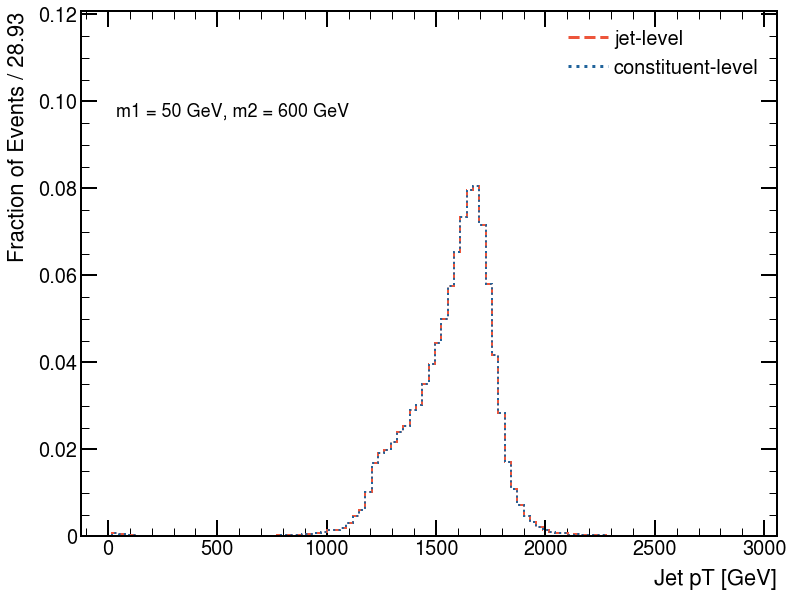

[INFO] Using deduced bin range (-0.010, 0.010)


<Figure size 640x480 with 0 Axes>

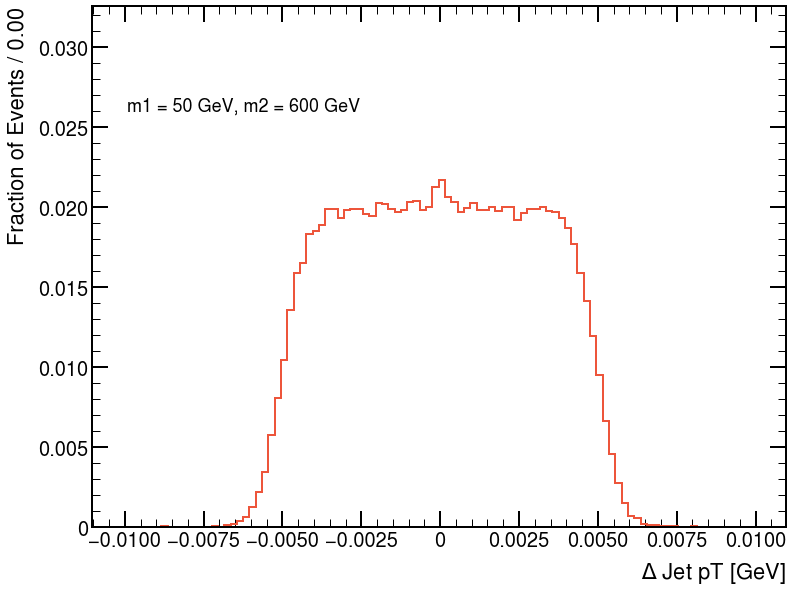

[INFO] Using deduced bin range (20.321, 3186.081)


<Figure size 640x480 with 0 Axes>

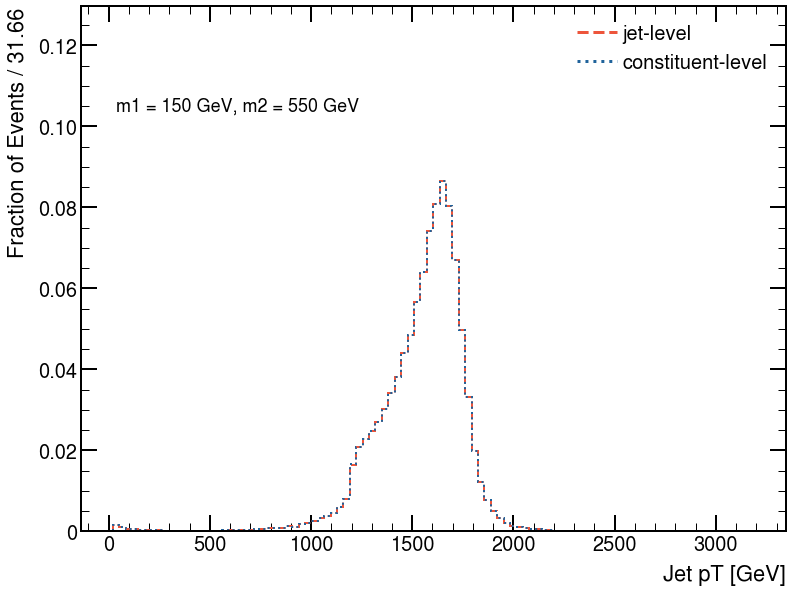

[INFO] Using deduced bin range (-0.010, 0.010)


<Figure size 640x480 with 0 Axes>

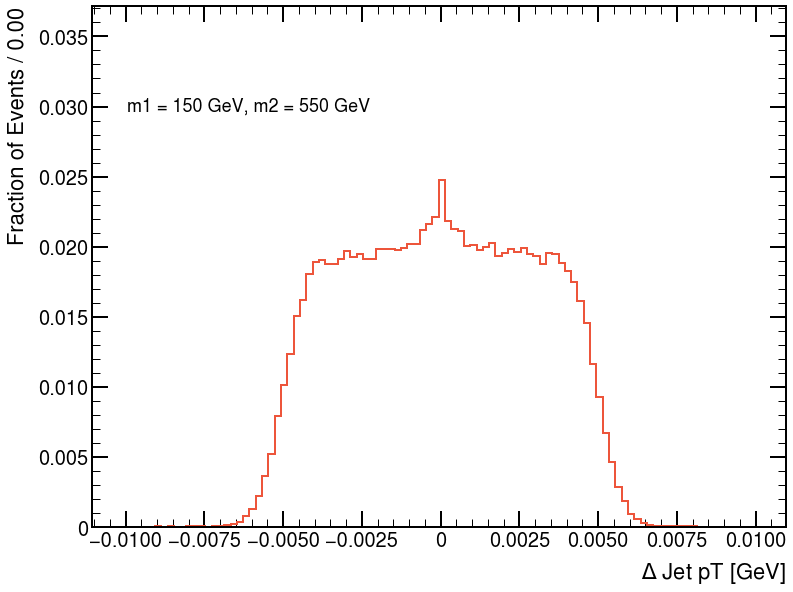

[INFO] Using deduced bin range (20.051, 2957.190)


<Figure size 640x480 with 0 Axes>

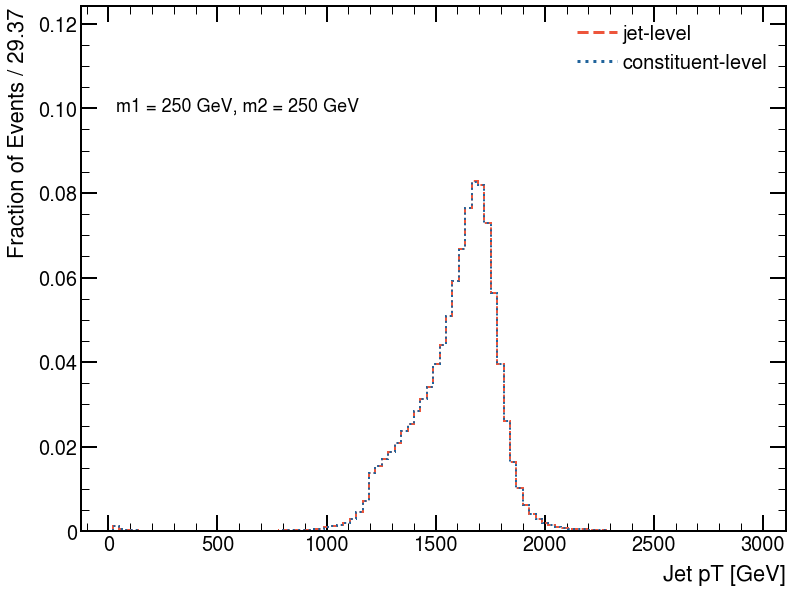

[INFO] Using deduced bin range (-0.010, 0.010)


<Figure size 640x480 with 0 Axes>

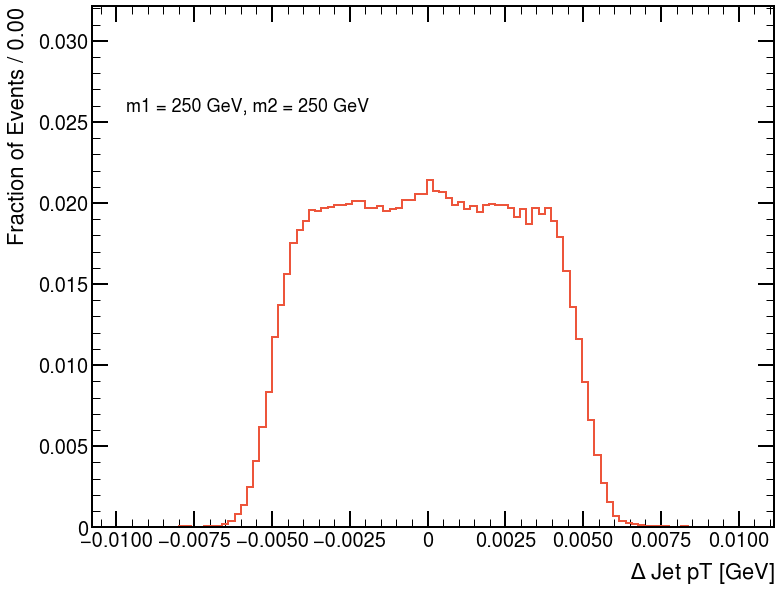

[INFO] Using deduced bin range (20.054, 3089.091)


<Figure size 640x480 with 0 Axes>

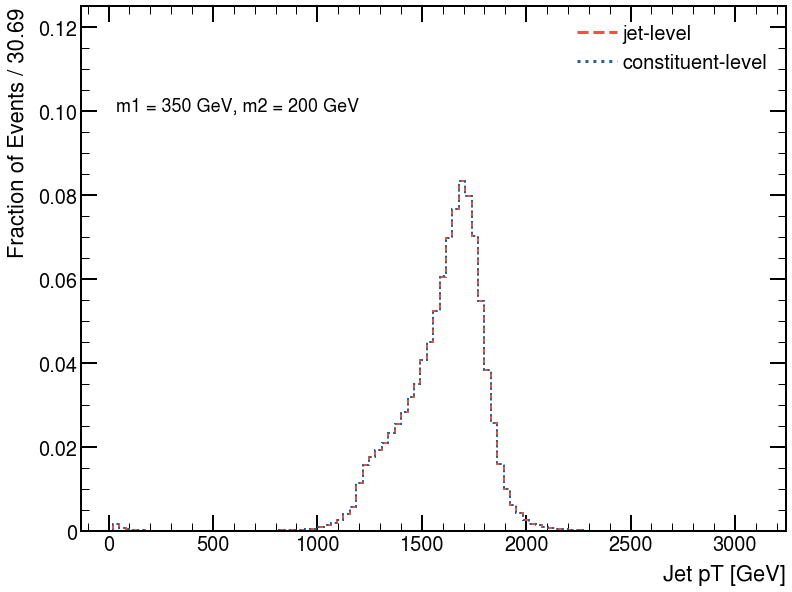

[INFO] Using deduced bin range (-0.011, 0.010)


<Figure size 640x480 with 0 Axes>

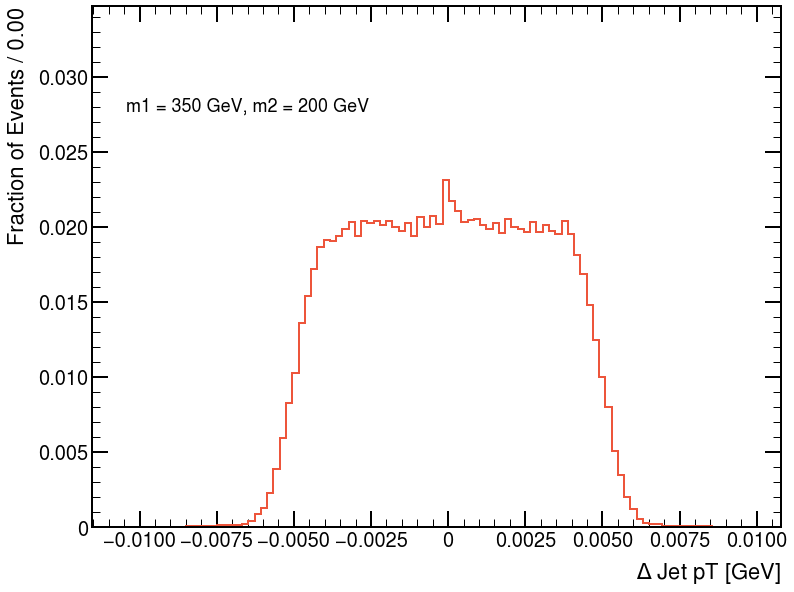

In [5]:
from quickstats.plots import VariableDistributionPlot
from quickstats.plots.template import create_transform
import pandas as pd
import matplotlib.pyplot as plt
target_masses = [[50, 600], [150, 550], [250, 250], [350, 200]]

outdir = ("/pscratch/sd/c/chlcheng/dataset/anomaly_detection/"
          "LHC_Olympics_2020/LHCO_RnD/parquet/row_based")
outname = "point_cloud_W_qq_{m1}_{m2}.parquet"

for masses in target_masses:
    m1, m2 = masses
    filename = os.path.join(outdir, outname.format(m1=m1, m2=m2))
    data = ak.from_parquet(filename)
    jet_p4 = ak.sum(data['part_features'], axis=1)
    dfs = {
        'jet'  : pd.DataFrame({"pt": data['jet_features'][:, 0]}),
        'part' : pd.DataFrame({"pt": jet_p4.pt})
    }
    df = pd.DataFrame({"delta_pt": dfs["jet"]["pt"].values - dfs["part"]["pt"].values})
    label_map = {
        'jet': 'jet-level',
        'part': 'constituent-level'
    }
    plot_options = {
        'jet': {
            'styles': {
                'linestyle': 'dashed'
            }
        },
        'part': {
            'styles': {
                'linestyle': 'dotted'
            }
        }, 
    }
    plotter = VariableDistributionPlot(dfs, plot_options=plot_options, label_map=label_map)
    ax = plotter.draw('pt', xlabel='Jet pT [GeV]', bins=100)
    transform = create_transform('axis', 'axis')
    ax.text(0.05, 0.8, f'm1 = {m1} GeV, m2 = {m2} GeV', transform=transform, fontsize=18)
    plt.show()
    plotter = VariableDistributionPlot(df)
    ax = plotter.draw('delta_pt', xlabel='$\Delta$ Jet pT [GeV]', bins=100)
    transform = create_transform('axis', 'axis')
    ax.text(0.05, 0.8, f'm1 = {m1} GeV, m2 = {m2} GeV', transform=transform, fontsize=18)
    plt.show()

## Step 2: Column-based representation

In [3]:
def get_feature_array(filename:str, outname:str=None, cache:bool=True,
                      return_result:bool=True, njet:int=2):
    if cache and (outname is not None) and os.path.exists(outname):
        sys.stdout.write(f'INFO: Cached output from "{outname}"\n')
        if return_result:
            return ak.from_parquet(outname)
        return None
    sys.stdout.write(f'INFO: Working on input file "{filename}"\n')
    data = ak.from_parquet(filename)
    array = {}
    for jet_index in range(njet):
        jet_key = f'j{jet_index+1}'
        jet_mask = data['jet_index'] == jet_index
        jet_features = data['jet_features'][jet_mask]
        part_features = data['part_features'][jet_mask]
        array[jet_key] = {}
        # jet features
        array[jet_key]["jet_pt"]   = jet_features[:, 0] / 1000.
        array[jet_key]["jet_eta"]  = jet_features[:, 1]
        array[jet_key]["jet_phi"]  = jet_features[:, 2]
        array[jet_key]["jet_m"]    = jet_features[:, 3] / 1000.
        array[jet_key]["jet_btag"] = jet_features[:, 4]
        array[jet_key]["N"]        = ak.num(part_features, axis=-1)
        for i in range(5):
            array[jet_key][f'tau{i+1}'] = jet_features[:, 5 + i]
        tau_mask = np.array(((jet_features[:, 5] > 0) & (jet_features[:, 6] > 0)))
        array[jet_key]['tau12'] = np.where(tau_mask, np.divide(jet_features[:, 6],
                                                               jet_features[:, 5], where=tau_mask), 0)
        array[jet_key]['tau23'] = np.where(tau_mask, np.divide(jet_features[:, 7],
                                                               jet_features[:, 6], where=tau_mask), 0)
        jet_p4 = Momentum4DArrayBuilder.get_array_from_dict({
            'pt'  : jet_features[:, 0],
            'eta' : jet_features[:, 1],
            'phi' : jet_features[:, 2],
            'm'   : jet_features[:, 3]})
        # particle features
        array[jet_key]['part_pt']        = part_features.pt / 1000.
        array[jet_key]['part_eta']       = part_features.eta
        array[jet_key]['part_phi']       = part_features.phi
        array[jet_key]['part_e']         = part_features.e / 1000.
        array[jet_key]['part_rel_pt']    = part_features.pt / jet_p4.pt
        array[jet_key]['part_delta_eta'] = part_features.deltaeta(jet_p4)
        array[jet_key]['part_delta_phi'] = part_features.deltaphi(jet_p4)
        array[jet_key]['part_delta_R']   = part_features.deltaR(jet_p4)
    
    ak_array = ak.Array(array)
    # evaluate mjj
    j1_p4 = ak.zip({
    "pt"  : ak_array["j1"]["jet_pt"],
    "eta" : ak_array["j1"]["jet_eta"],
    "phi" : ak_array["j1"]["jet_phi"],
    "m"   : ak_array["j1"]["jet_m"]
    }, with_name="Momentum4D")
    j2_p4 = ak.zip({
        "pt"  : ak_array["j2"]["jet_pt"],
        "eta" : ak_array["j2"]["jet_eta"],
        "phi" : ak_array["j2"]["jet_phi"],
        "m"   : ak_array["j2"]["jet_m"]
    }, with_name="Momentum4D")
    jj_p4 = j1_p4.add(j2_p4)
    ak_array['jj'] = ak.Array({'mjj': jj_p4.m,
                               'jj_pt': jj_p4.pt})
    if outname is not None:
        sys.stdout.write(f'INFO: Saving output to "{outname}"\n')
        ak.to_parquet(ak_array, outname)
    if return_result:
        return ak_array
    return None

def get_task_args(dirname:str, filename_regex, outdir:str, outname:str,
                  cache:bool=True):
    filenames = glob.glob(os.path.join(dirname, "*.parquet"))
    outnames = []
    for filename in filenames:
        basename = os.path.basename(filename)
        result = filename_regex.match(basename)
        if not result:
            continue
        m1, m2 = result.group('m1'), result.group('m2')
        outname_fmt = os.path.join(outdir, outname.format(m1=m1, m2=m2))
        outnames.append(outname_fmt)
    task_args = (filenames, outnames, repeat(cache), repeat(False))
    return task_args

$W\rightarrow X(qq)Y(qq)$ signal

In [4]:
dirname = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based"
filename_regex = re.compile("point_cloud_W_qq_(?P<m1>[0-9]*)_(?P<m2>[0-9]*).parquet")
outdir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/col_based"
outname = "point_cloud_W_qq_{m1}_{m2}.parquet"
os.makedirs(outdir, exist_ok=True)
task_args = get_task_args(dirname, filename_regex, outdir, outname, cache=True)
_ = execute_multi_tasks(get_feature_array, *task_args, parallel=16)

INFO: Working on input file "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qqq_400_100.parquet"
INFO: Working on input file "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qqq_50_100.parquet"
INFO: Working on input file "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qq_400_550.parquet"
INFO: Working on input file "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qq_150_600.parquet"
INFO: Working on input file "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qqq_50_550.parquet"
INFO: Working on input file "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qq_400_450.parquet"
INFO: Working on input file "/pscratch/sd/c/chlchen

ArrowInvalid: Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

$W\rightarrow X(qqq)Y(qq)$ signal

In [5]:
dirname = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based"
filename_regex = re.compile("point_cloud_W_qqq_(?P<m1>[0-9]*)_(?P<m2>[0-9]*).parquet")
outdir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/col_based"
outname = "point_cloud_W_qqq_{m1}_{m2}.parquet"
os.makedirs(outdir, exist_ok=True)
task_args = get_task_args(dirname, filename_regex, outdir, outname, cache=True)
_ = execute_multi_tasks(get_feature_array, *task_args, parallel=16)

INFO: Working on input file "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qqq_400_100.parquet"
INFO: Working on input file "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qqq_50_100.parquet"
INFO: Working on input file "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qqq_200_250.parquet"
INFO: Working on input file "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qq_150_600.parquet"
INFO: Working on input file "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qqq_300_600.parquet"
INFO: Working on input file "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/row_based/point_cloud_W_qq_400_450.parquet"
INFO: Working on input file "/pscratch/sd/c/chlch

ArrowInvalid: Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

### Apply Signal Region selection

- Select events in the signal region defined by $3.3 < m_{jj} < 3.7$ TeV

In [ ]:
def apply_SR_selection(filename:str, outname:str=None,
                       cache:bool=True, return_result:bool=False):
    if cache and (outname is not None) and os.path.exists(outname):
        sys.stdout.write(f'INFO: Cached output from "{outname}"\n')
        if return_result:
            return ak.from_parquet(outname)
        return None
    sys.stdout.write(f'INFO: Working on input file "{filename}"\n')
    data = ak.from_parquet(filename)
    mjj = data['jj']['mjj']
    SR_mask = np.where((mjj > 3.3) & (mjj < 3.7))
    SR_data = data[SR_mask]
    if outname is not None:
        sys.stdout.write(f'INFO: Saving output to "{outname}"\n')
        ak.to_parquet(SR_data, outname)
    if return_result:
        return SR_data
    return None

def get_task_args(dirname:str, filename_regex, outdir:str, outname:str,
                  cache:bool=True):
    filenames = glob.glob(os.path.join(dirname, "*.parquet"))
    outnames = []
    for filename in filenames:
        basename = os.path.basename(filename)
        result = filename_regex.match(basename)
        if not result:
            continue
        m1, m2 = result.group('m1'), result.group('m2')
        outname_fmt = os.path.join(outdir, outname.format(m1=m1, m2=m2))
        outnames.append(outname_fmt)
    task_args = (filenames, outnames, repeat(cache), repeat(False))
    return task_args

$W\rightarrow X(qq)Y(qq)$ signal

In [ ]:
dirname = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/col_based"
filename_regex = re.compile("point_cloud_W_qq_(?P<m1>[0-9]*)_(?P<m2>[0-9]*).parquet")
outdir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/col_based"
outname = "SR_point_cloud_W_qq_{m1}_{m2}.parquet"
os.makedirs(outdir, exist_ok=True)
task_args = get_task_args(dirname, filename_regex, outdir, outname, cache=True)
_ = execute_multi_tasks(apply_SR_selection, *task_args, parallel=16)

$W\rightarrow X(qqq)Y(qq)$ signal

In [ ]:
dirname = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/col_based"
filename_regex = re.compile("point_cloud_W_qqq_(?P<m1>[0-9]*)_(?P<m2>[0-9]*).parquet")
outdir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD/parquet/col_based"
outname = "SR_point_cloud_W_qqq_{m1}_{m2}.parquet"
os.makedirs(outdir, exist_ok=True)
task_args = get_task_args(dirname, filename_regex, outdir, outname, cache=True)
_ = execute_multi_tasks(apply_SR_selection, *task_args, parallel=16)

## Visualize kinematic distributions

In [14]:
import os
basedir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_qq"
filename = os.path.join(basedir, output_format, "col_based", "SR_point_cloud_W_qq_500_100_official." + output_format)
feature_arrays["500_100_LHCO"] = load_fn(filename)

In [15]:
import pandas as pd
from quickstats.plots import VariableDistributionPlot
dfs = {}
for masses in (masses_to_keep + ["500_100_LHCO"]):
    data = {
        "lead_jet_pt"    : np.array(feature_arrays[masses]["j1"]["jet_pt"]),
        "lead_jet_eta"   : np.array(feature_arrays[masses]["j1"]["jet_eta"]),
        "lead_jet_phi"   : np.array(feature_arrays[masses]["j1"]["jet_phi"]),
        "lead_jet_m"     : np.array(feature_arrays[masses]["j1"]["jet_m"]),
        "lead_jet_N"     : np.array(feature_arrays[masses]["j1"]["N"]),
        "lead_jet_tau1"  : np.array(feature_arrays[masses]["j1"]["tau1"]),
        "lead_jet_tau2"  : np.array(feature_arrays[masses]["j1"]["tau2"]),
        "lead_jet_tau3"  : np.array(feature_arrays[masses]["j1"]["tau3"]),
        "lead_jet_tau12" : np.array(feature_arrays[masses]["j1"]["tau12"]),
        "lead_jet_tau23" : np.array(feature_arrays[masses]["j1"]["tau23"]),
        "sub_jet_pt"     : np.array(feature_arrays[masses]["j2"]["jet_pt"]),
        "sub_jet_eta"    : np.array(feature_arrays[masses]["j2"]["jet_eta"]),
        "sub_jet_phi"    : np.array(feature_arrays[masses]["j2"]["jet_phi"]),
        "sub_jet_m"      : np.array(feature_arrays[masses]["j2"]["jet_m"]),
        "sub_jet_N"      : np.array(feature_arrays[masses]["j2"]["N"]),
        "sub_jet_tau1"   : np.array(feature_arrays[masses]["j2"]["tau1"]),
        "sub_jet_tau2"   : np.array(feature_arrays[masses]["j2"]["tau2"]),
        "sub_jet_tau3"   : np.array(feature_arrays[masses]["j2"]["tau3"]),
        "sub_jet_tau12"  : np.array(feature_arrays[masses]["j2"]["tau12"]),
        "sub_jet_tau23"  : np.array(feature_arrays[masses]["j2"]["tau23"]),
        "mjj"            : np.array(feature_arrays[masses]["jj"]["mjj"])
    }
    dfs[masses] = pd.DataFrame(data)

<Figure size 640x480 with 0 Axes>

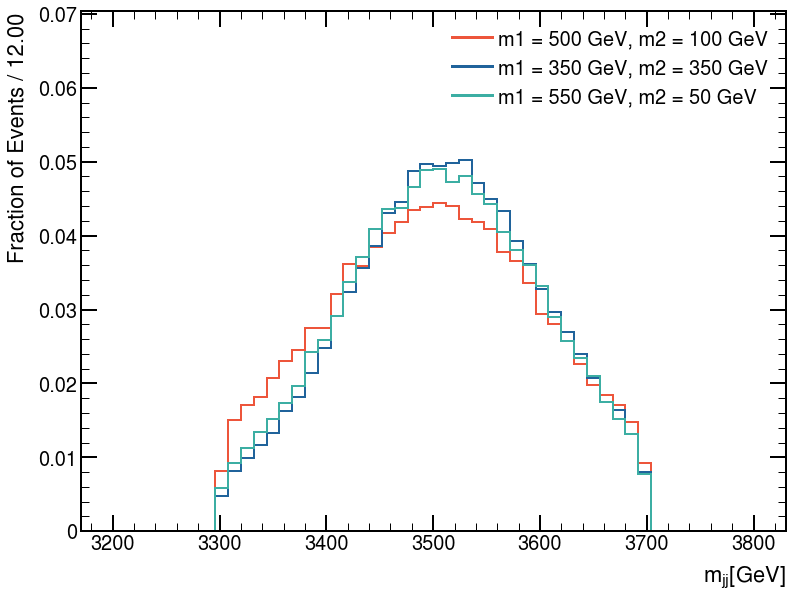

<Figure size 640x480 with 0 Axes>

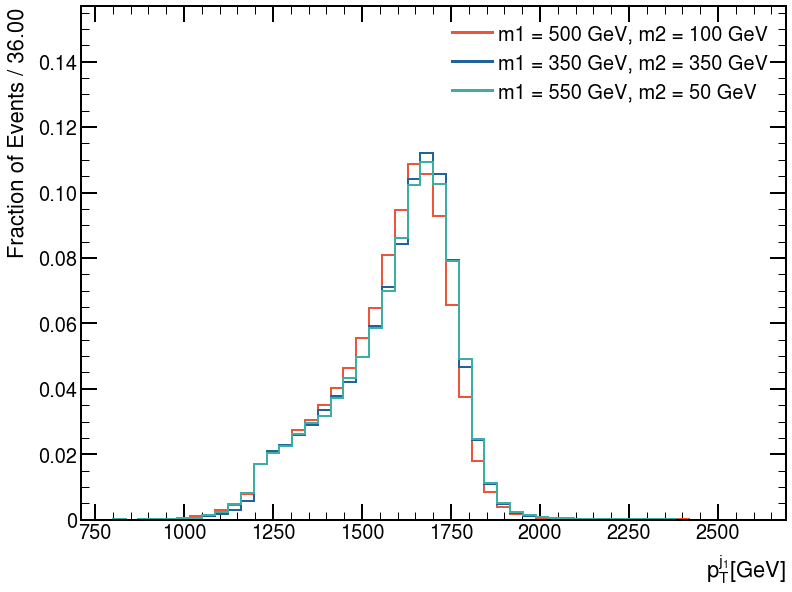

<Figure size 640x480 with 0 Axes>

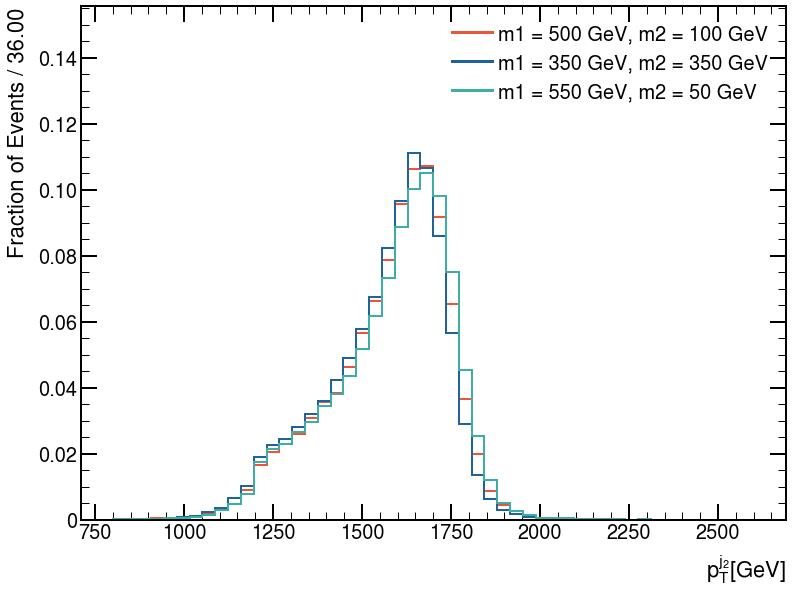

<Figure size 640x480 with 0 Axes>

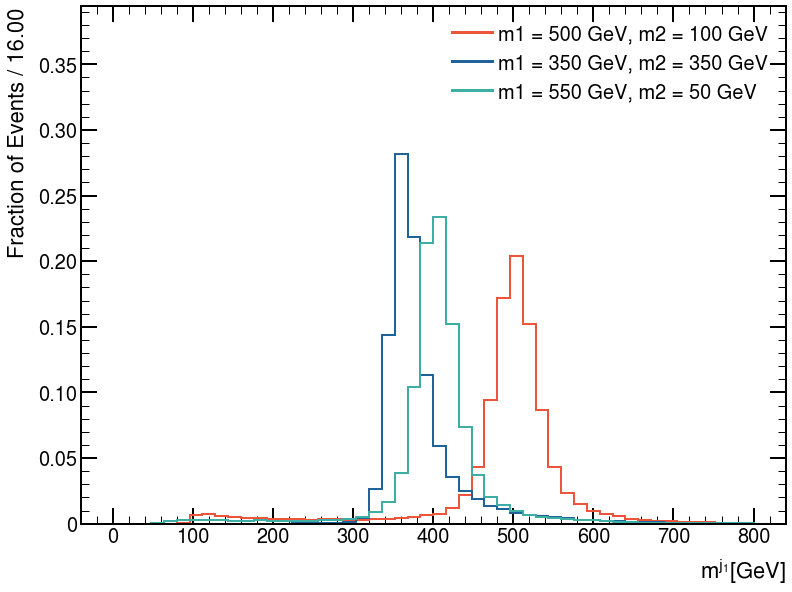

<Figure size 640x480 with 0 Axes>

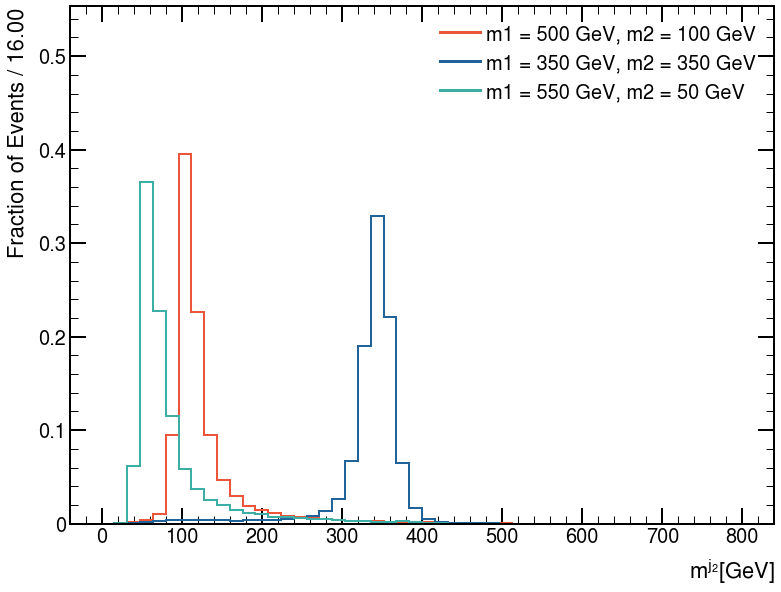

[INFO] Using deduced bin range (-2.195, 2.208)


<Figure size 640x480 with 0 Axes>

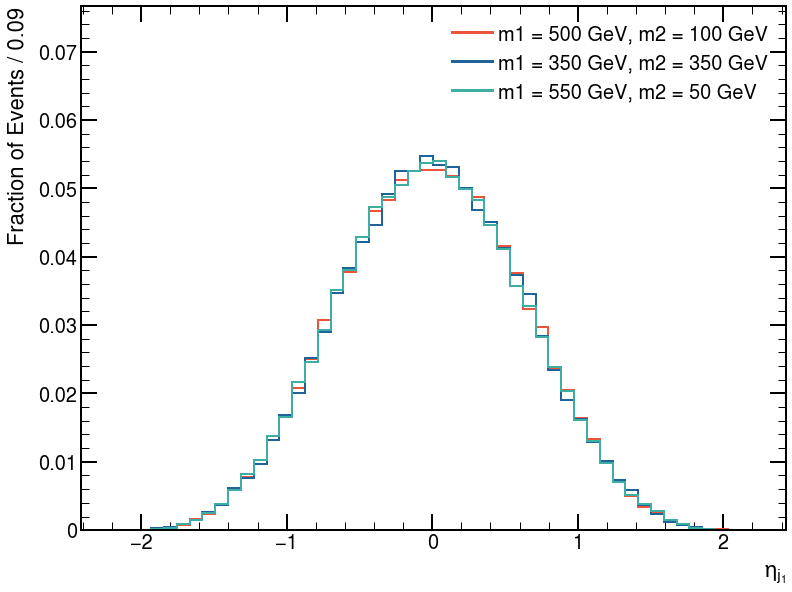

[INFO] Using deduced bin range (-2.447, 2.204)


<Figure size 640x480 with 0 Axes>

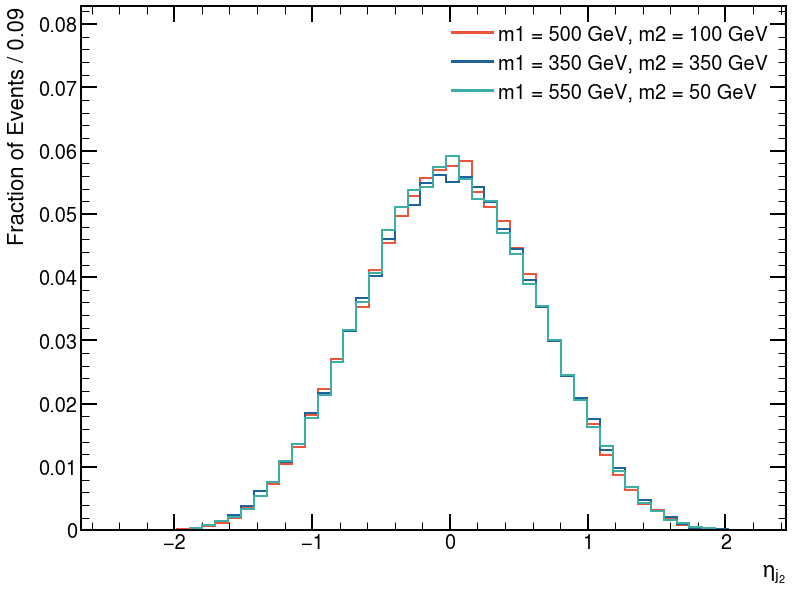

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

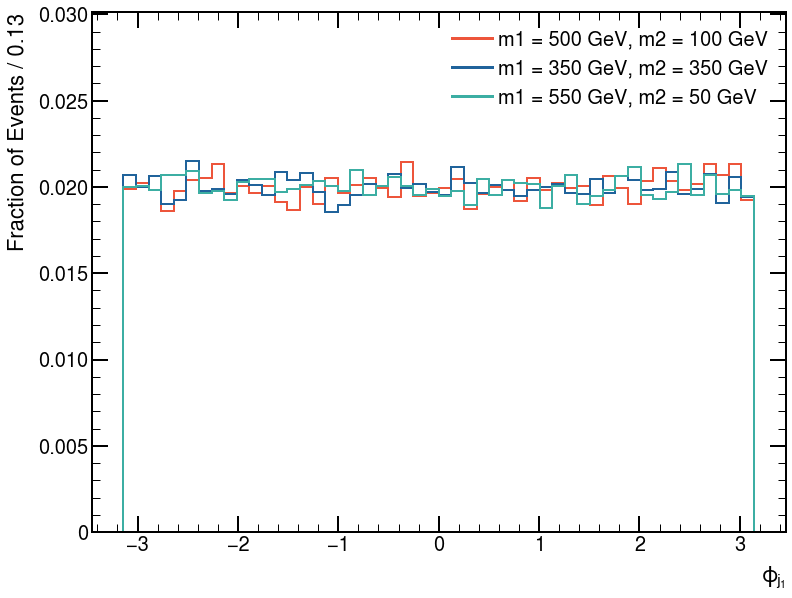

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

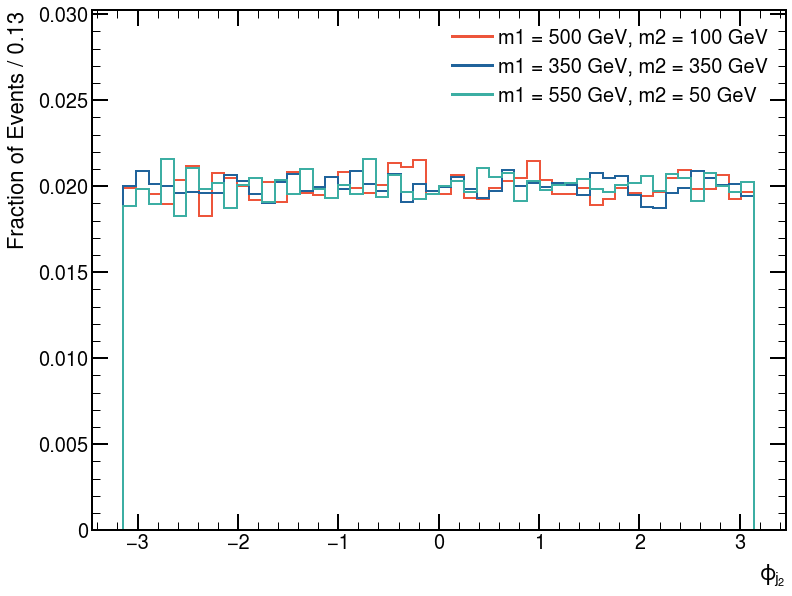

[INFO] Using deduced bin range (7.000, 191.000)


<Figure size 640x480 with 0 Axes>

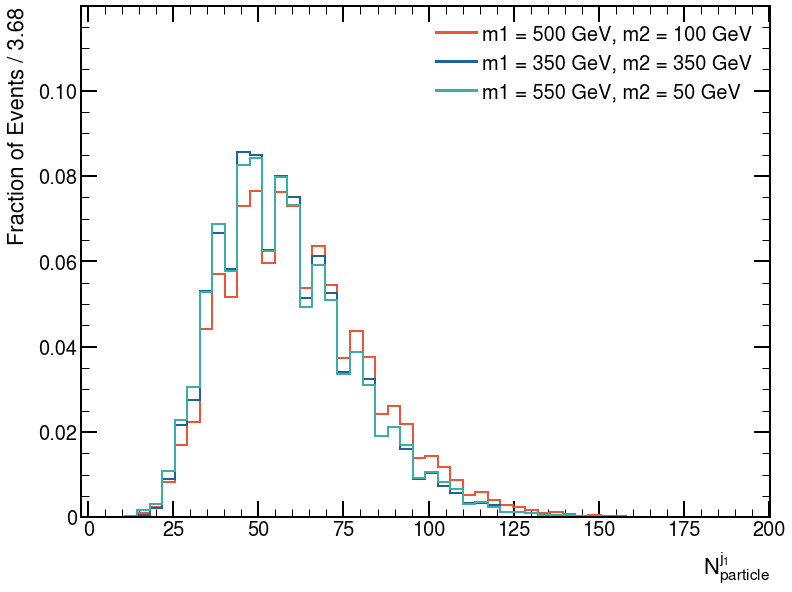

[INFO] Using deduced bin range (3.000, 160.000)


<Figure size 640x480 with 0 Axes>

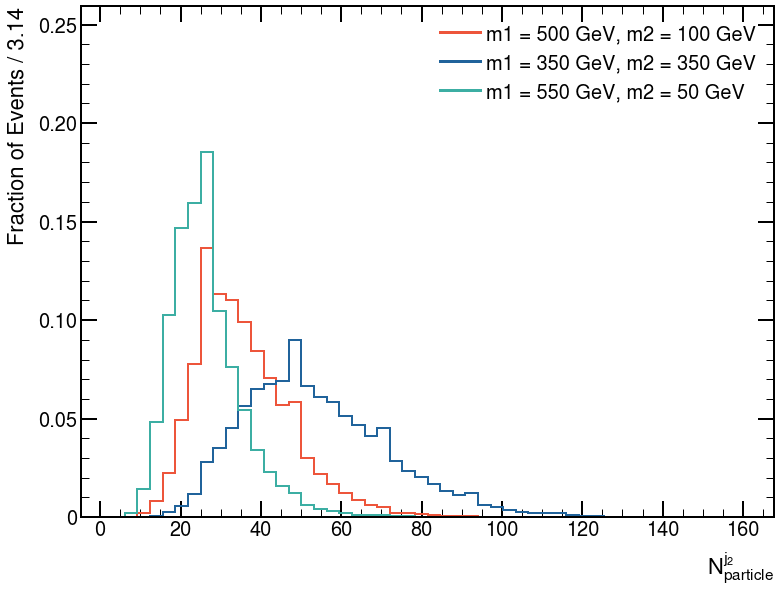

[INFO] Using deduced bin range (0.003, 0.733)


<Figure size 640x480 with 0 Axes>

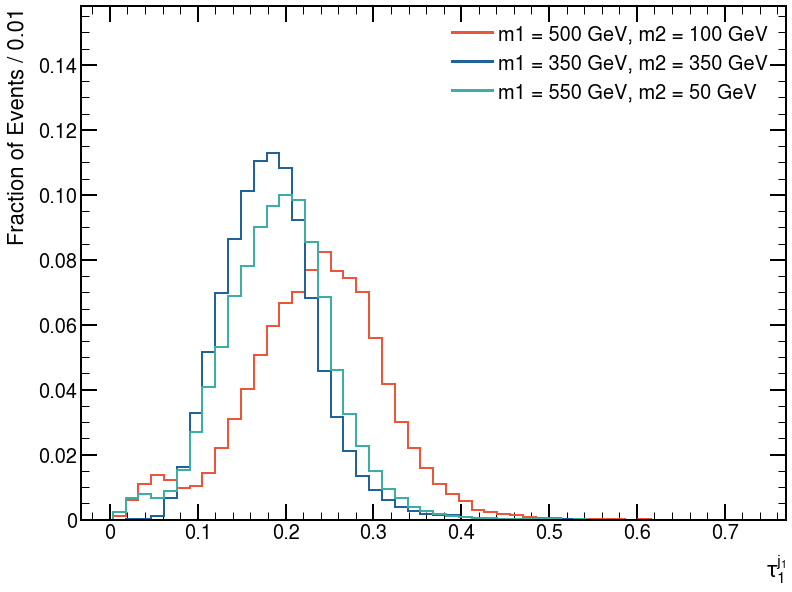

[INFO] Using deduced bin range (0.003, 0.423)


<Figure size 640x480 with 0 Axes>

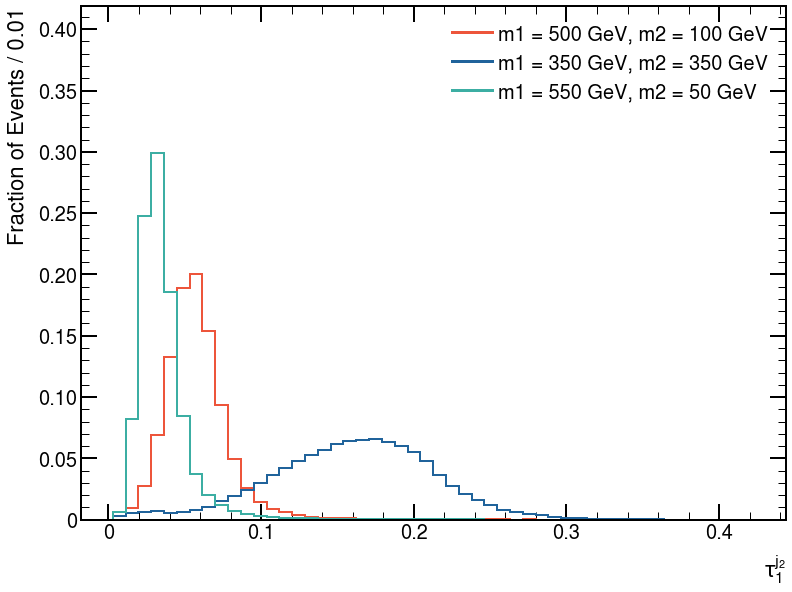

[INFO] Using deduced bin range (0.002, 0.292)


<Figure size 640x480 with 0 Axes>

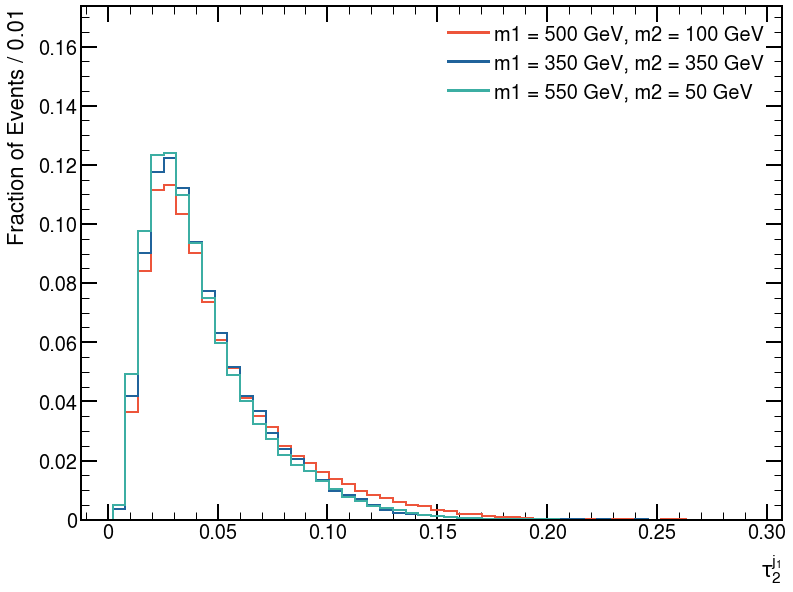

[INFO] Using deduced bin range (0.001, 0.211)


<Figure size 640x480 with 0 Axes>

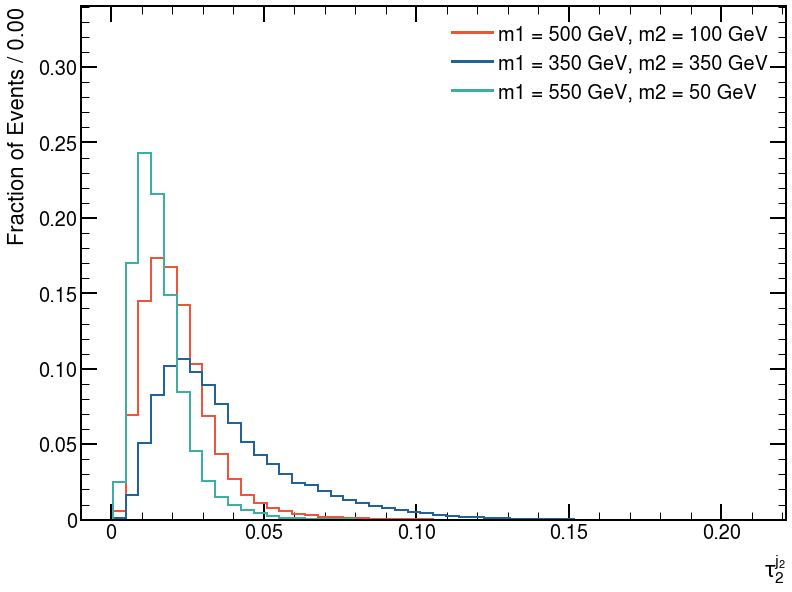

[INFO] Using deduced bin range (0.001, 0.174)


<Figure size 640x480 with 0 Axes>

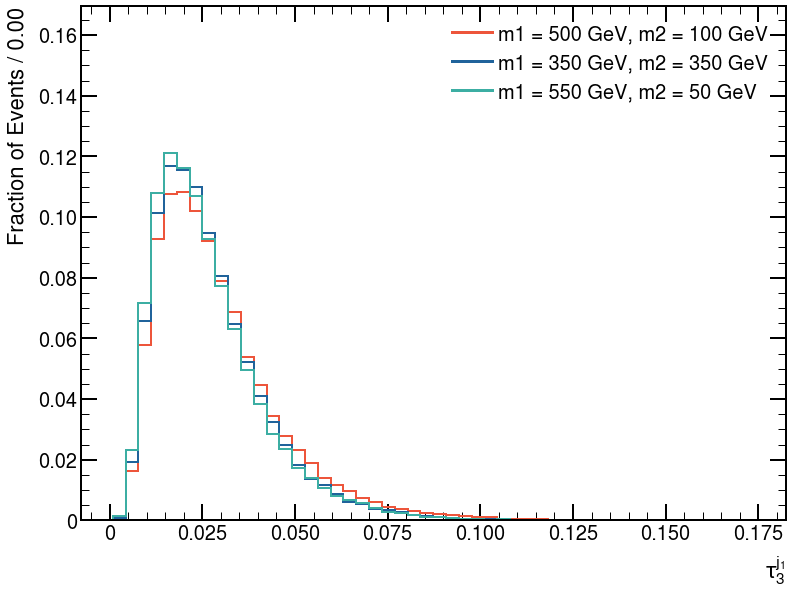

[INFO] Using deduced bin range (0.000, 0.123)


<Figure size 640x480 with 0 Axes>

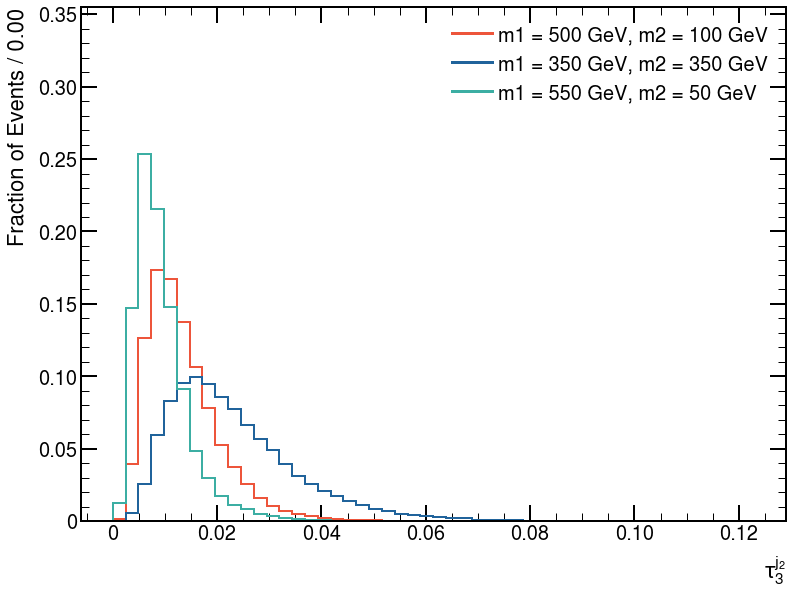

[INFO] Using deduced bin range (0.017, 0.879)


<Figure size 640x480 with 0 Axes>

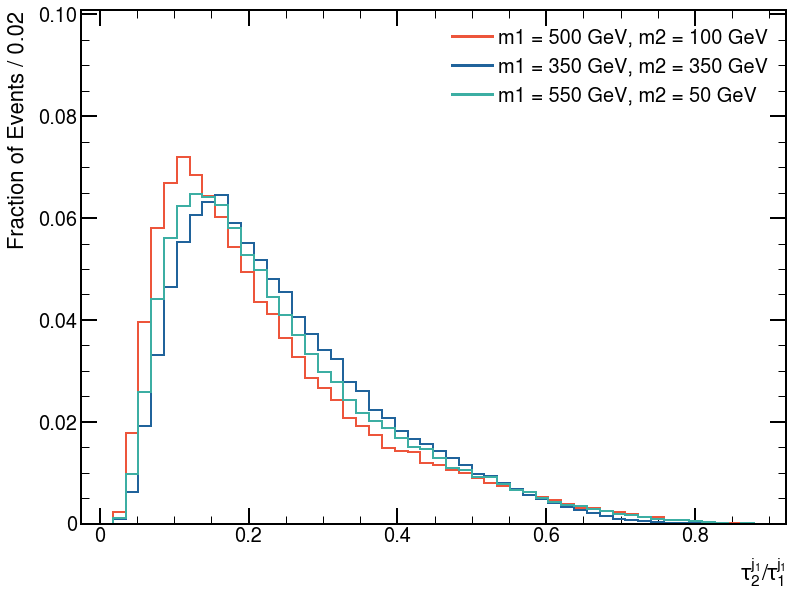

[INFO] Using deduced bin range (0.018, 0.908)


<Figure size 640x480 with 0 Axes>

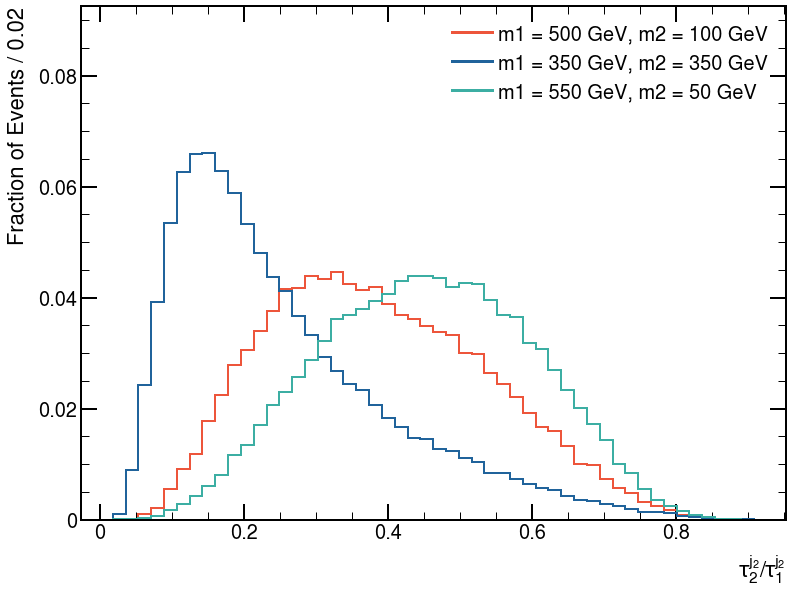

[INFO] Using deduced bin range (0.074, 0.947)


<Figure size 640x480 with 0 Axes>

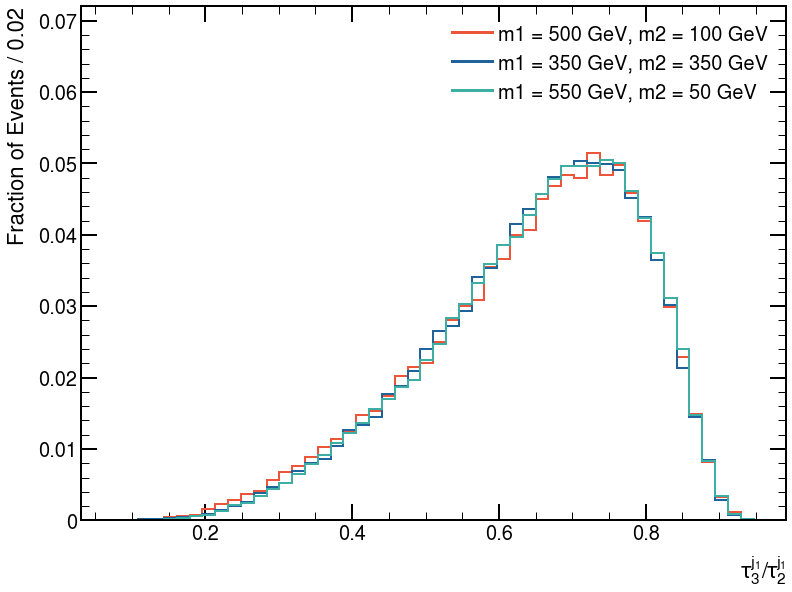

[INFO] Using deduced bin range (0.000, 0.950)


<Figure size 640x480 with 0 Axes>

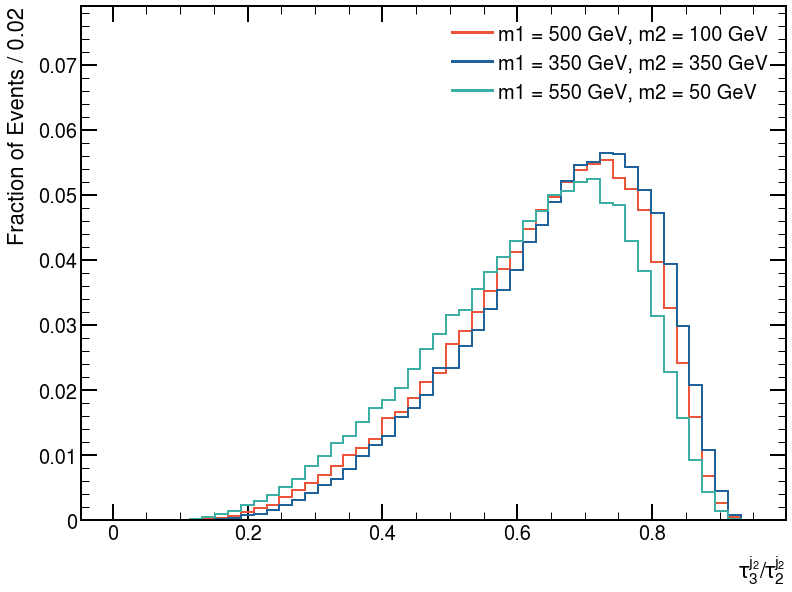

<Figure size 640x480 with 0 Axes>

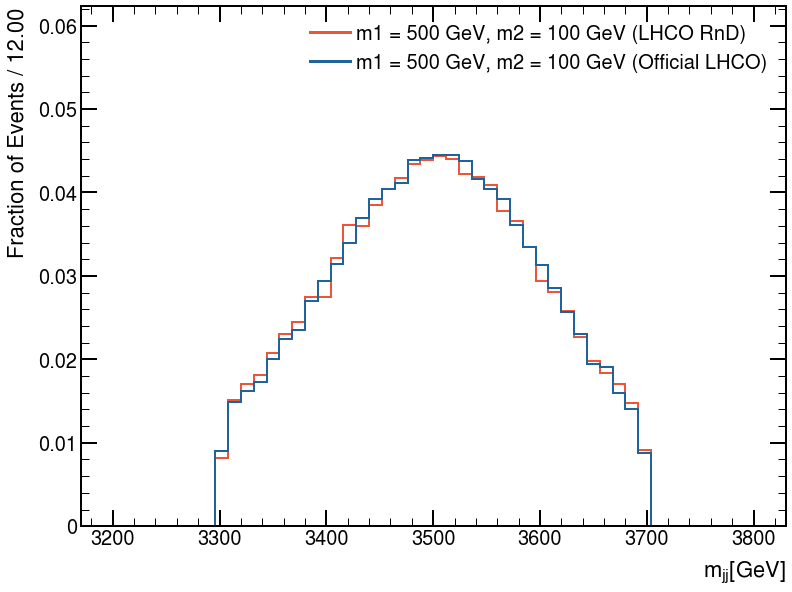

<Figure size 640x480 with 0 Axes>

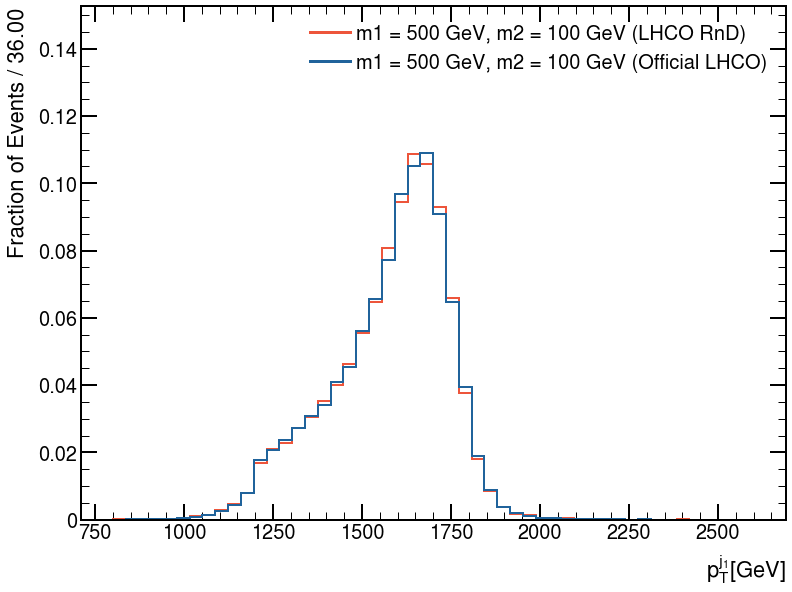

<Figure size 640x480 with 0 Axes>

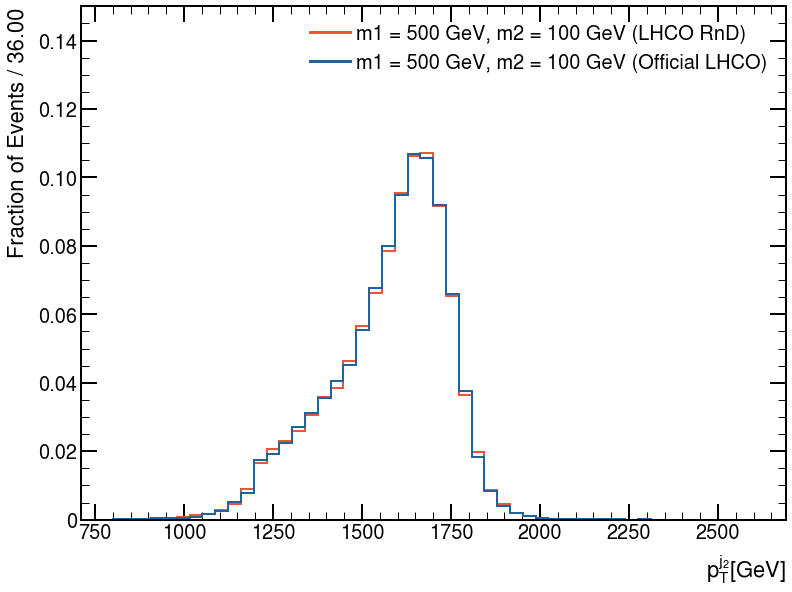

<Figure size 640x480 with 0 Axes>

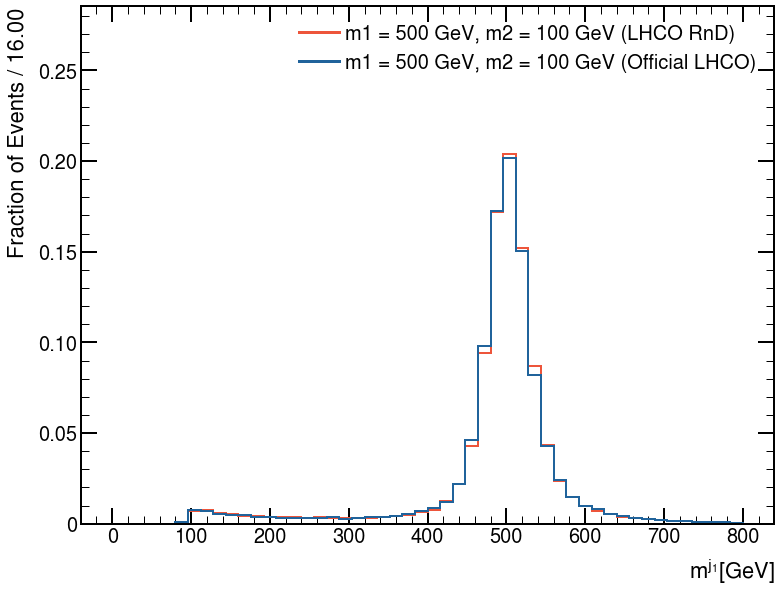

<Figure size 640x480 with 0 Axes>

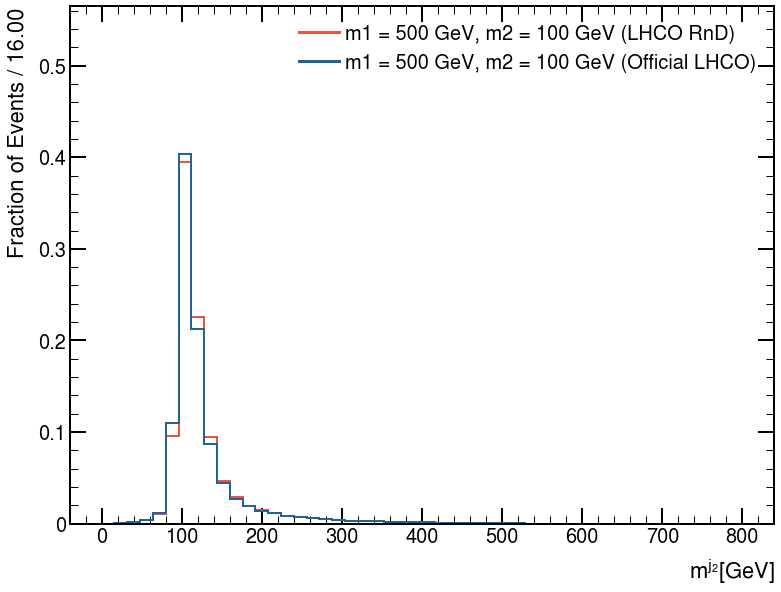

[INFO] Using deduced bin range (-2.134, 2.112)


<Figure size 640x480 with 0 Axes>

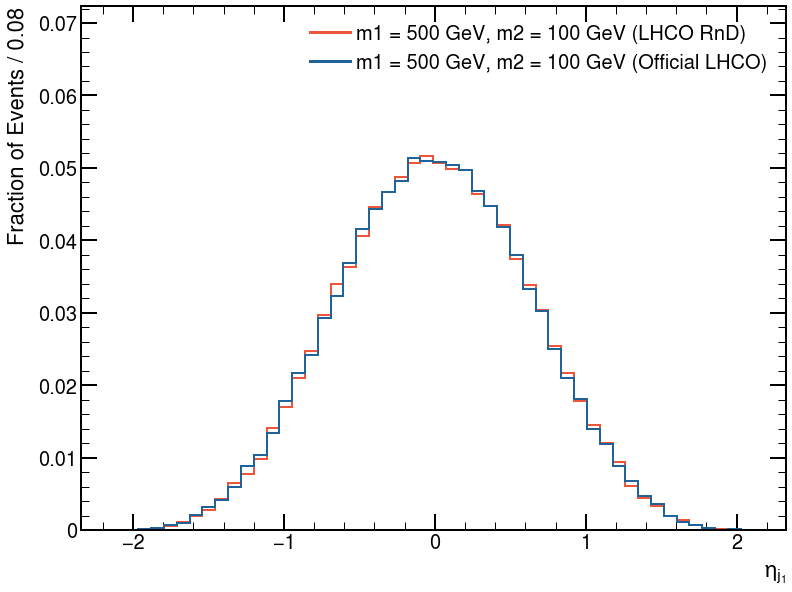

[INFO] Using deduced bin range (-2.326, 2.179)


<Figure size 640x480 with 0 Axes>

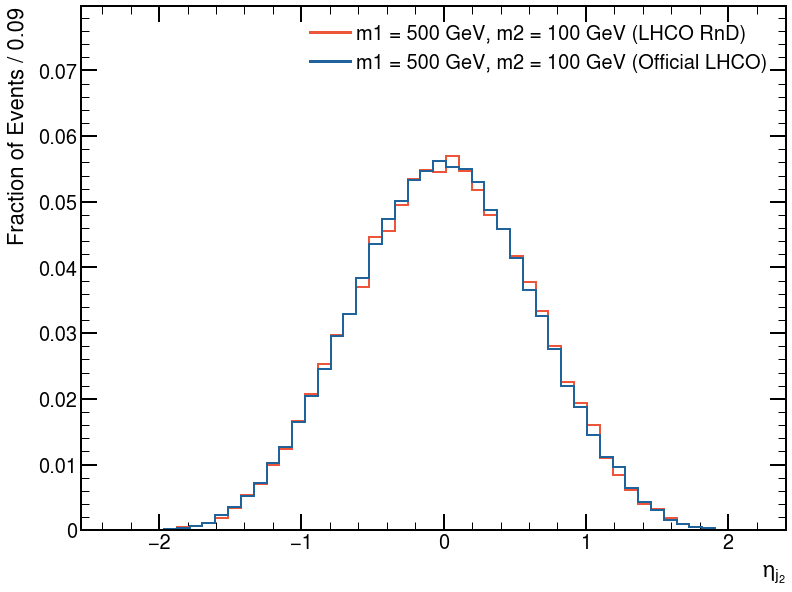

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

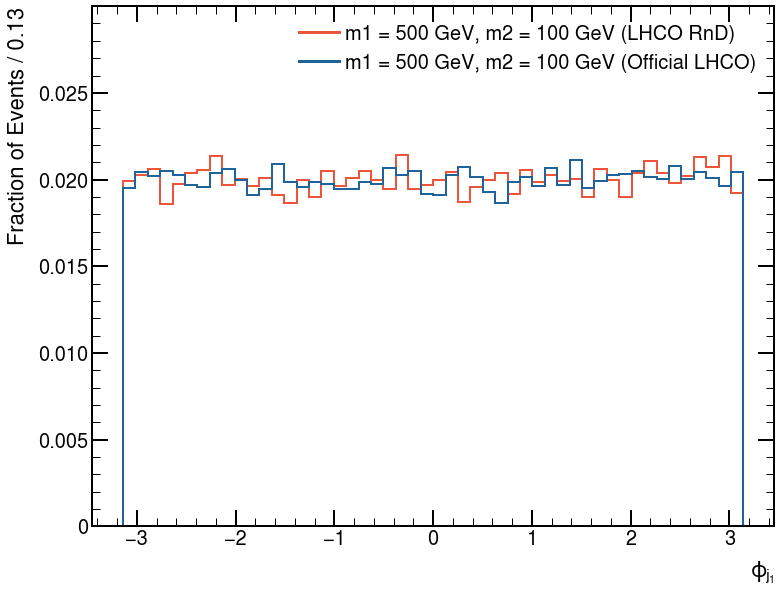

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

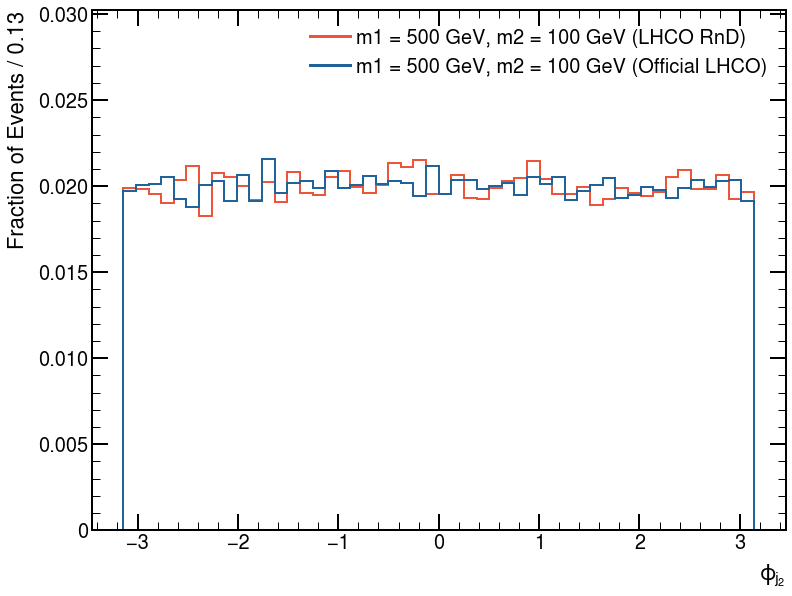

[INFO] Using deduced bin range (12.000, 190.000)


<Figure size 640x480 with 0 Axes>

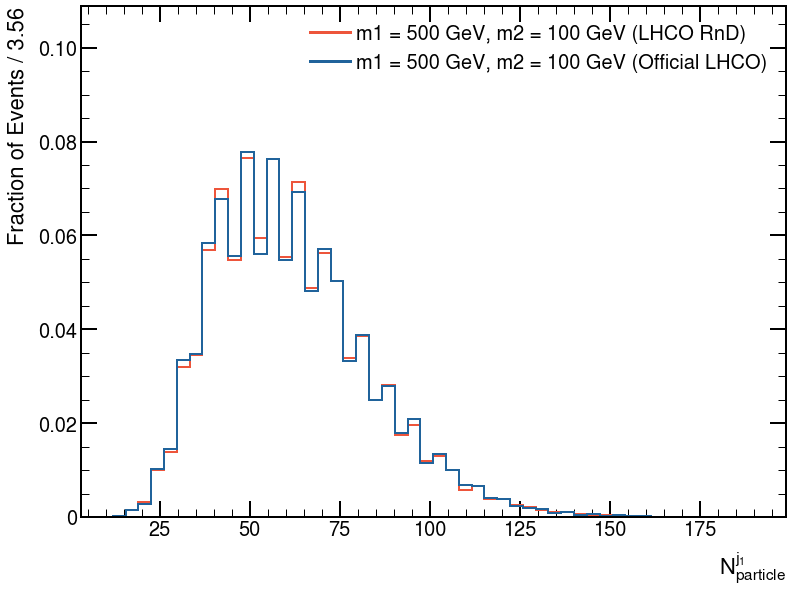

[INFO] Using deduced bin range (4.000, 175.000)


<Figure size 640x480 with 0 Axes>

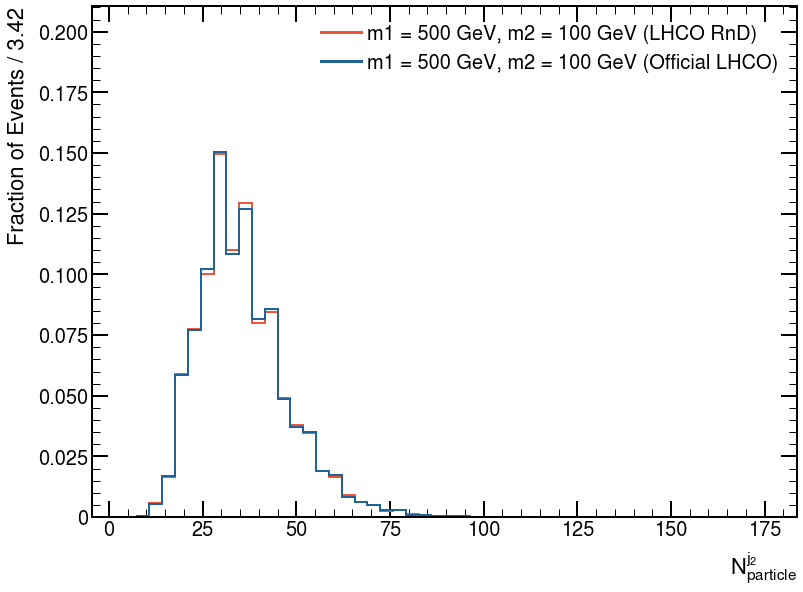

[INFO] Using deduced bin range (0.009, 1151.050)


<Figure size 640x480 with 0 Axes>

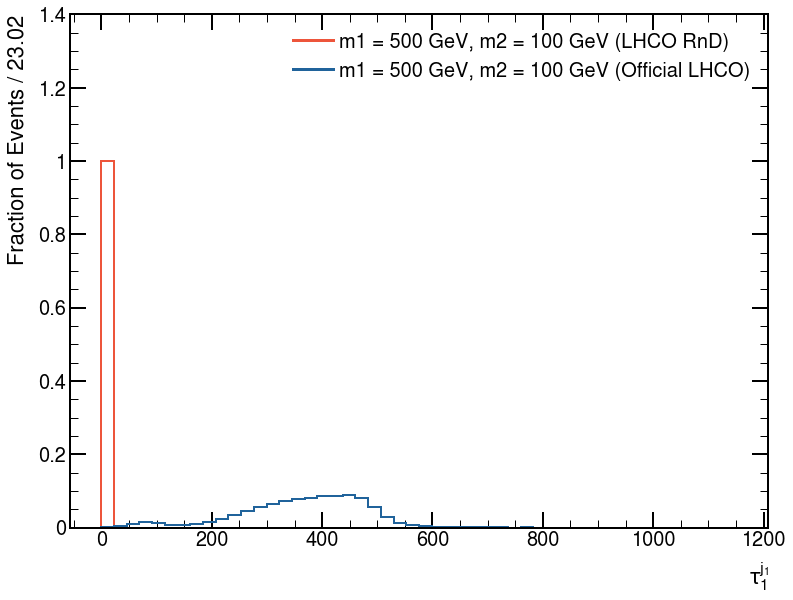

[INFO] Using deduced bin range (0.003, 681.842)


<Figure size 640x480 with 0 Axes>

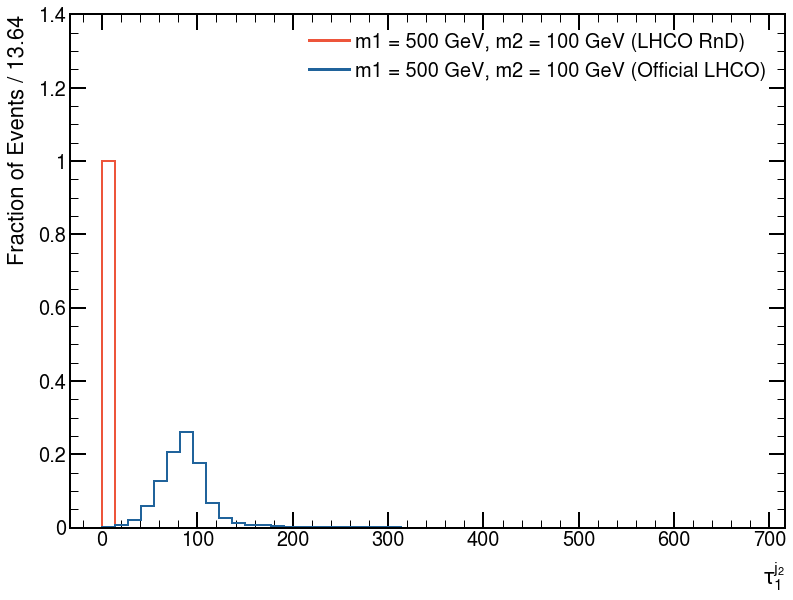

[INFO] Using deduced bin range (0.003, 521.916)


<Figure size 640x480 with 0 Axes>

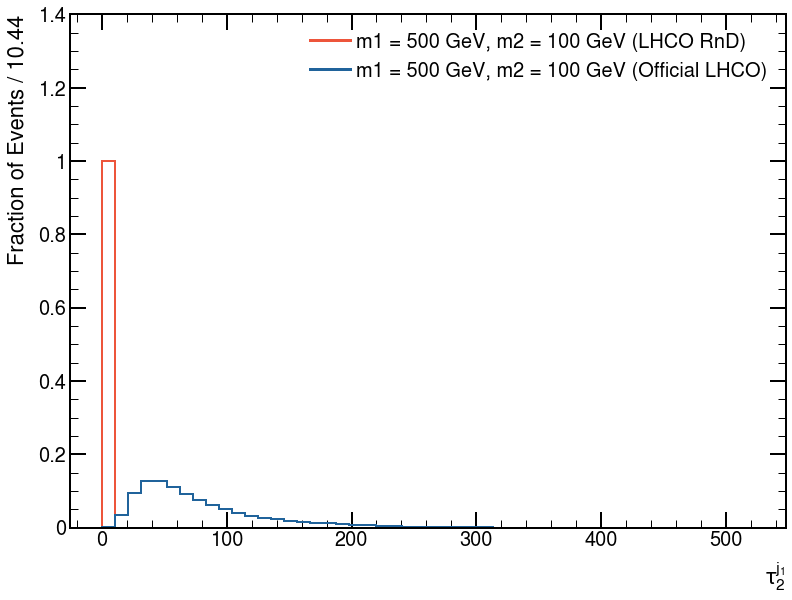

[INFO] Using deduced bin range (0.002, 248.643)


<Figure size 640x480 with 0 Axes>

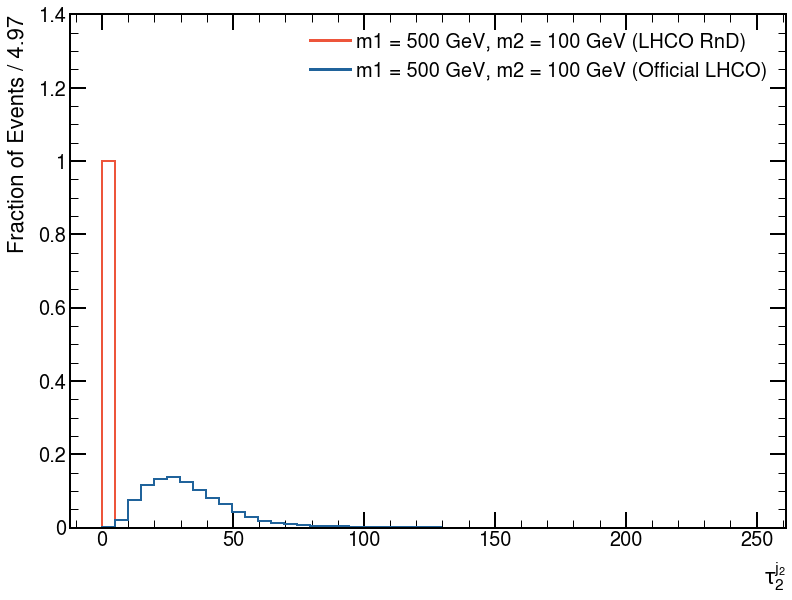

[INFO] Using deduced bin range (0.002, 272.331)


<Figure size 640x480 with 0 Axes>

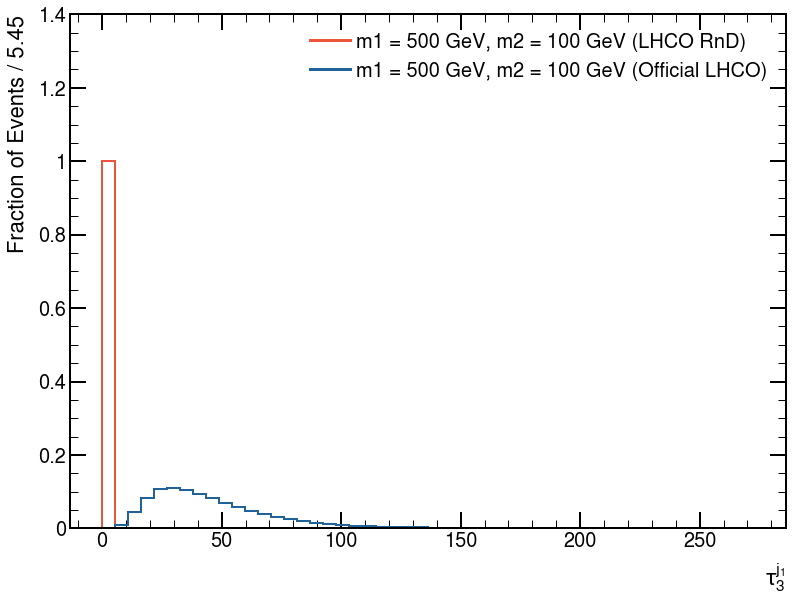

[INFO] Using deduced bin range (0.001, 183.633)


<Figure size 640x480 with 0 Axes>

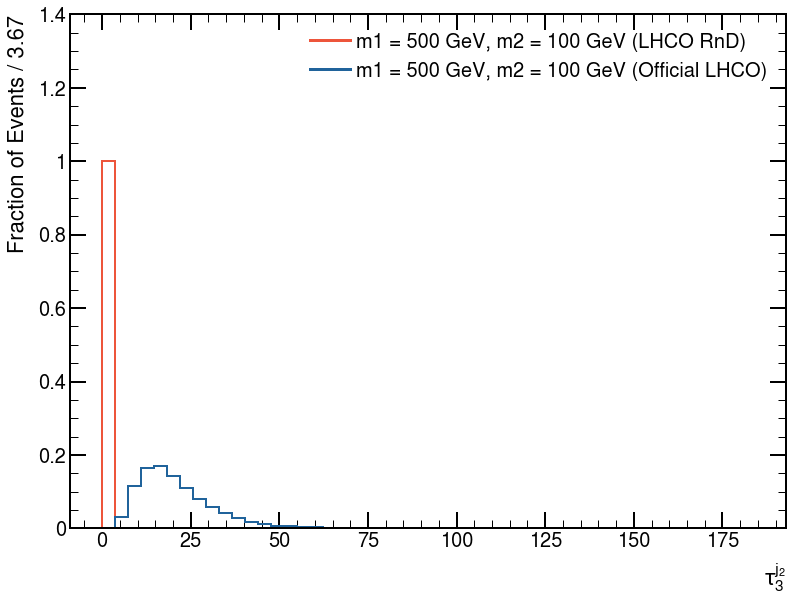

[INFO] Using deduced bin range (0.015, 0.963)


<Figure size 640x480 with 0 Axes>

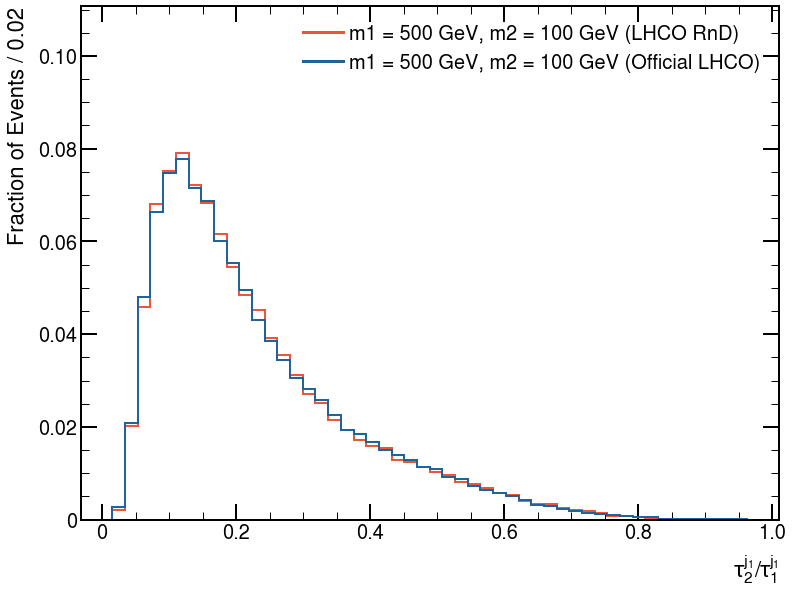

[INFO] Using deduced bin range (0.008, 0.979)


<Figure size 640x480 with 0 Axes>

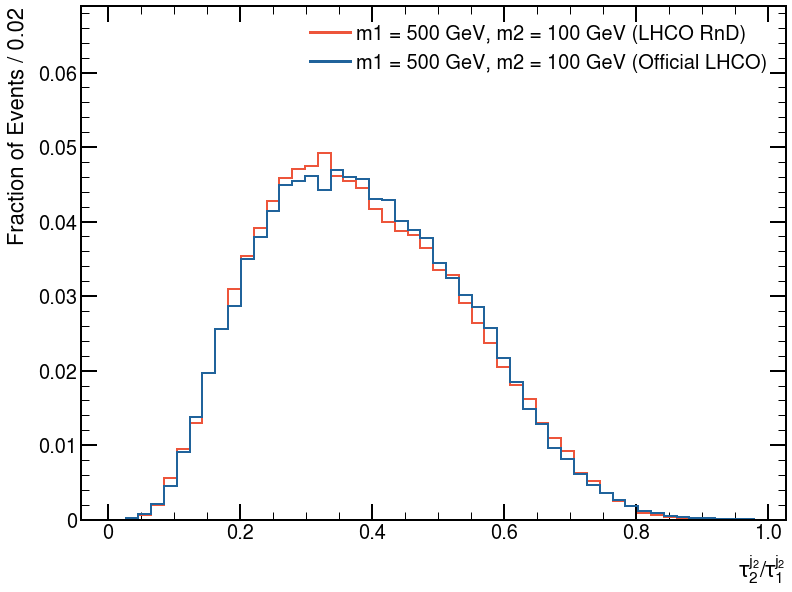

[INFO] Using deduced bin range (0.035, 0.994)


<Figure size 640x480 with 0 Axes>

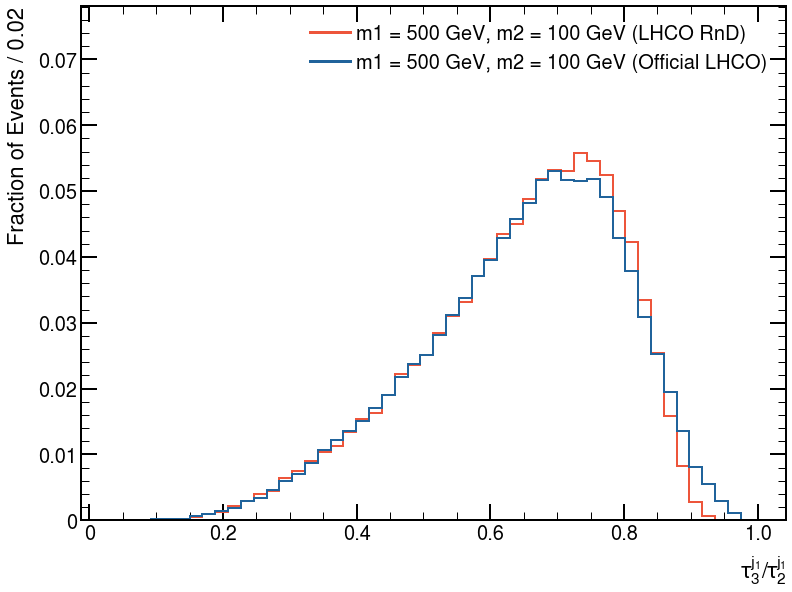

[INFO] Using deduced bin range (0.041, 0.991)


<Figure size 640x480 with 0 Axes>

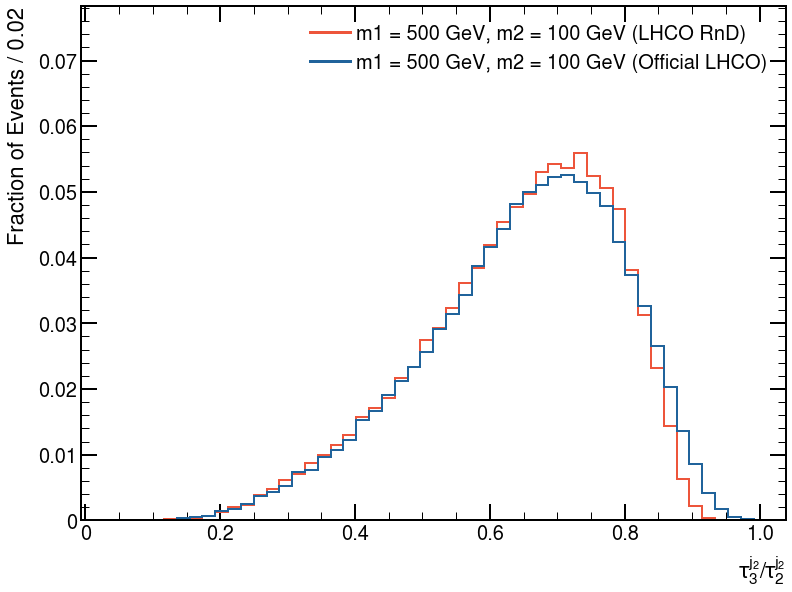

In [16]:
from quickstats.plots import VariableDistributionPlot
import matplotlib.pyplot as plt
options = {
    'mjj': {
        'xlabel': '$m_{jj} [GeV]$',
        'bin_range': (3200, 3800),
        'variable_scale': 1000
    },
    'lead_jet_pt': {
        'xlabel': '$p_T^{j_1} [GeV]$',
        'bin_range': (800, 2600),
        'variable_scale': 1000
    },
    'sub_jet_pt': {
        'xlabel': '$p_T^{j_2} [GeV]$',
        'bin_range': (800, 2600),
        'variable_scale': 1000
    },
    'lead_jet_m': {
        'xlabel': '$m^{j_1} [GeV]$',
        'bin_range': (0, 800),
        'variable_scale': 1000
    },
    'sub_jet_m': {
        'xlabel': '$m^{j_2} [GeV]$',
        'bin_range': (0, 800),
        'variable_scale': 1000
    },
    'lead_jet_eta': {
        'xlabel': r'$\eta_{j_1}$'
    },
    'sub_jet_eta': {
        'xlabel': r'$\eta_{j_2}$'
    },
    'lead_jet_phi': {
        'xlabel': r'$\phi_{j_1}$'
    },
    'sub_jet_phi': {
        'xlabel': r'$\phi_{j_2}$'
    },
    'lead_jet_N': {
        'xlabel': '$N_{particle}^{j_1}$'
    },
    'sub_jet_N': {
        'xlabel': '$N_{particle}^{j_2}$'
    },
    'lead_jet_tau1': {
        'xlabel': r'$\tau_1^{j_1}$'
    },
    'sub_jet_tau1': {
        'xlabel': r'$\tau_1^{j_2}$'
    },
    'lead_jet_tau2': {
        'xlabel': r'$\tau_2^{j_1}$'
    },
    'sub_jet_tau2': {
        'xlabel': r'$\tau_2^{j_2}$'
    },
    'lead_jet_tau3': {
        'xlabel': r'$\tau_3^{j_1}$'
    },
    'sub_jet_tau3': {
        'xlabel': r'$\tau_3^{j_2}$'
    },
    'lead_jet_tau12': {
        'xlabel': r'$\tau_2^{j_1}/\tau_1^{j_1}$'
    },
    'sub_jet_tau12': {
        'xlabel': r'$\tau_2^{j_2}/\tau_1^{j_2}$'
    },
    'lead_jet_tau23': {
        'xlabel': r'$\tau_3^{j_1}/\tau_2^{j_1}$'
    },
    'sub_jet_tau23': {
        'xlabel': r'$\tau_3^{j_2}/\tau_2^{j_2}$'
    }
}
label_map = {
    '500_100' : 'm1 = 500 GeV, m2 = 100 GeV',
    '350_350' : 'm1 = 350 GeV, m2 = 350 GeV',
    '50_400'  : 'm1 = 550 GeV, m2 = 50 GeV'
}
plotter = VariableDistributionPlot(dfs, label_map=label_map)
for column in options:
    plotter.draw(column,
                 targets=['500_100', '350_350', '50_400'],
                 #targets=['500_100', '500_100_LHCO'],
                 **options[column],
                 bins=50,
                 normalize=True,
                 ypad=0.25)
    plt.show()
label_map = {
    '500_100' : 'm1 = 500 GeV, m2 = 100 GeV (LHCO RnD)',
    '500_100_LHCO' : 'm1 = 500 GeV, m2 = 100 GeV (Official LHCO)'
}
plotter.label_map = label_map
for column in options:
    plotter.draw(column,
                 targets=['500_100', '500_100_LHCO'],
                 **options[column],
                 bins=50,
                 normalize=True,
                 ypad=0.25)
    plt.show()

<Figure size 640x480 with 0 Axes>

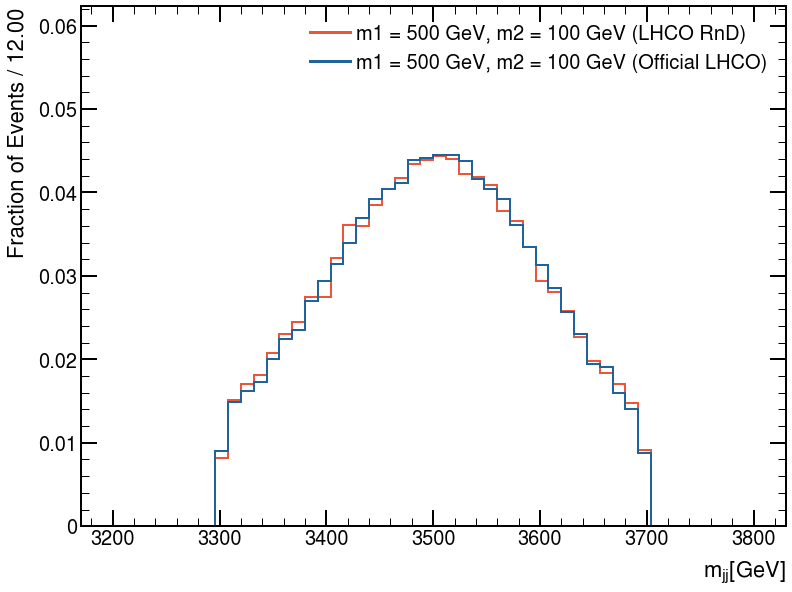

<Figure size 640x480 with 0 Axes>

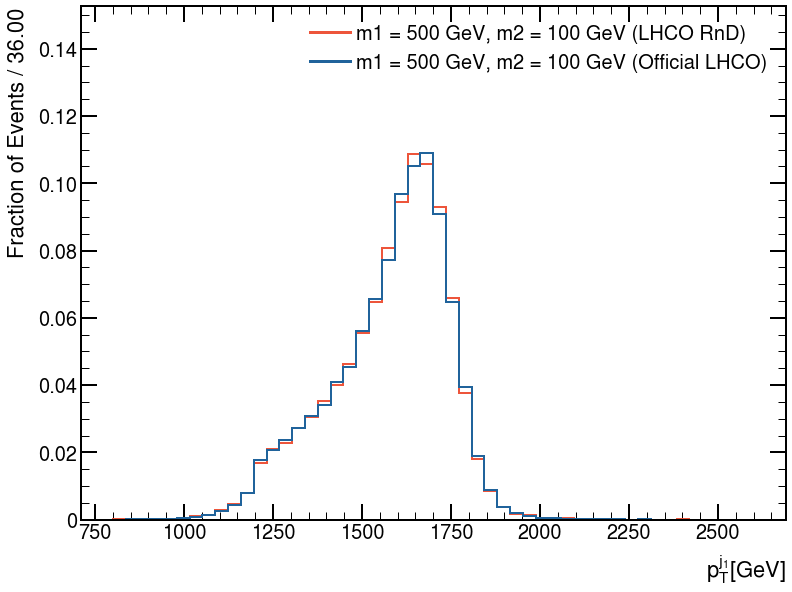

<Figure size 640x480 with 0 Axes>

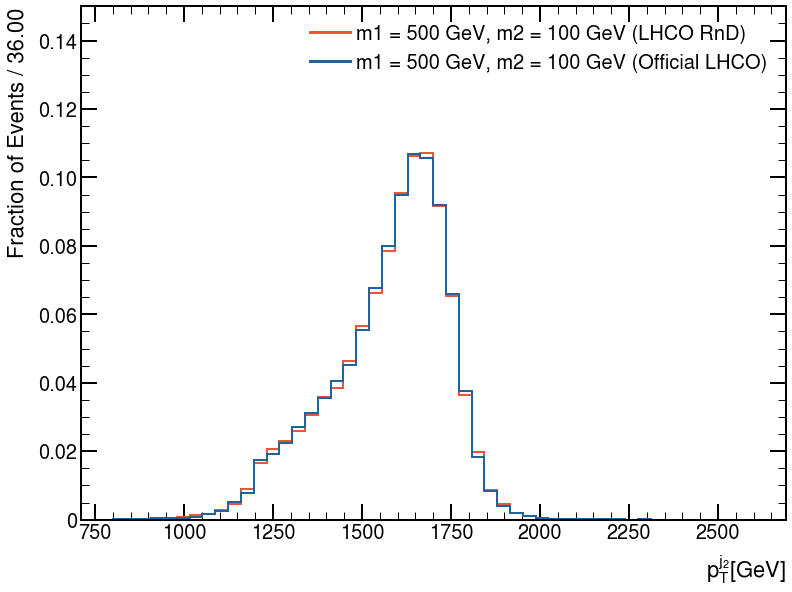

<Figure size 640x480 with 0 Axes>

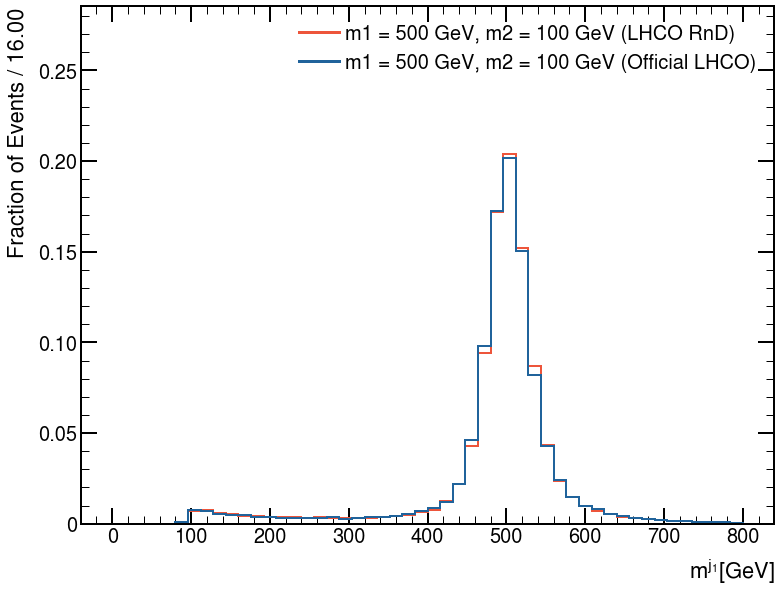

<Figure size 640x480 with 0 Axes>

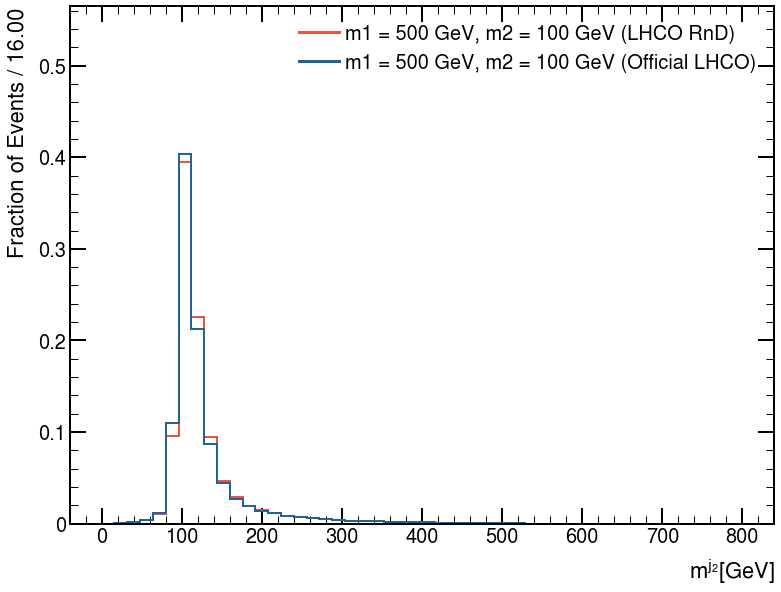

[INFO] Using deduced bin range (-2.134, 2.112)


<Figure size 640x480 with 0 Axes>

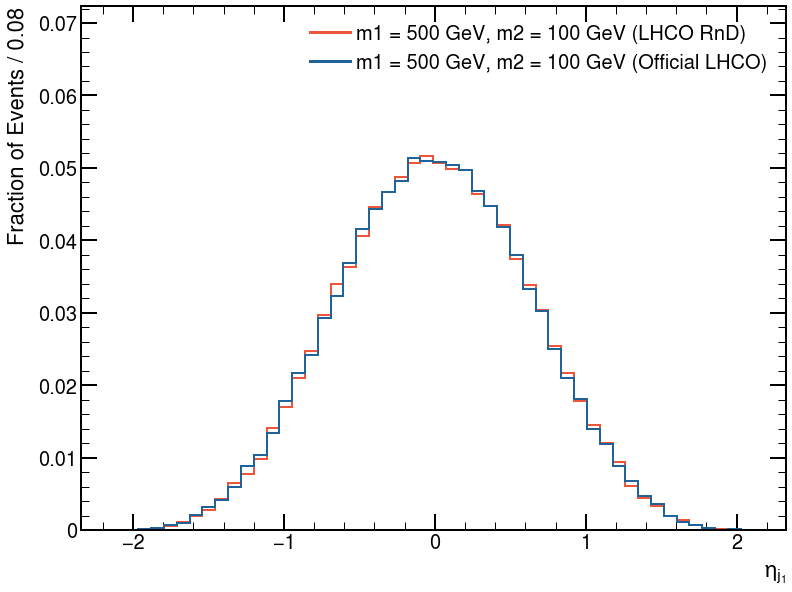

[INFO] Using deduced bin range (-2.326, 2.179)


<Figure size 640x480 with 0 Axes>

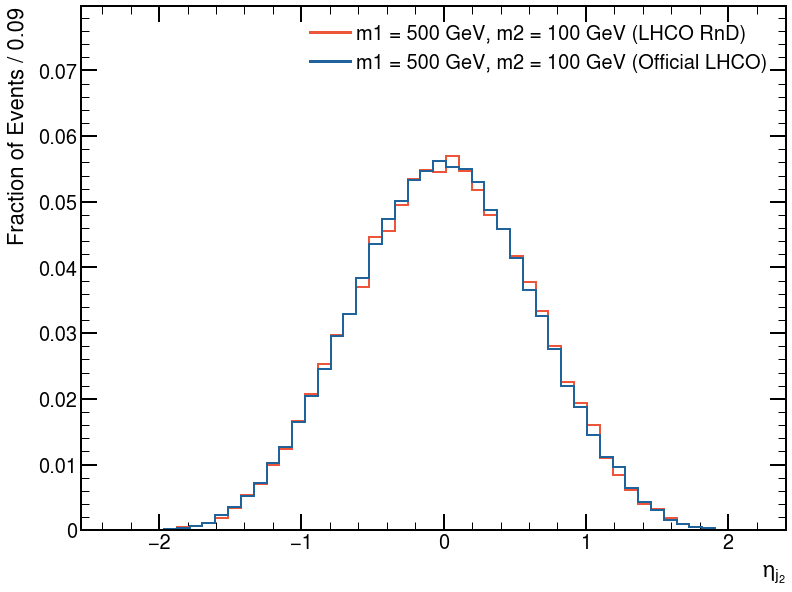

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

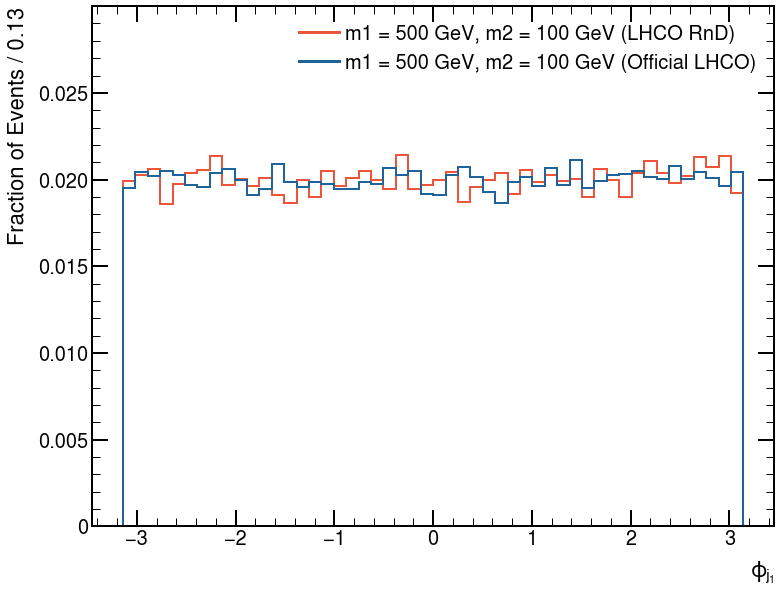

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

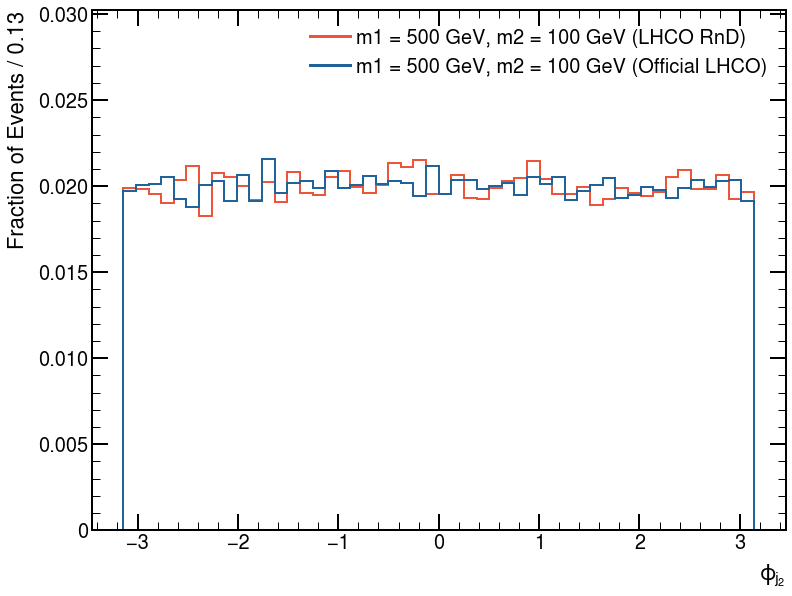

[INFO] Using deduced bin range (12.000, 190.000)


<Figure size 640x480 with 0 Axes>

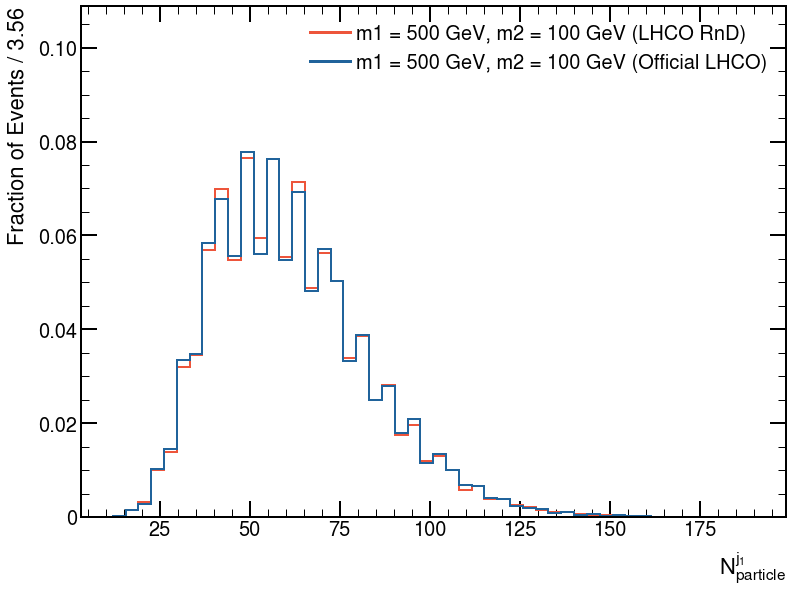

[INFO] Using deduced bin range (4.000, 175.000)


<Figure size 640x480 with 0 Axes>

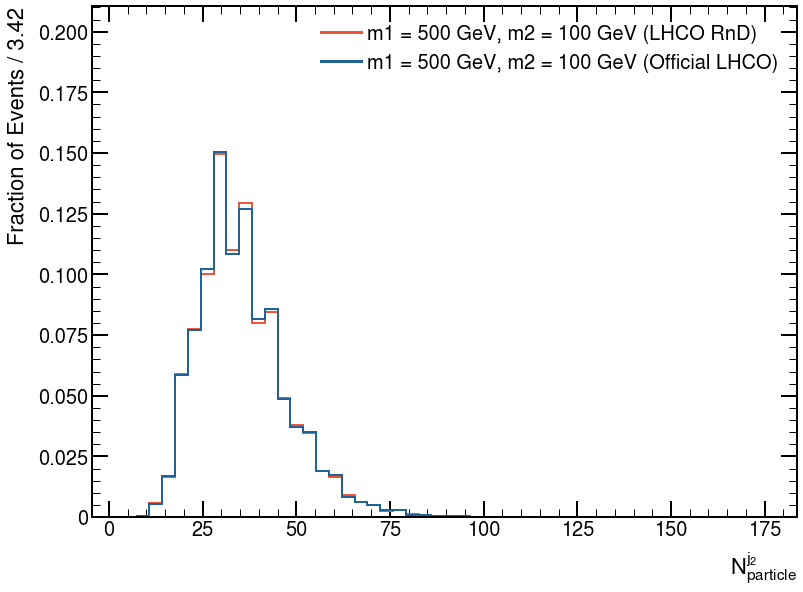

[INFO] Using deduced bin range (0.009, 1151.050)


<Figure size 640x480 with 0 Axes>

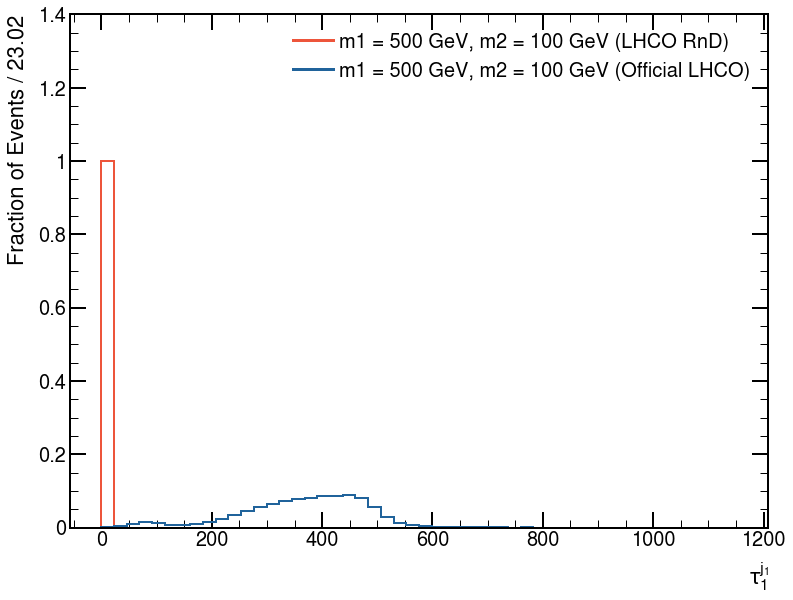

[INFO] Using deduced bin range (0.003, 681.842)


<Figure size 640x480 with 0 Axes>

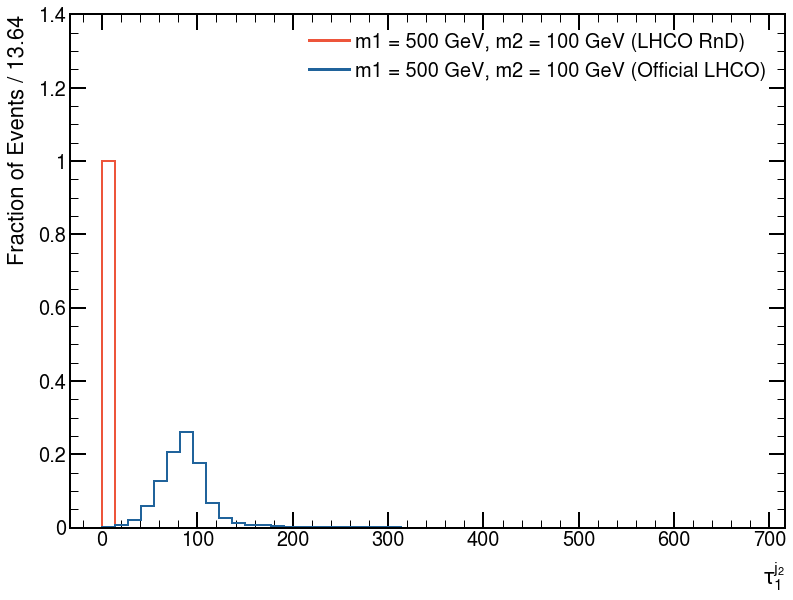

[INFO] Using deduced bin range (0.003, 521.916)


<Figure size 640x480 with 0 Axes>

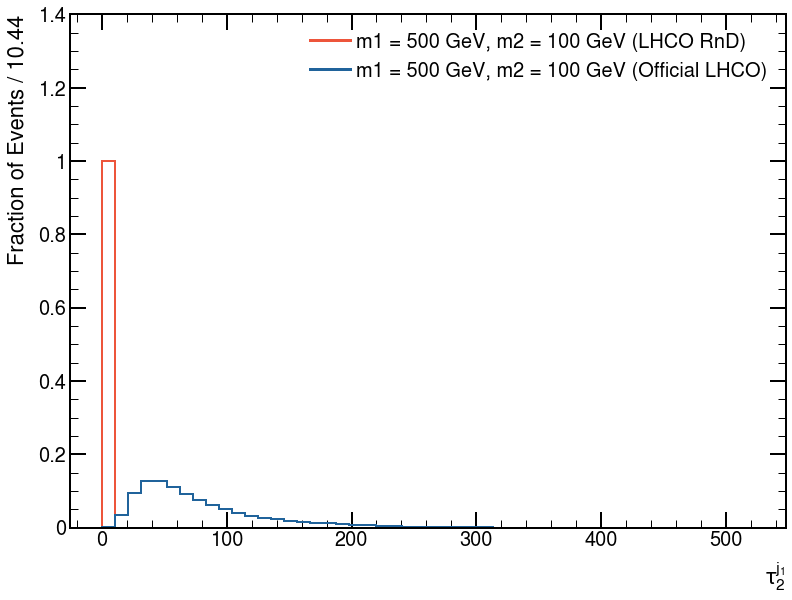

[INFO] Using deduced bin range (0.002, 248.643)


<Figure size 640x480 with 0 Axes>

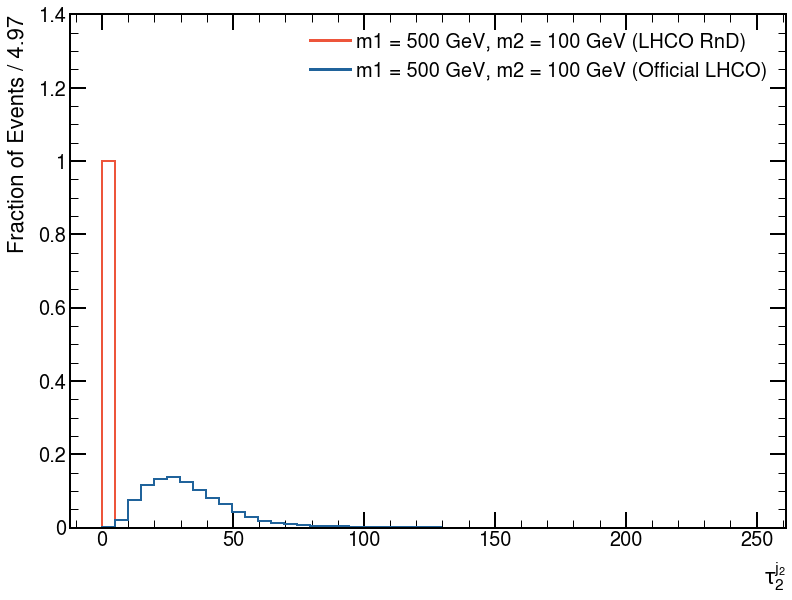

[INFO] Using deduced bin range (0.002, 272.331)


<Figure size 640x480 with 0 Axes>

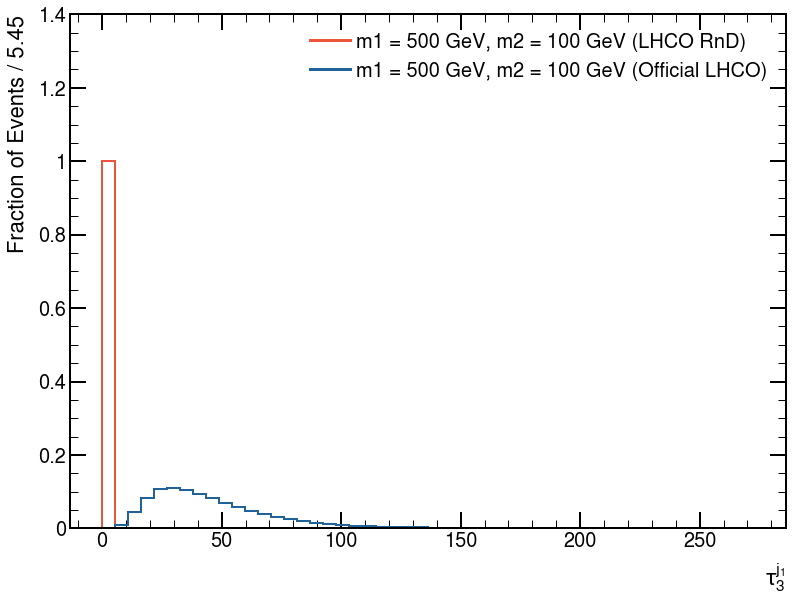

[INFO] Using deduced bin range (0.001, 183.633)


<Figure size 640x480 with 0 Axes>

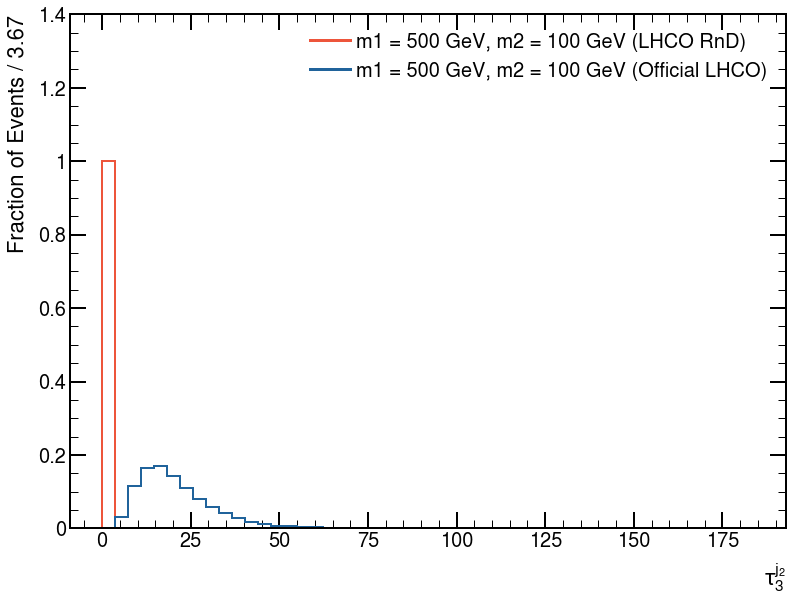

[INFO] Using deduced bin range (0.015, 0.963)


<Figure size 640x480 with 0 Axes>

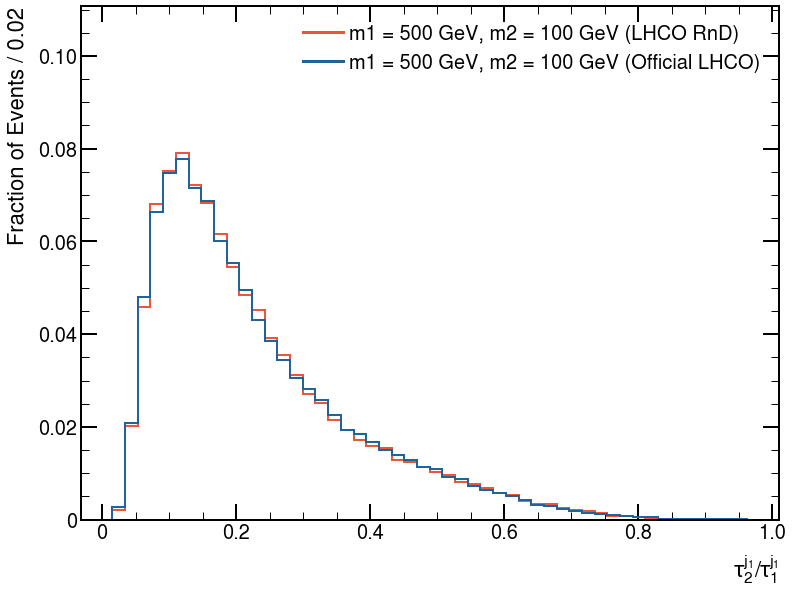

[INFO] Using deduced bin range (0.008, 0.979)


<Figure size 640x480 with 0 Axes>

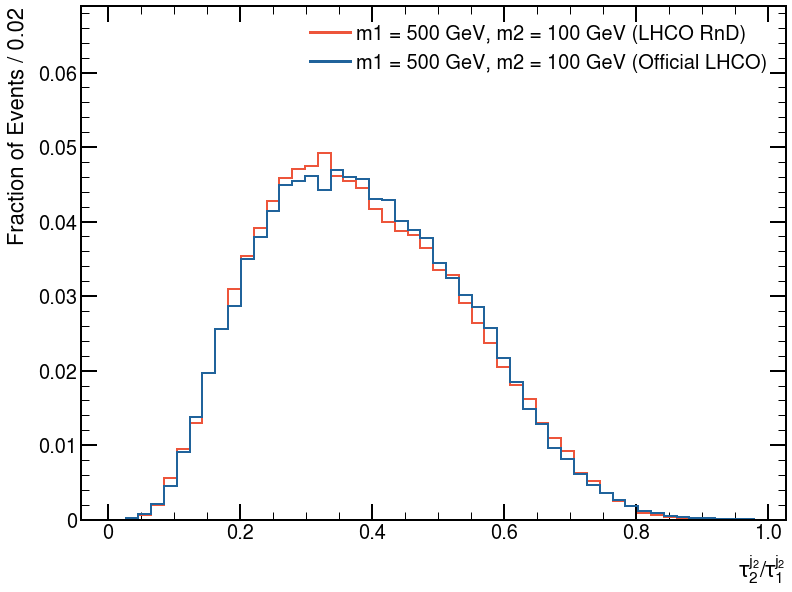

[INFO] Using deduced bin range (0.035, 0.994)


<Figure size 640x480 with 0 Axes>

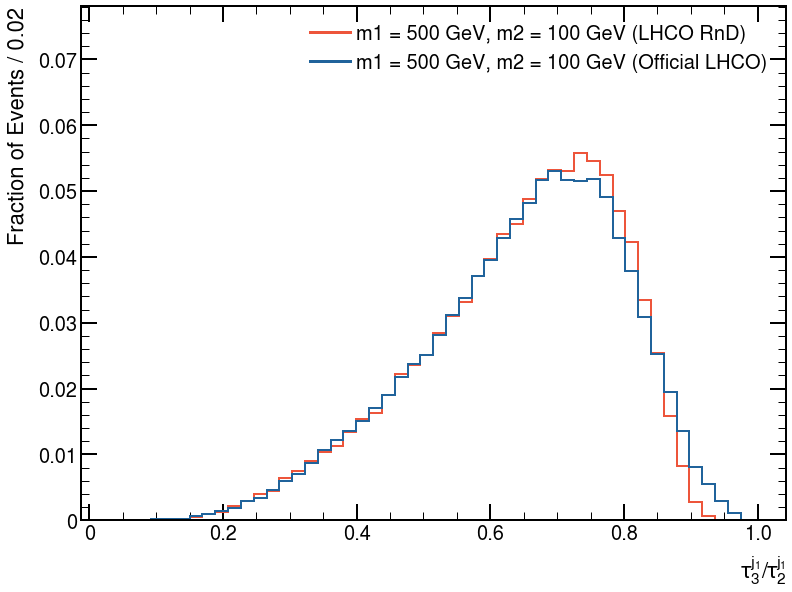

[INFO] Using deduced bin range (0.041, 0.991)


<Figure size 640x480 with 0 Axes>

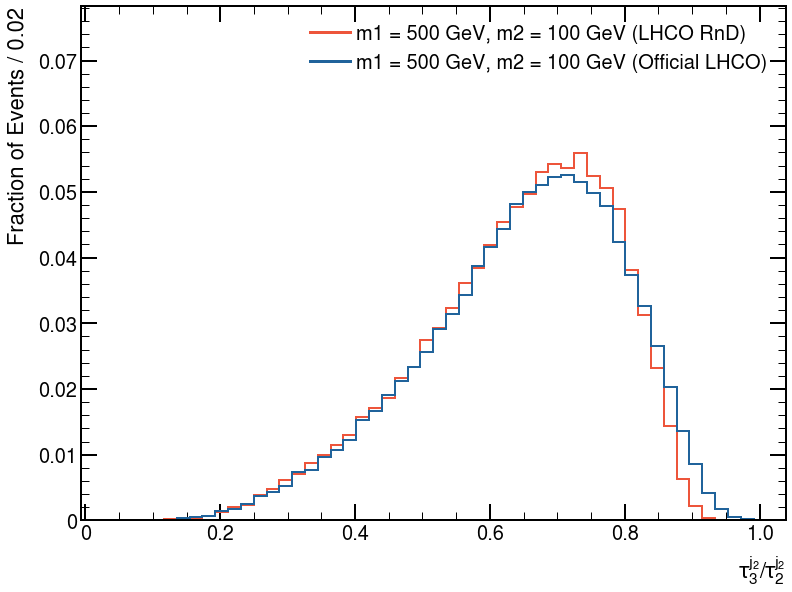

In [17]:
for column in options:
    plotter.draw(column,
                 targets=['500_100', '500_100_LHCO'],
                 **options[column],
                 bins=50,
                 normalize=True,
                 ypad=0.25)
    plt.show()

## Comparison between 2-prong and 3-prong decays

In [36]:
import os
import pandas as pd
mass_points = ["500_100", "100_500", "250_250"]
basedir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/"
filepaths = {
    "2prong": os.path.join(basedir, "LHCO_RnD_qq", "parquet", "col_based", "SR_point_cloud_W_qq_{mass_point}.parquet"),
    "3prong": os.path.join(basedir, "LHCO_RnD_qqq", "parquet", "col_based", "SR_point_cloud_W_qqq_{mass_point}.parquet"),
}
dfs = {}

def get_feature_df(feature_arrays):
    data = {
        "lead_jet_pt"    : np.array(feature_arrays["j1"]["jet_pt"]),
        "lead_jet_eta"   : np.array(feature_arrays["j1"]["jet_eta"]),
        "lead_jet_phi"   : np.array(feature_arrays["j1"]["jet_phi"]),
        "lead_jet_m"     : np.array(feature_arrays["j1"]["jet_m"]),
        "lead_jet_N"     : np.array(feature_arrays["j1"]["N"]),
        "lead_jet_tau1"  : np.array(feature_arrays["j1"]["tau1"]),
        "lead_jet_tau2"  : np.array(feature_arrays["j1"]["tau2"]),
        "lead_jet_tau3"  : np.array(feature_arrays["j1"]["tau3"]),
        "lead_jet_tau12" : np.array(feature_arrays["j1"]["tau12"]),
        "lead_jet_tau23" : np.array(feature_arrays["j1"]["tau23"]),
        "sub_jet_pt"     : np.array(feature_arrays["j2"]["jet_pt"]),
        "sub_jet_eta"    : np.array(feature_arrays["j2"]["jet_eta"]),
        "sub_jet_phi"    : np.array(feature_arrays["j2"]["jet_phi"]),
        "sub_jet_m"      : np.array(feature_arrays["j2"]["jet_m"]),
        "sub_jet_N"      : np.array(feature_arrays["j2"]["N"]),
        "sub_jet_tau1"   : np.array(feature_arrays["j2"]["tau1"]),
        "sub_jet_tau2"   : np.array(feature_arrays["j2"]["tau2"]),
        "sub_jet_tau3"   : np.array(feature_arrays["j2"]["tau3"]),
        "sub_jet_tau12"  : np.array(feature_arrays["j2"]["tau12"]),
        "sub_jet_tau23"  : np.array(feature_arrays["j2"]["tau23"]),
        "mjj"            : np.array(feature_arrays["jj"]["mjj"])
    }
    df = pd.DataFrame(data)
    return df
    
for mass_point in mass_points:
    dfs[mass_point] = {}
    for prongness in ["2prong", "3prong"]:
        filename = filepaths[prongness].format(mass_point=mass_point)
        feature_array = load_fn(filename)
        dfs[mass_point][prongness] = get_feature_df(feature_array)

<Figure size 640x480 with 0 Axes>

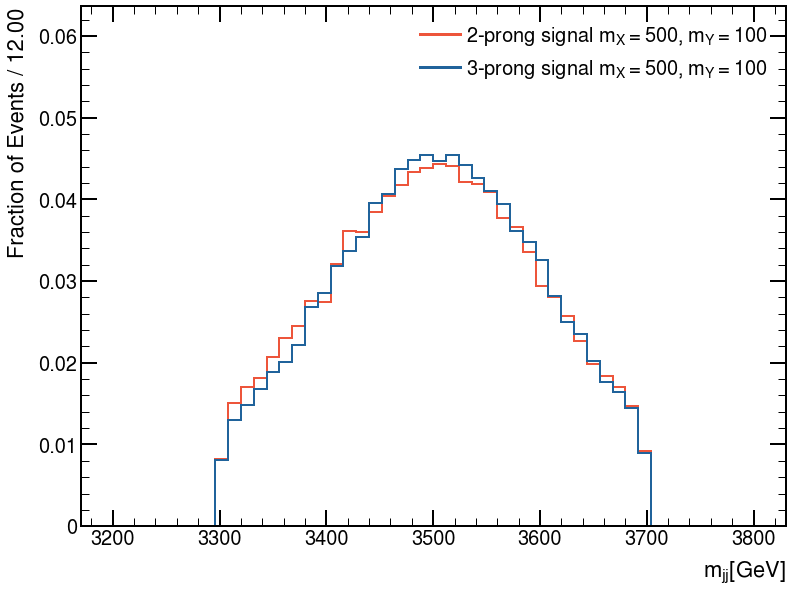

<Figure size 640x480 with 0 Axes>

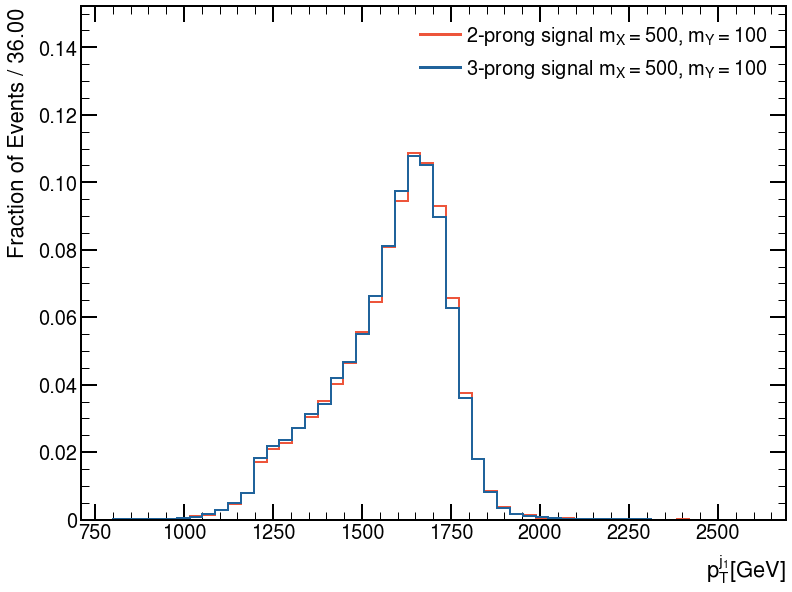

<Figure size 640x480 with 0 Axes>

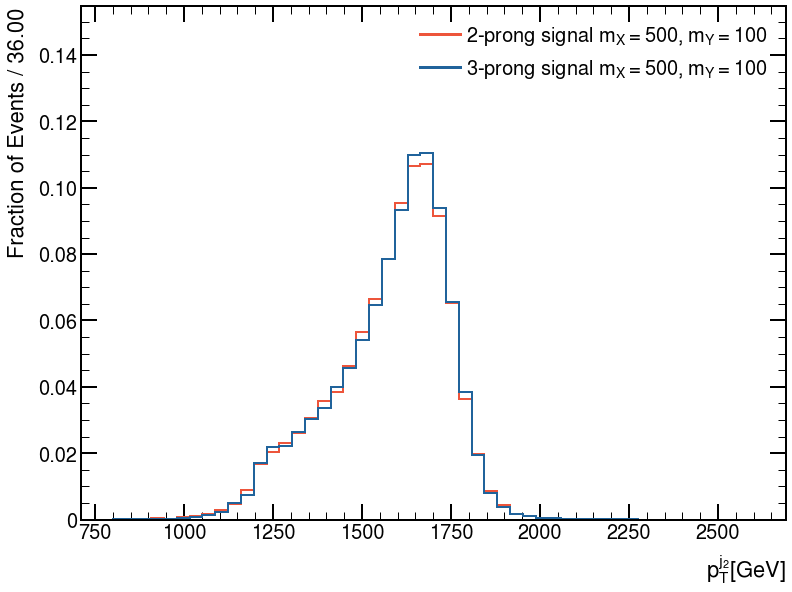

<Figure size 640x480 with 0 Axes>

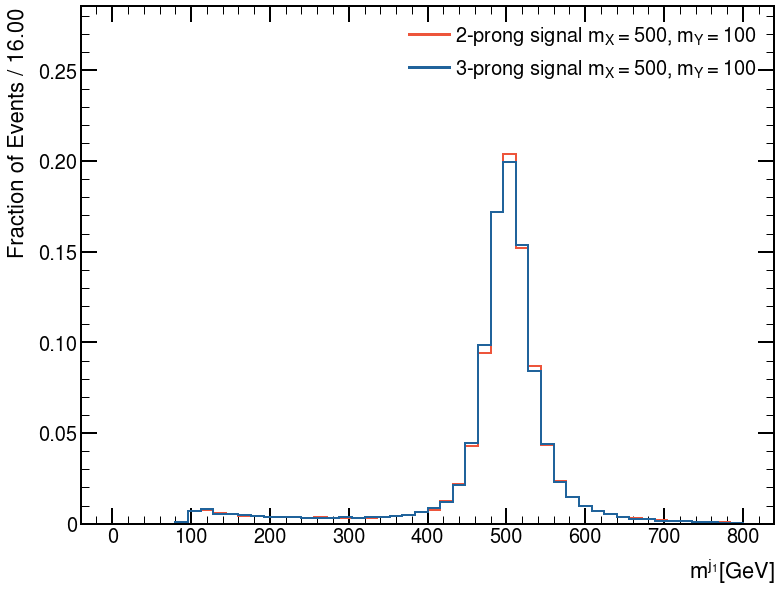

<Figure size 640x480 with 0 Axes>

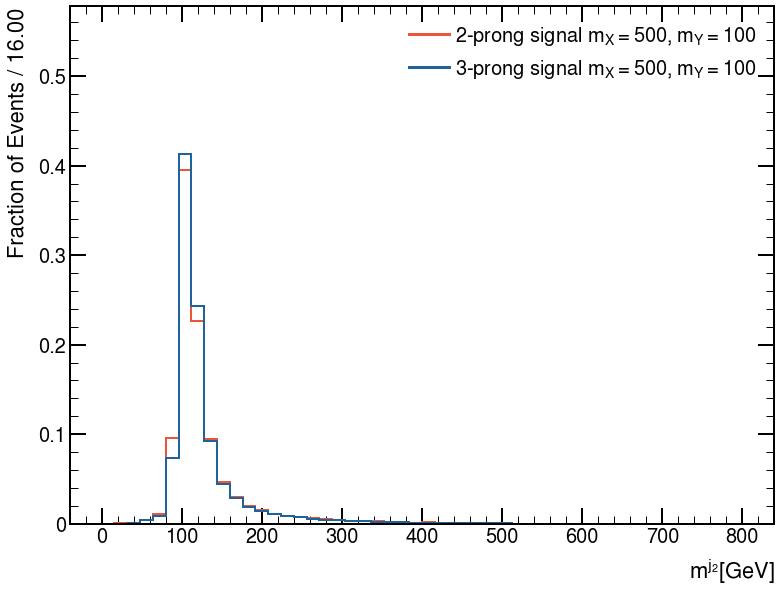

[INFO] Using deduced bin range (-2.002, 2.112)


<Figure size 640x480 with 0 Axes>

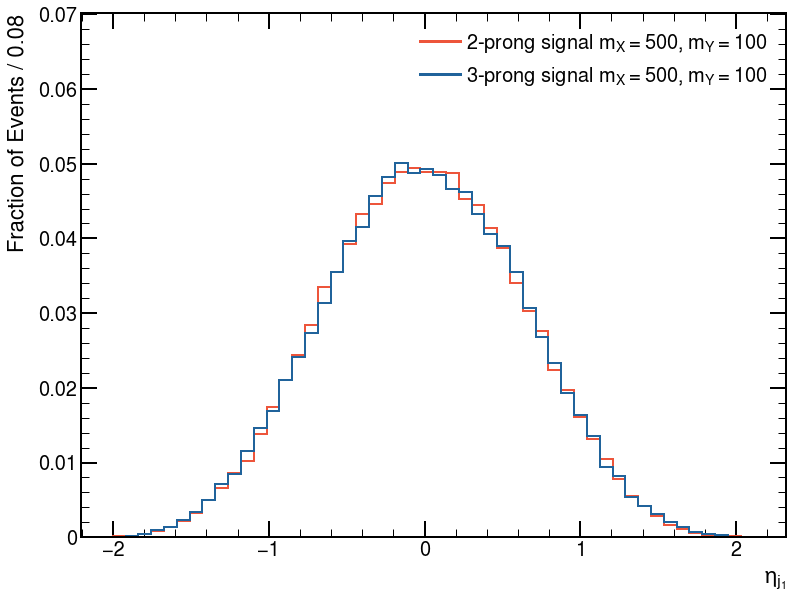

[INFO] Using deduced bin range (-2.326, 2.179)


<Figure size 640x480 with 0 Axes>

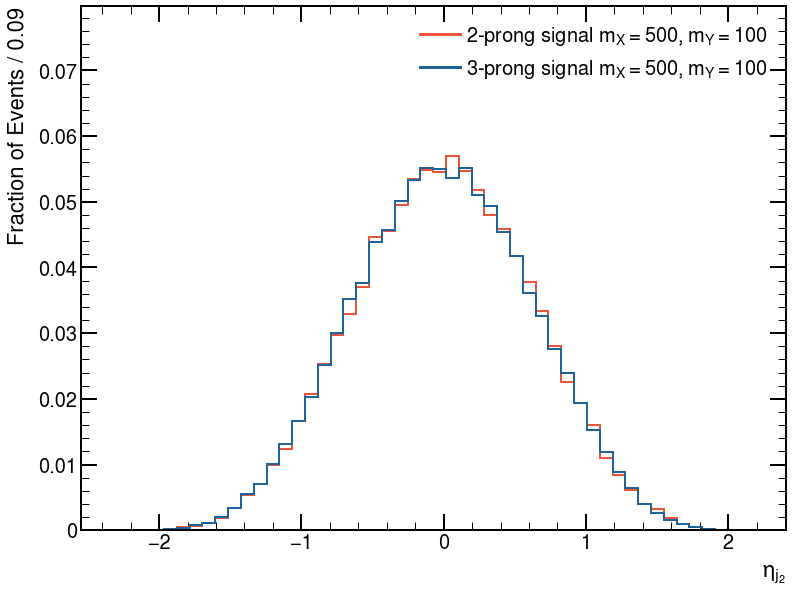

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

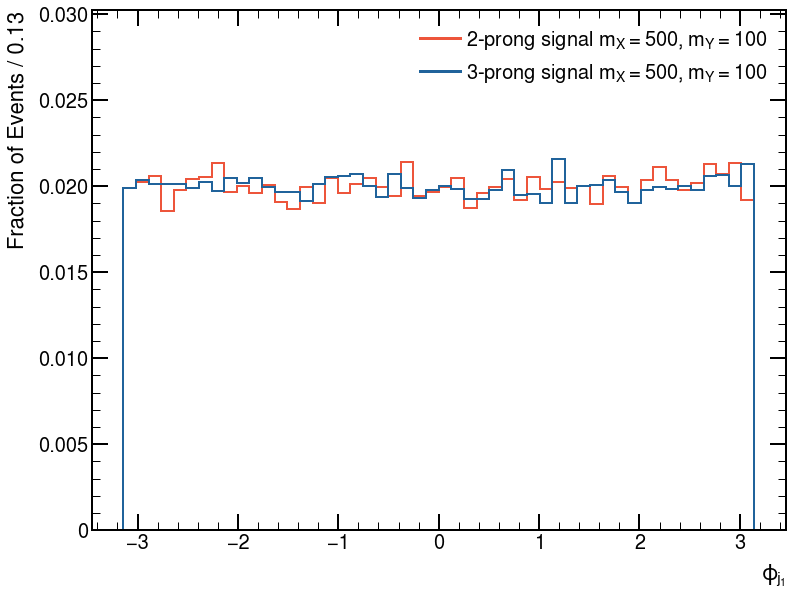

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

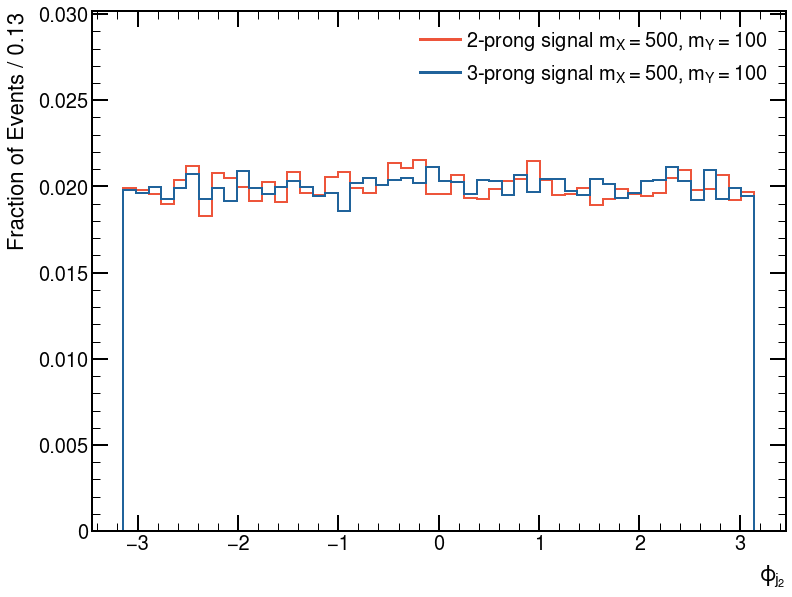

[INFO] Using deduced bin range (11.000, 218.000)


<Figure size 640x480 with 0 Axes>

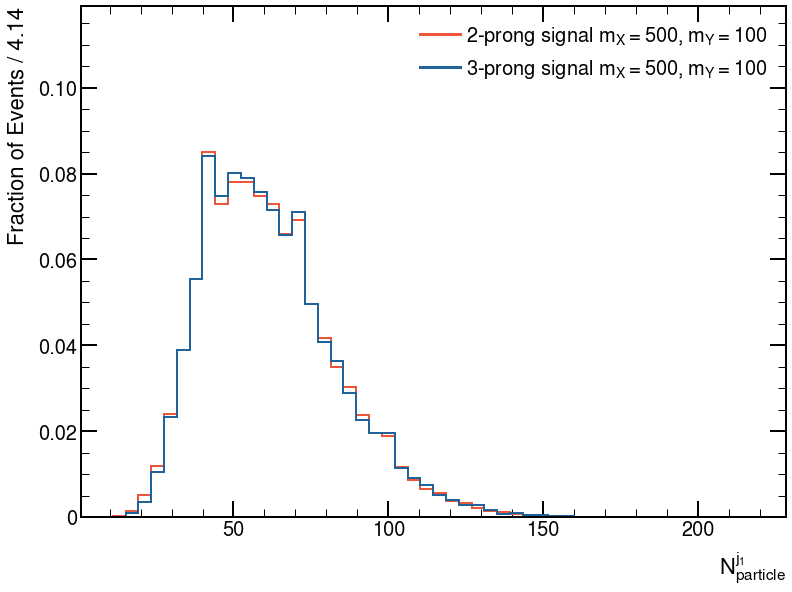

[INFO] Using deduced bin range (7.000, 138.000)


<Figure size 640x480 with 0 Axes>

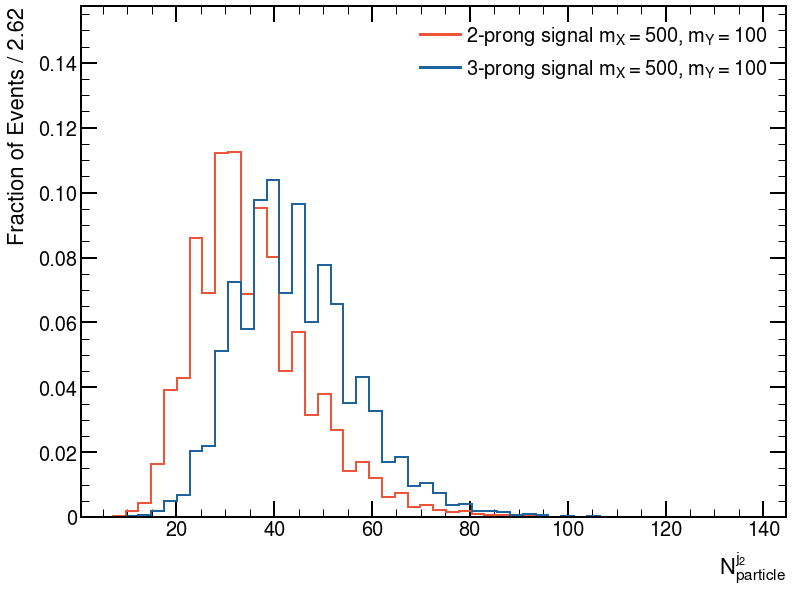

[INFO] Using deduced bin range (0.008, 0.662)


<Figure size 640x480 with 0 Axes>

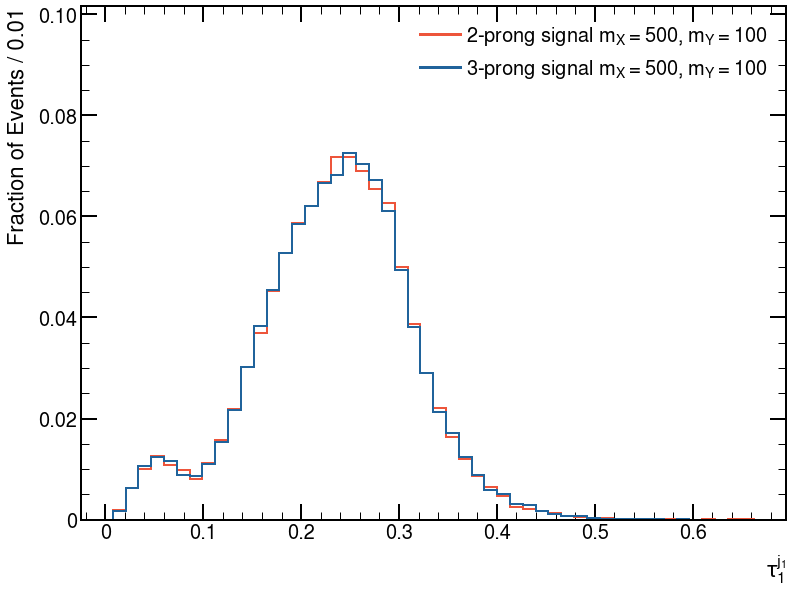

[INFO] Using deduced bin range (0.003, 0.377)


<Figure size 640x480 with 0 Axes>

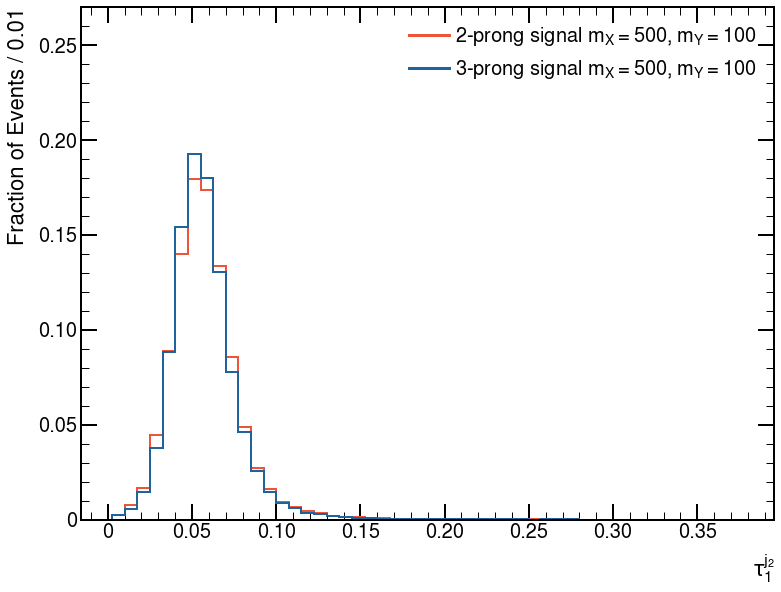

[INFO] Using deduced bin range (0.002, 0.310)


<Figure size 640x480 with 0 Axes>

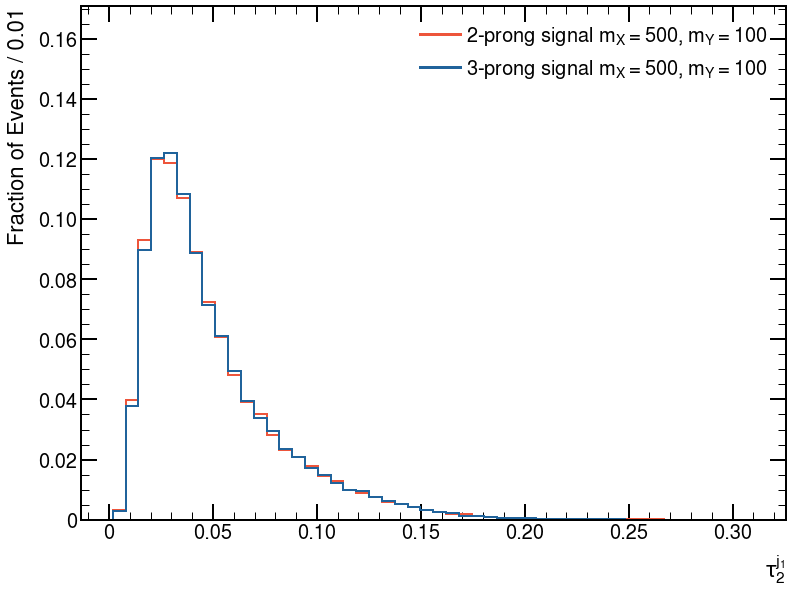

[INFO] Using deduced bin range (0.002, 0.169)


<Figure size 640x480 with 0 Axes>

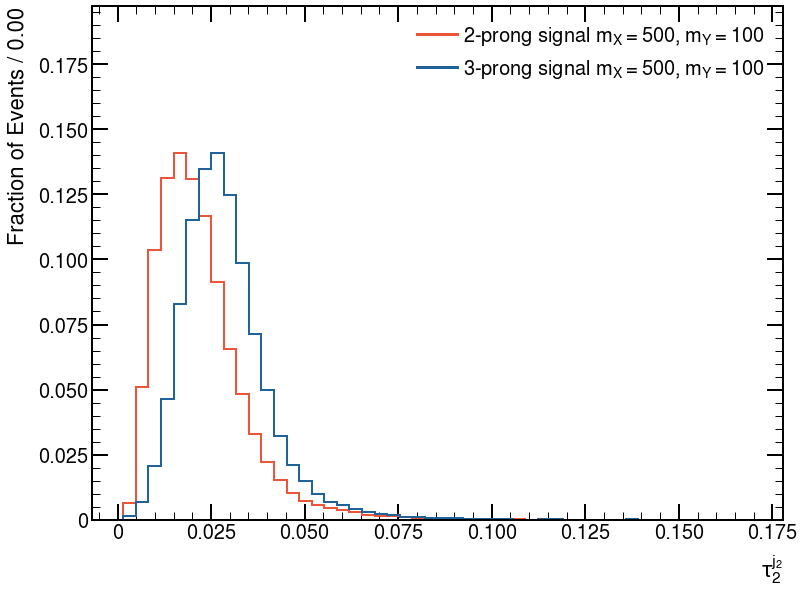

[INFO] Using deduced bin range (0.001, 0.174)


<Figure size 640x480 with 0 Axes>

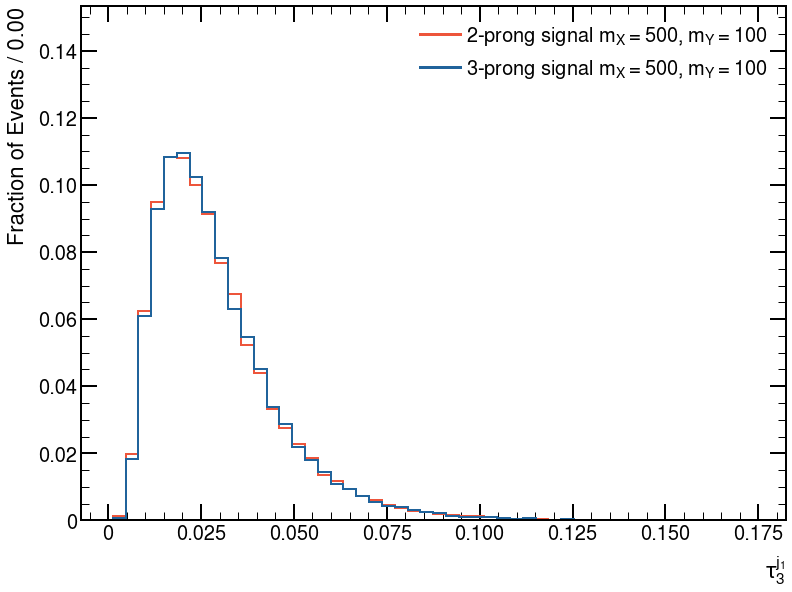

[INFO] Using deduced bin range (0.001, 0.110)


<Figure size 640x480 with 0 Axes>

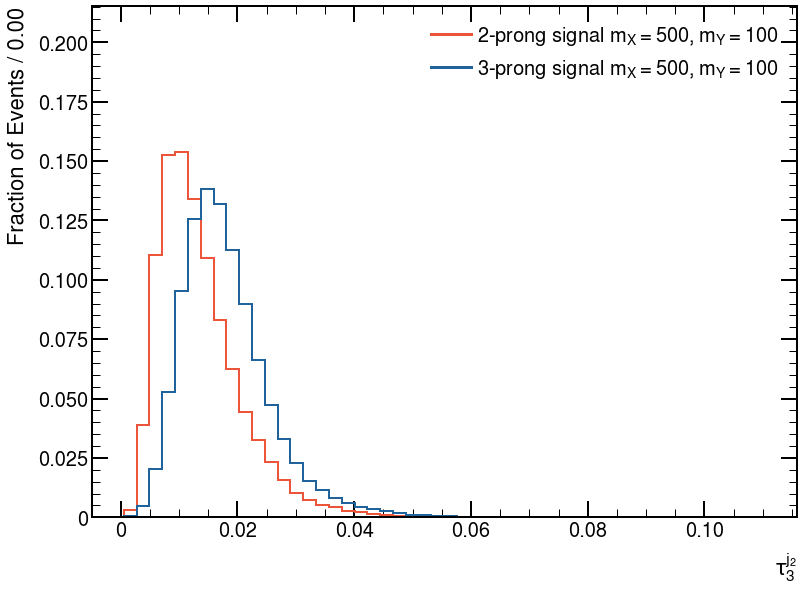

[INFO] Using deduced bin range (0.019, 0.885)


<Figure size 640x480 with 0 Axes>

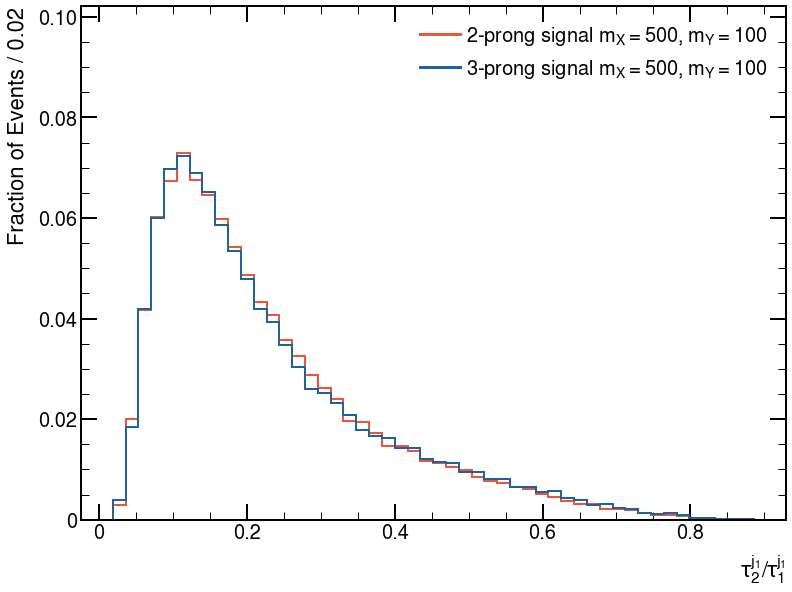

[INFO] Using deduced bin range (0.030, 0.908)


<Figure size 640x480 with 0 Axes>

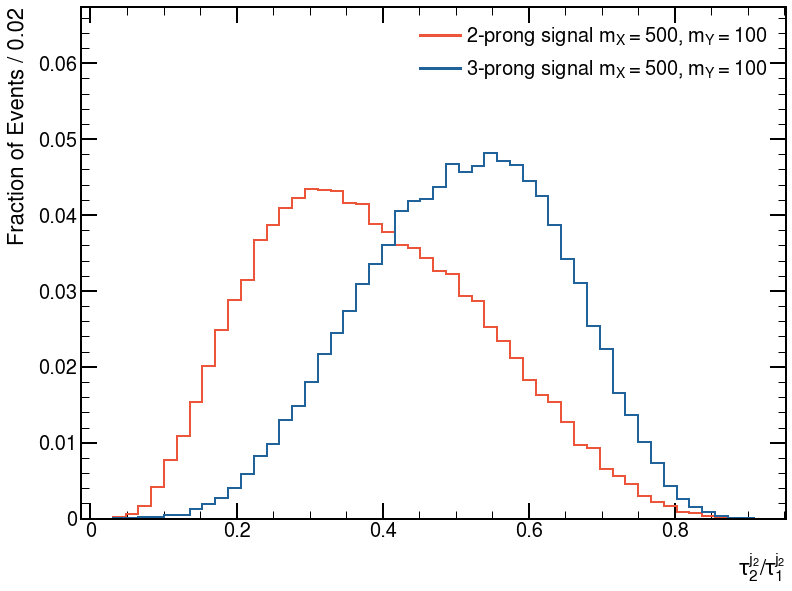

[INFO] Using deduced bin range (0.082, 0.937)


<Figure size 640x480 with 0 Axes>

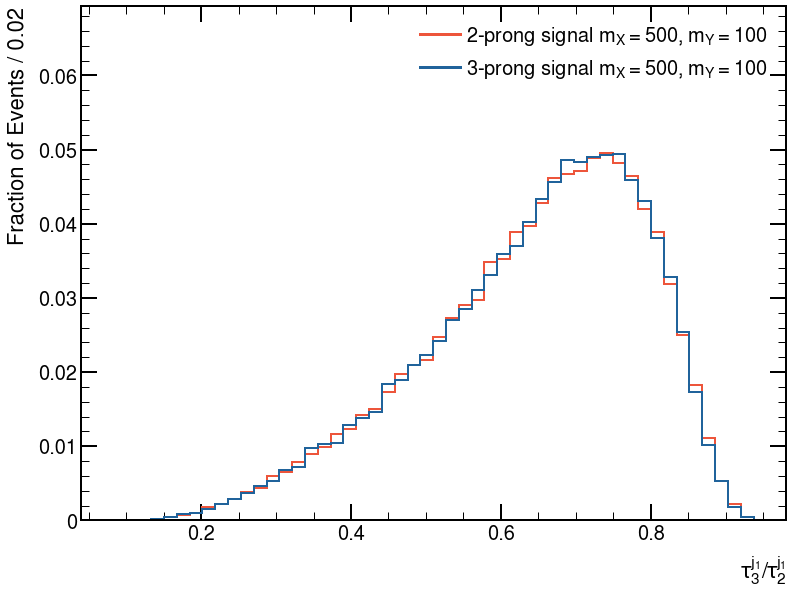

[INFO] Using deduced bin range (0.050, 0.937)


<Figure size 640x480 with 0 Axes>

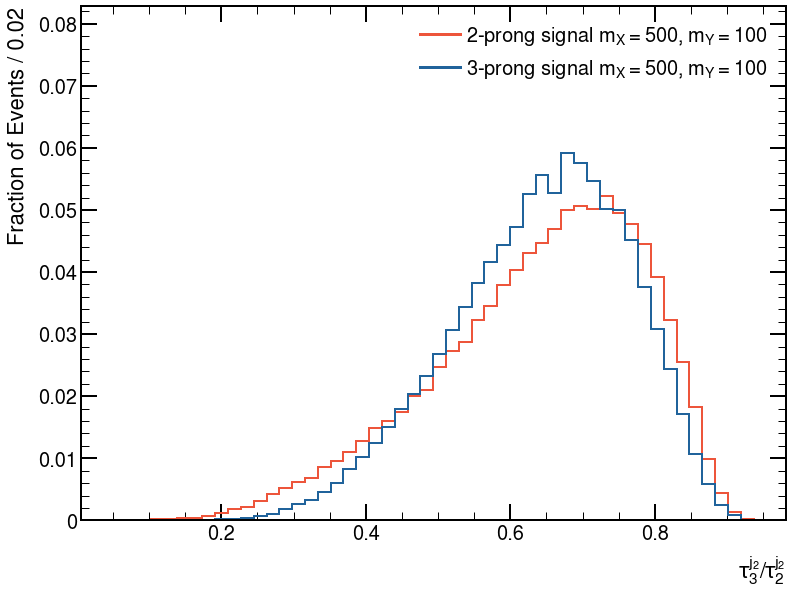

<Figure size 640x480 with 0 Axes>

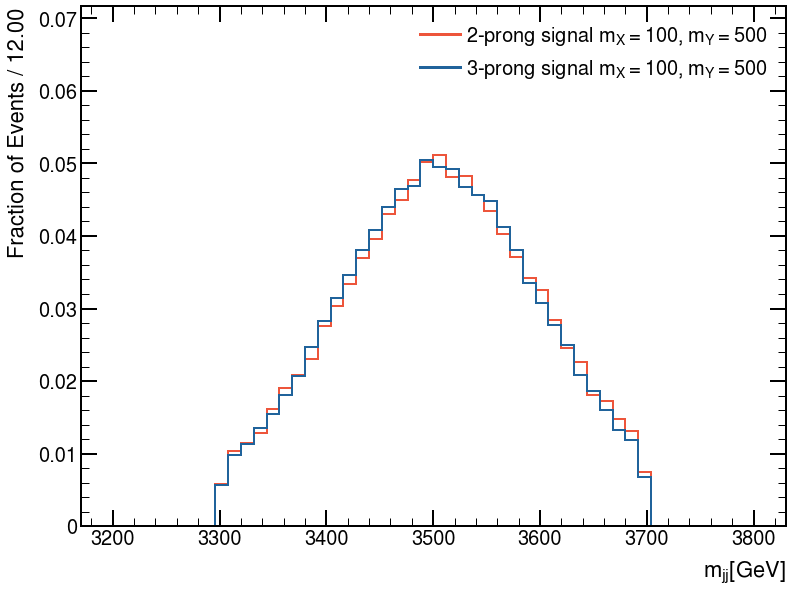

<Figure size 640x480 with 0 Axes>

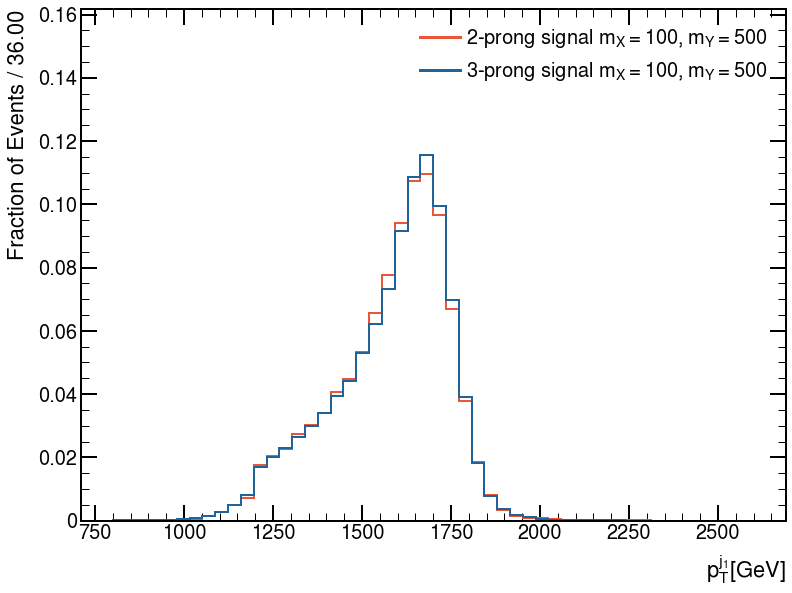

<Figure size 640x480 with 0 Axes>

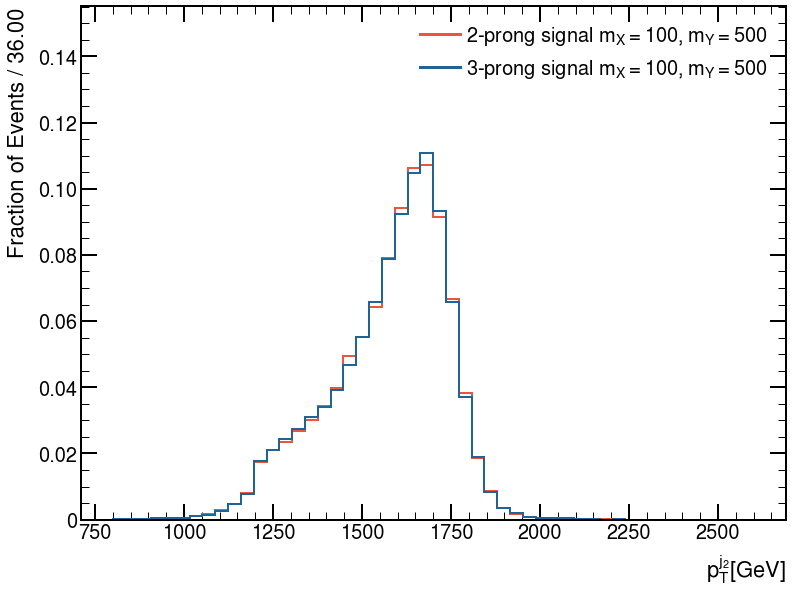

<Figure size 640x480 with 0 Axes>

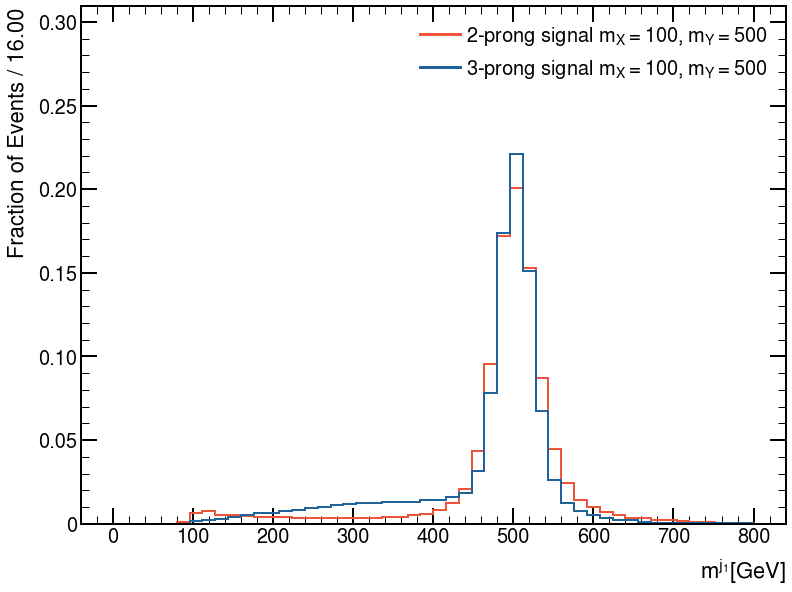

<Figure size 640x480 with 0 Axes>

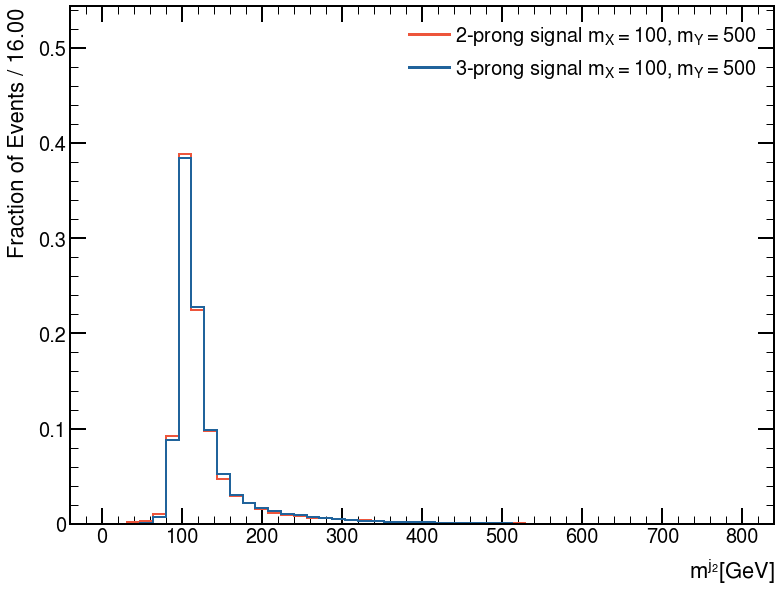

[INFO] Using deduced bin range (-2.065, 2.063)


<Figure size 640x480 with 0 Axes>

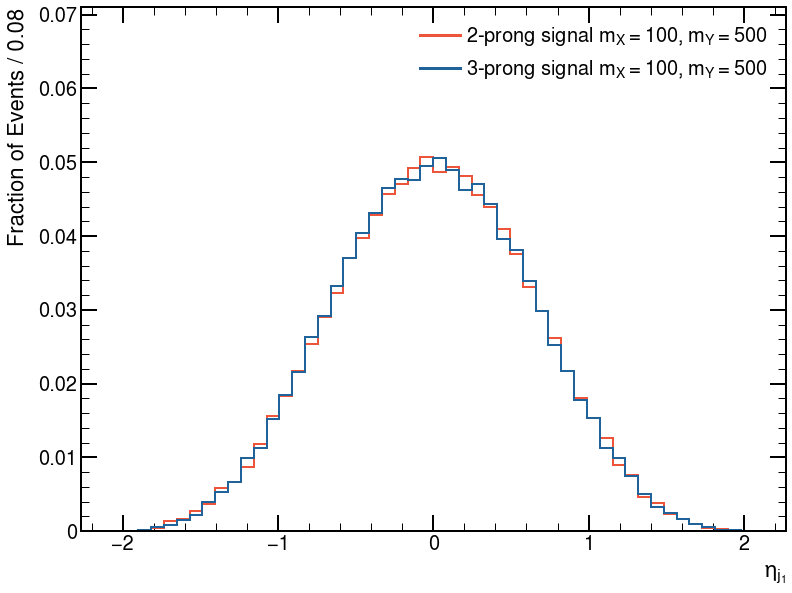

[INFO] Using deduced bin range (-3.041, 3.143)


<Figure size 640x480 with 0 Axes>

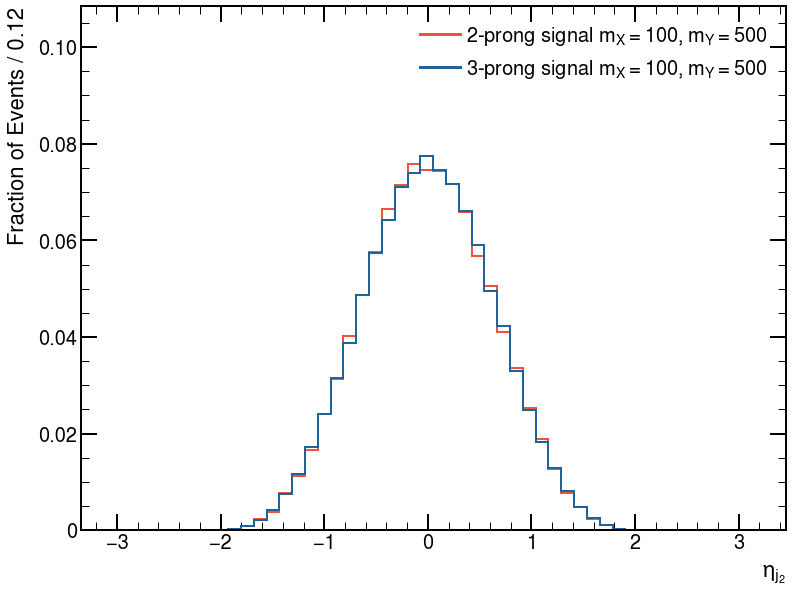

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

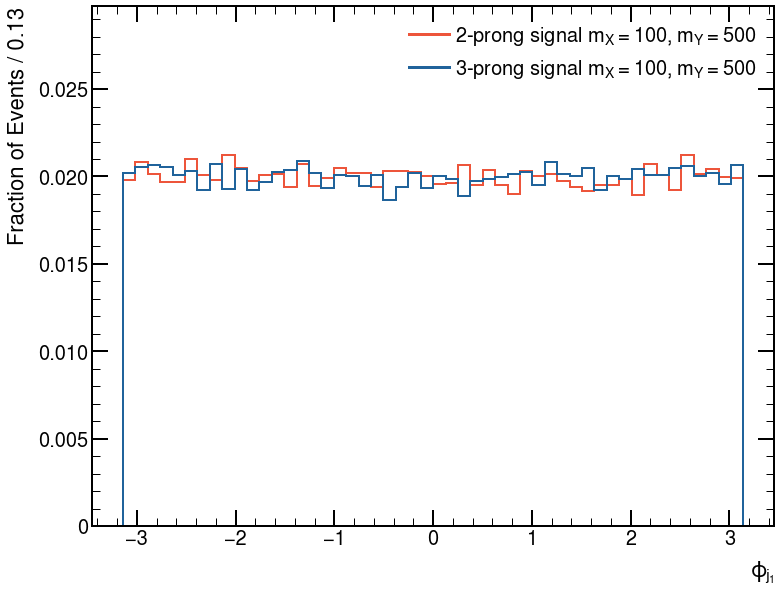

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

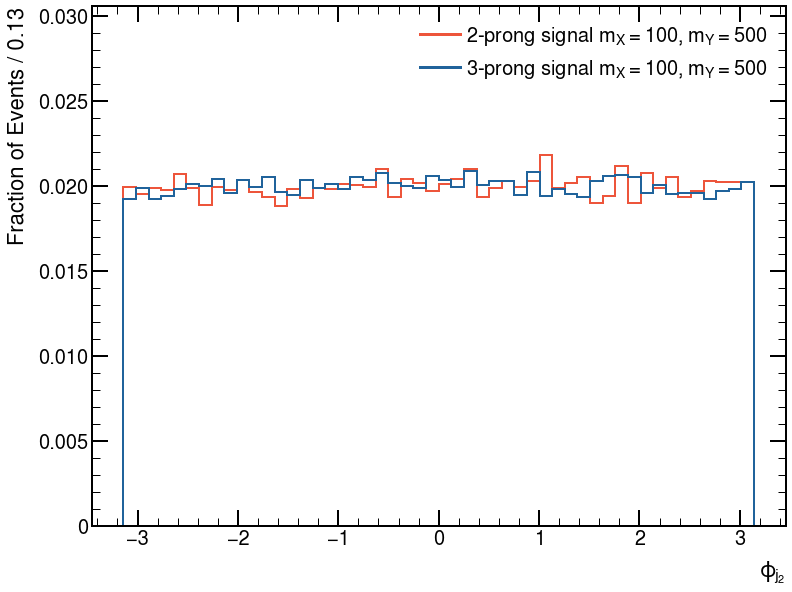

[INFO] Using deduced bin range (10.000, 215.000)


<Figure size 640x480 with 0 Axes>

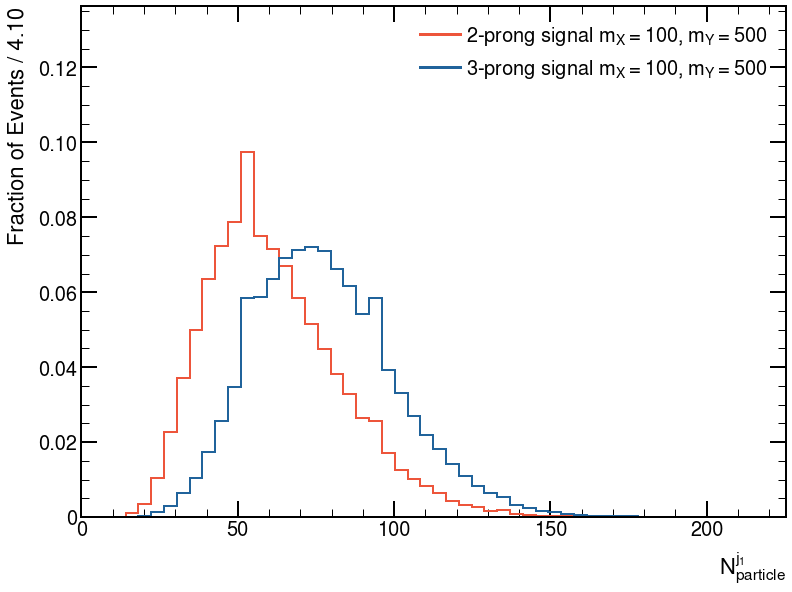

[INFO] Using deduced bin range (1.000, 150.000)


<Figure size 640x480 with 0 Axes>

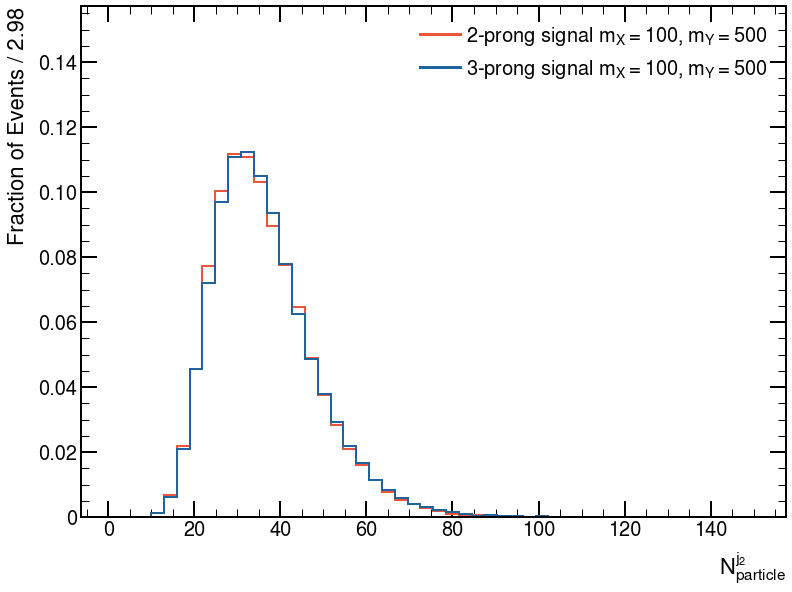

[INFO] Using deduced bin range (0.007, 0.780)


<Figure size 640x480 with 0 Axes>

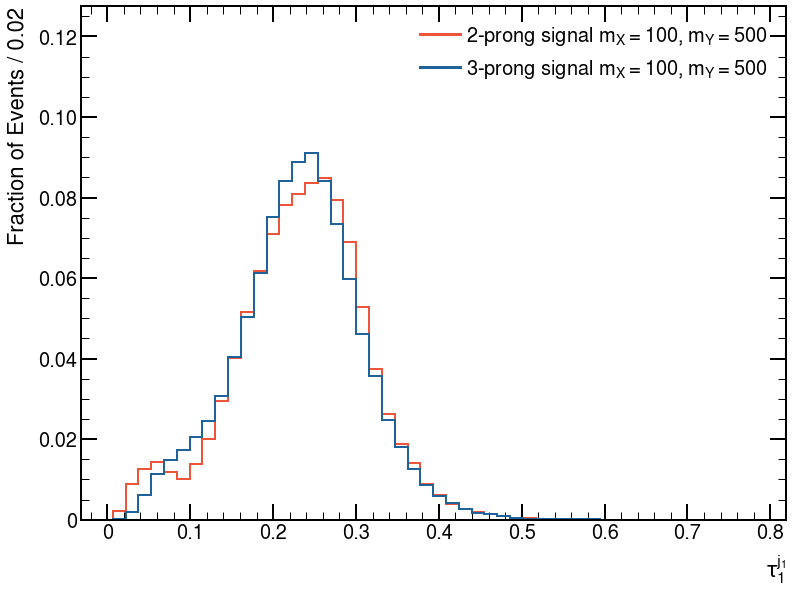

[INFO] Using deduced bin range (0.000, 0.428)


<Figure size 640x480 with 0 Axes>

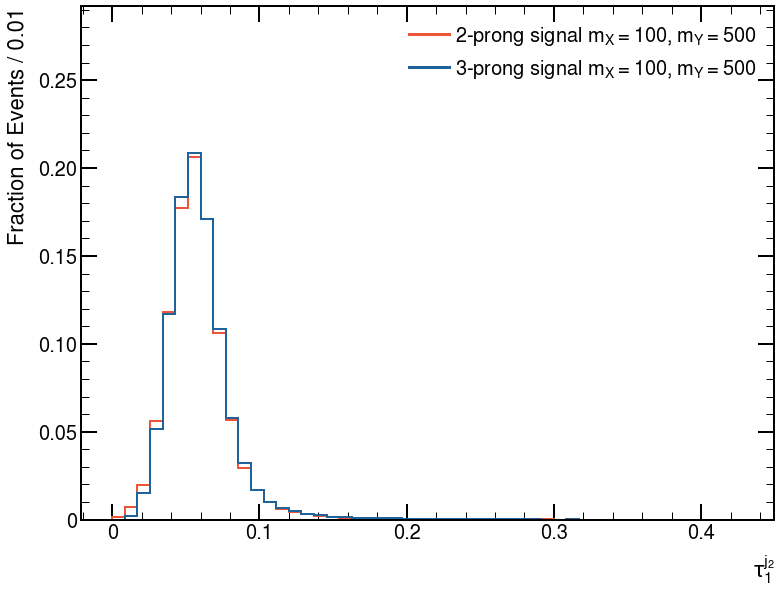

[INFO] Using deduced bin range (0.003, 0.325)


<Figure size 640x480 with 0 Axes>

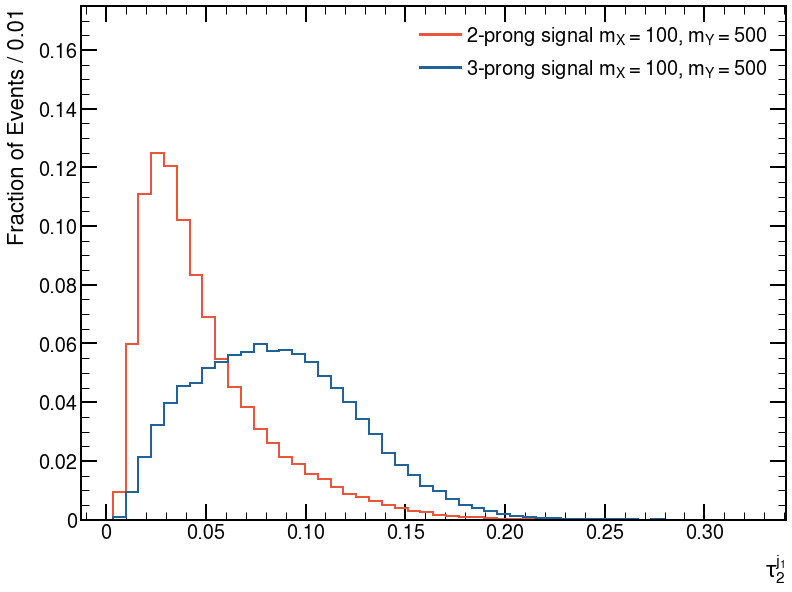

[INFO] Using deduced bin range (0.000, 0.187)


<Figure size 640x480 with 0 Axes>

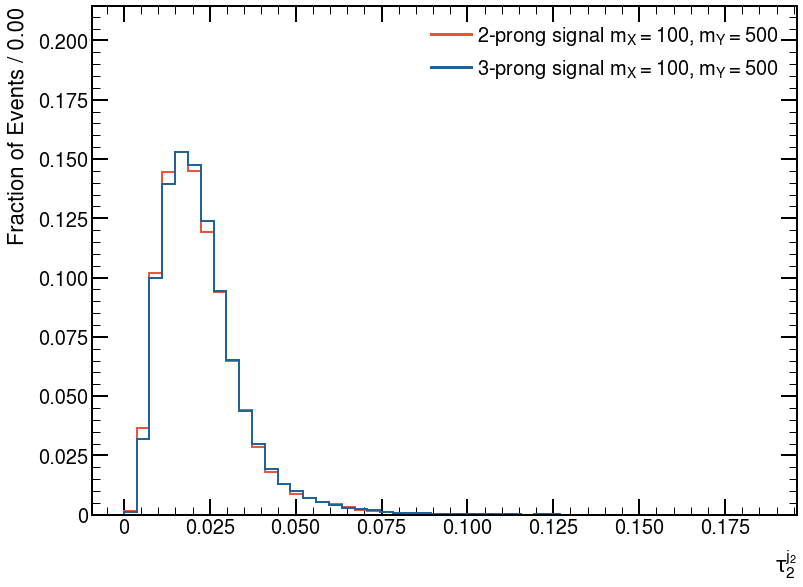

[INFO] Using deduced bin range (0.002, 0.207)


<Figure size 640x480 with 0 Axes>

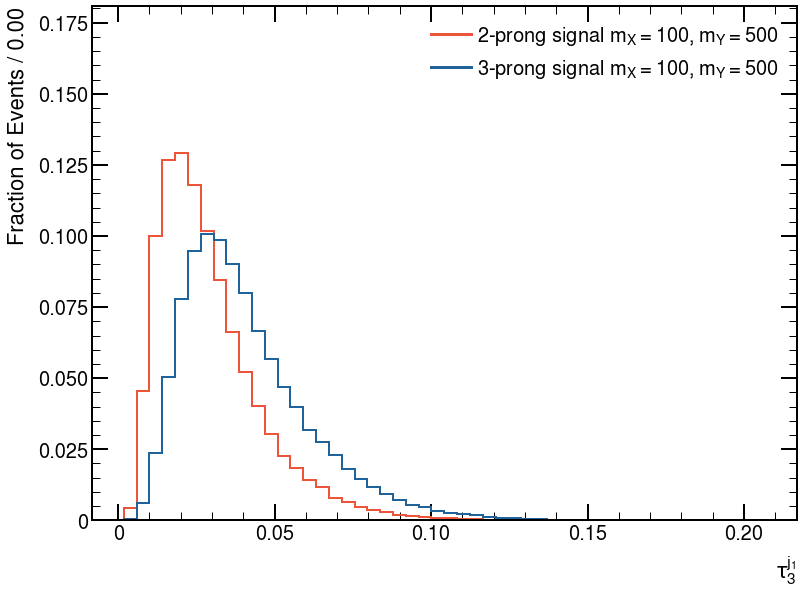

[INFO] Using deduced bin range (0.000, 0.113)


<Figure size 640x480 with 0 Axes>

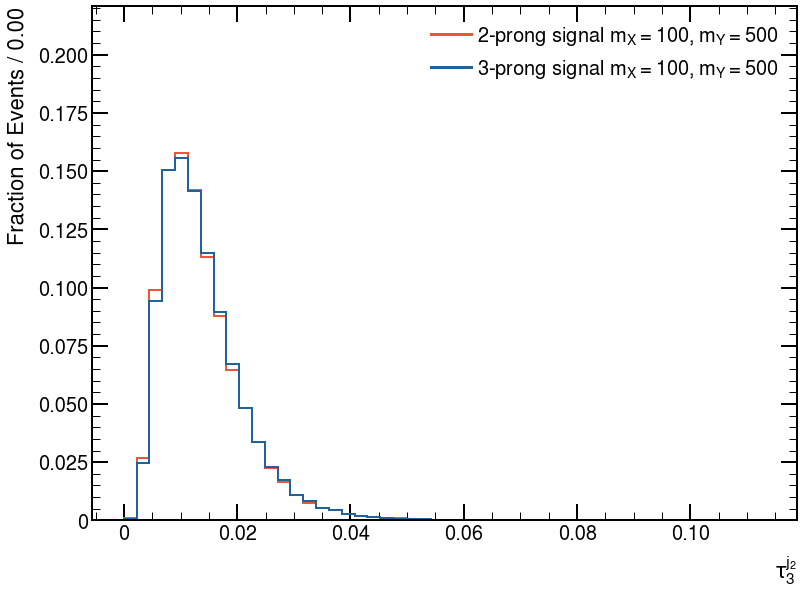

[INFO] Using deduced bin range (0.017, 0.895)


<Figure size 640x480 with 0 Axes>

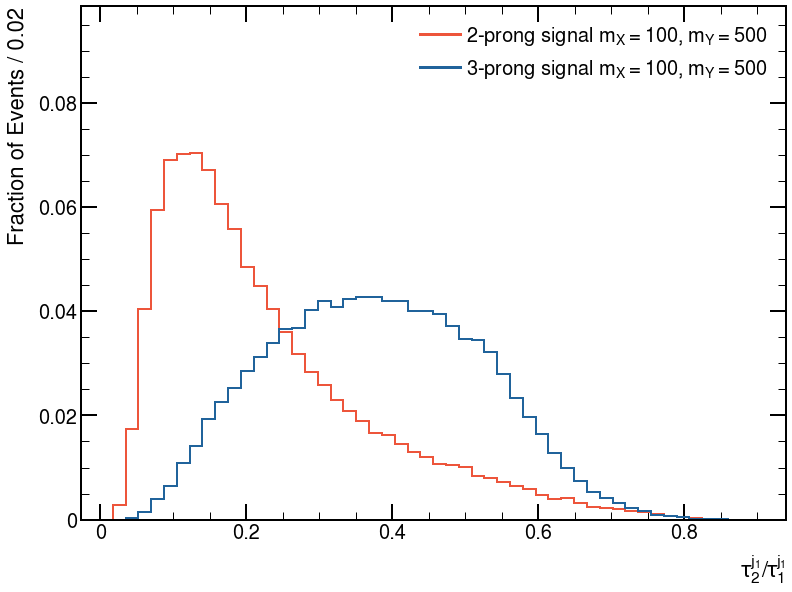

[INFO] Using deduced bin range (0.000, 0.888)


<Figure size 640x480 with 0 Axes>

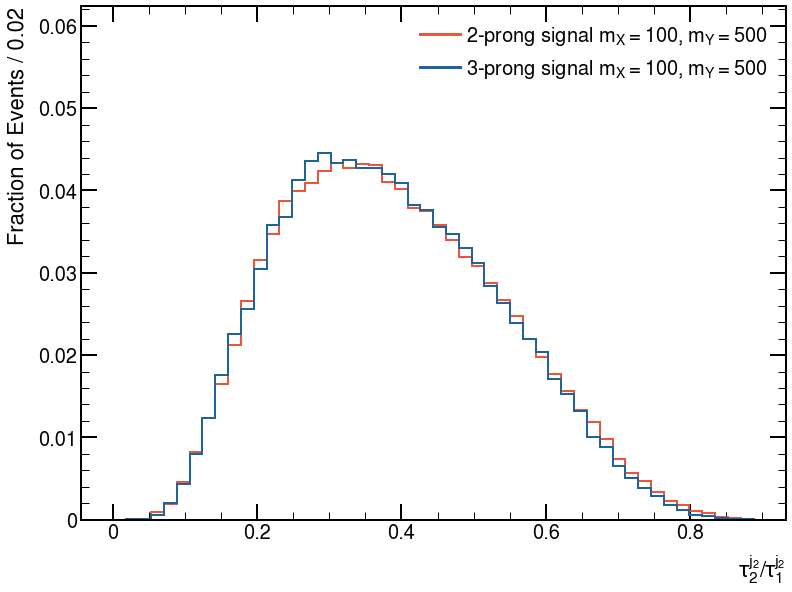

[INFO] Using deduced bin range (0.052, 0.943)


<Figure size 640x480 with 0 Axes>

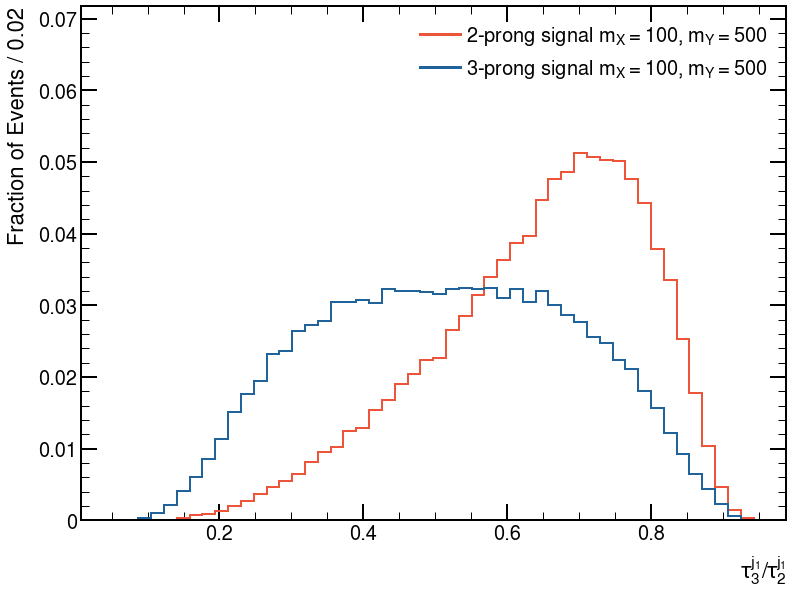

[INFO] Using deduced bin range (0.000, 0.937)


<Figure size 640x480 with 0 Axes>

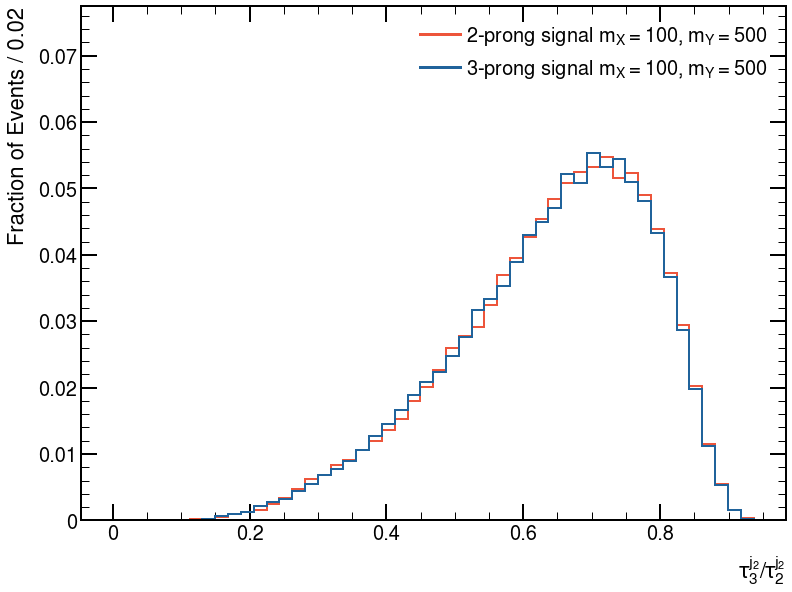

<Figure size 640x480 with 0 Axes>

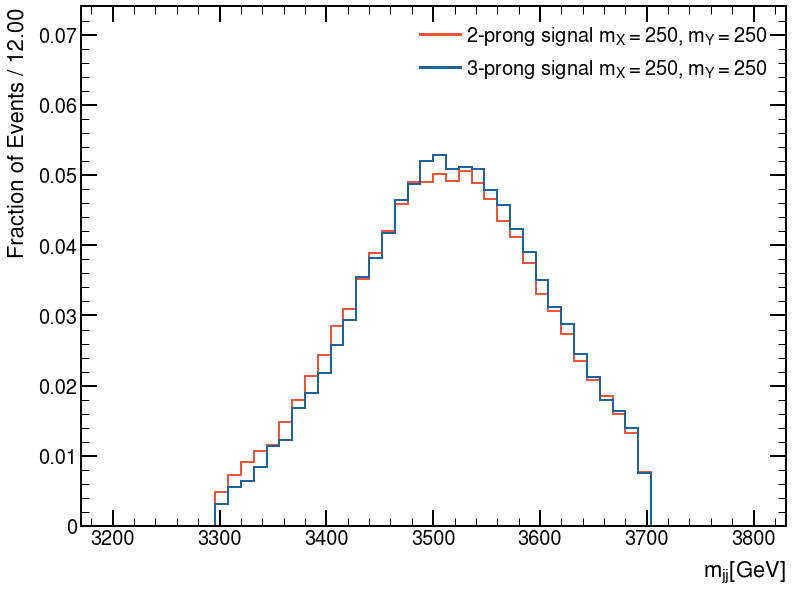

<Figure size 640x480 with 0 Axes>

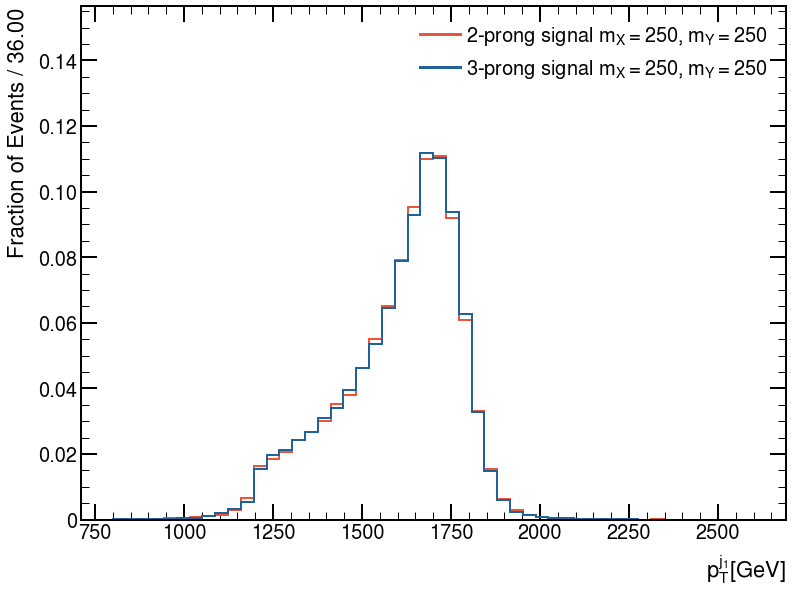

<Figure size 640x480 with 0 Axes>

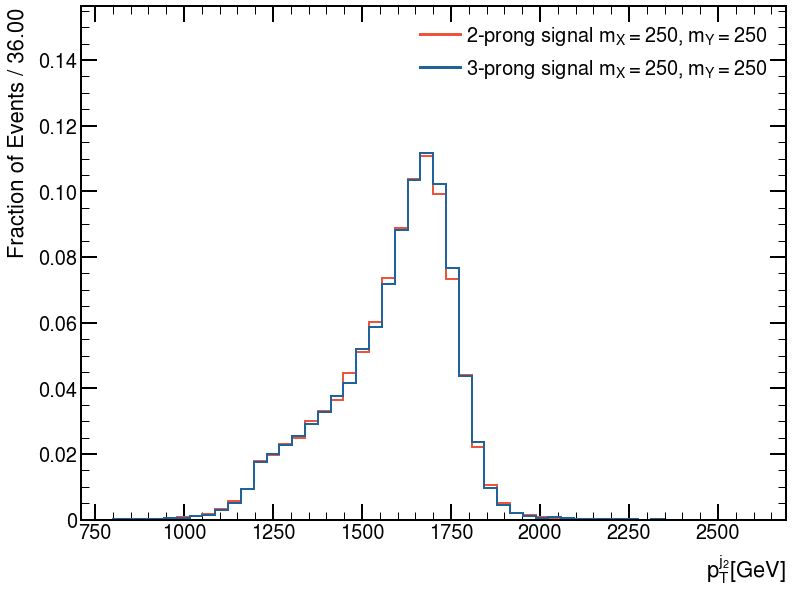

<Figure size 640x480 with 0 Axes>

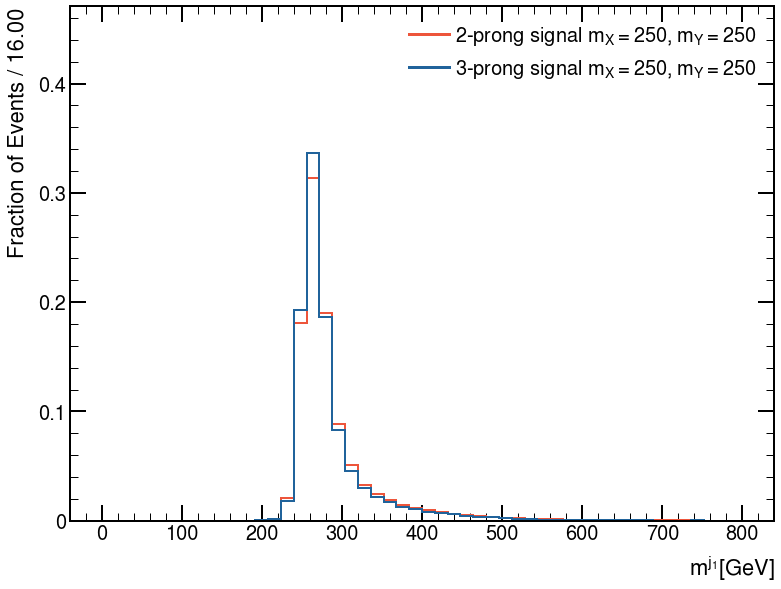

<Figure size 640x480 with 0 Axes>

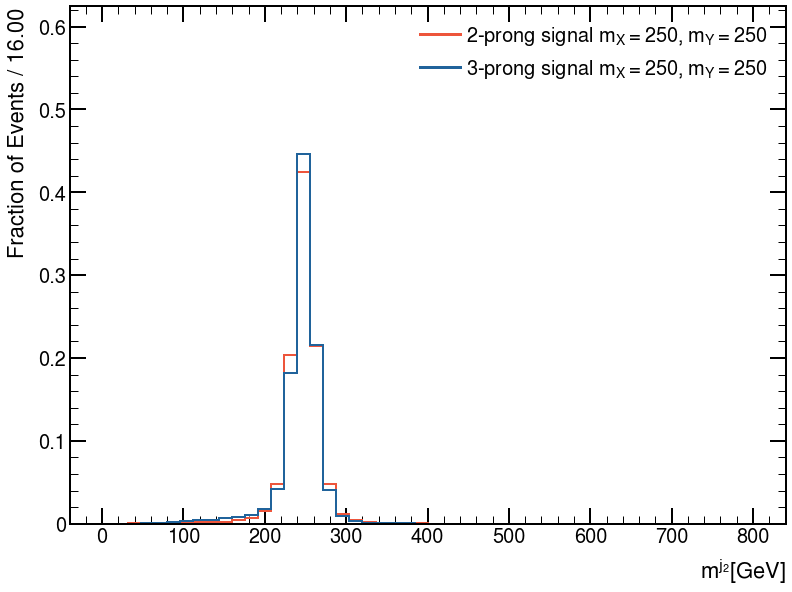

[INFO] Using deduced bin range (-2.209, 2.078)


<Figure size 640x480 with 0 Axes>

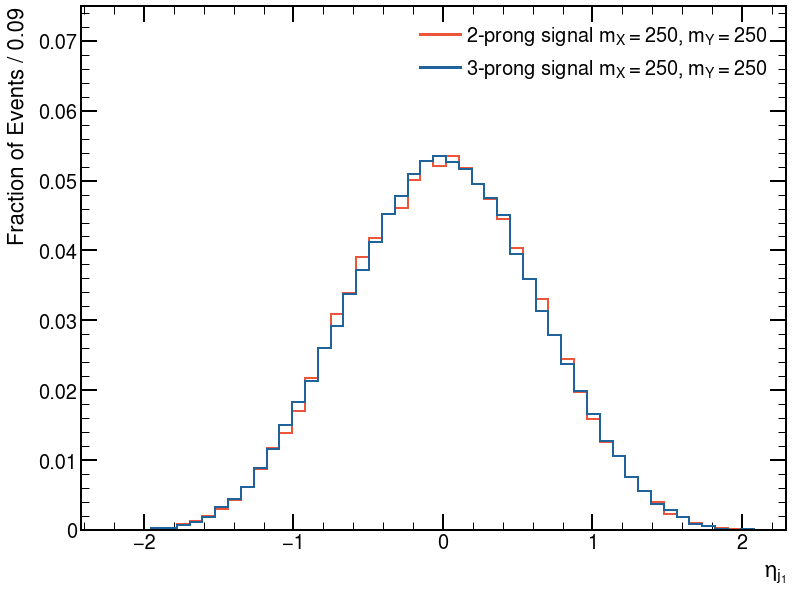

[INFO] Using deduced bin range (-3.608, 4.626)


<Figure size 640x480 with 0 Axes>

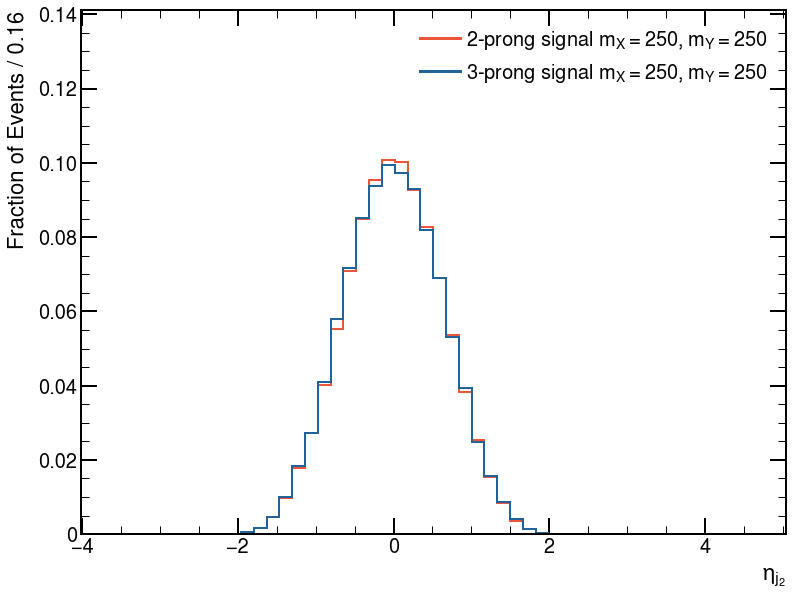

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

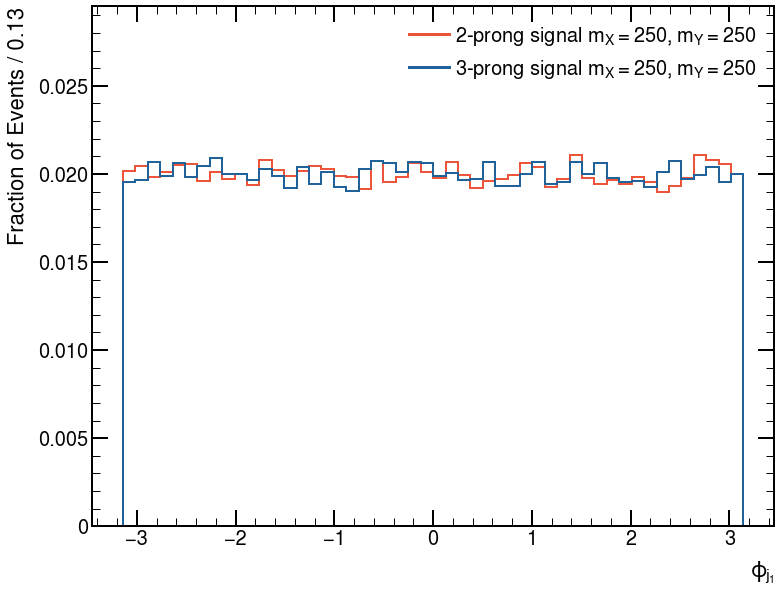

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

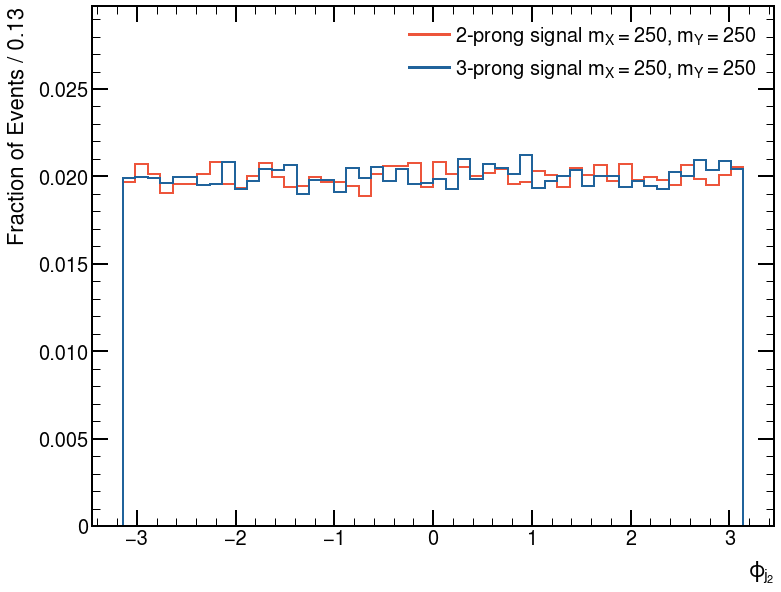

[INFO] Using deduced bin range (12.000, 181.000)


<Figure size 640x480 with 0 Axes>

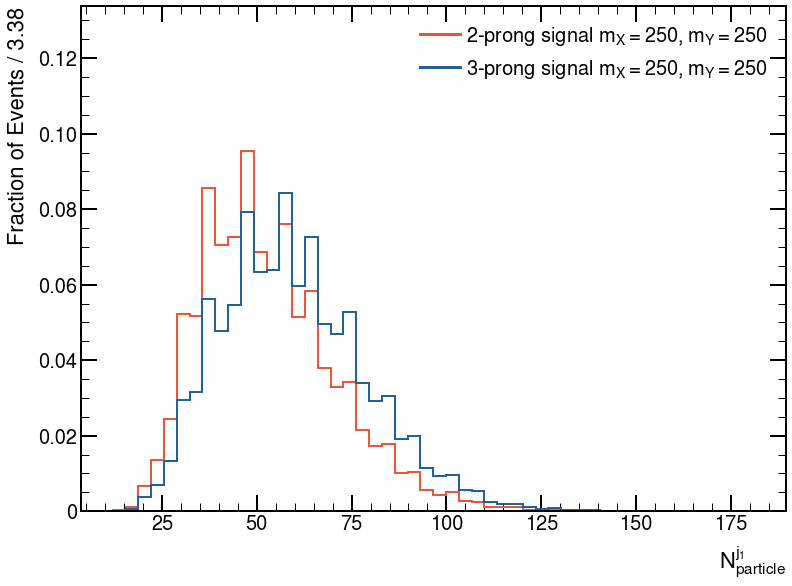

[INFO] Using deduced bin range (1.000, 148.000)


<Figure size 640x480 with 0 Axes>

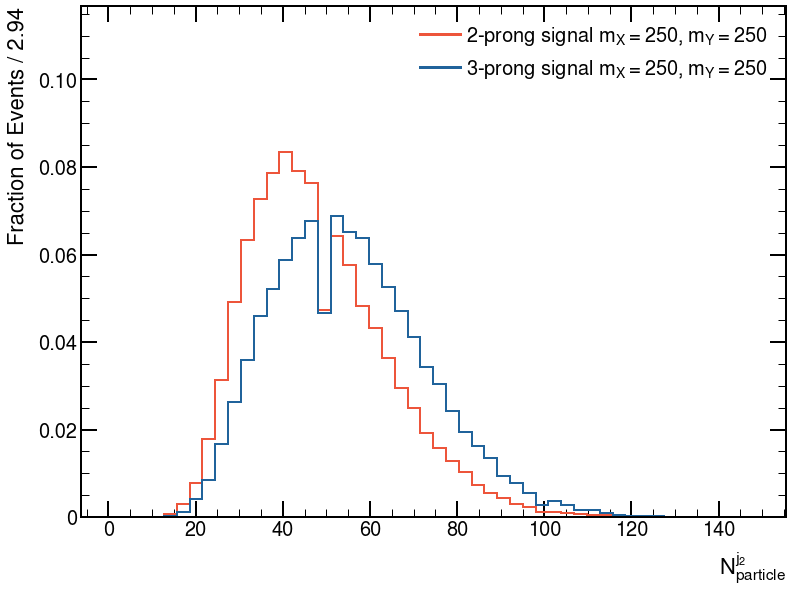

[INFO] Using deduced bin range (0.021, 0.639)


<Figure size 640x480 with 0 Axes>

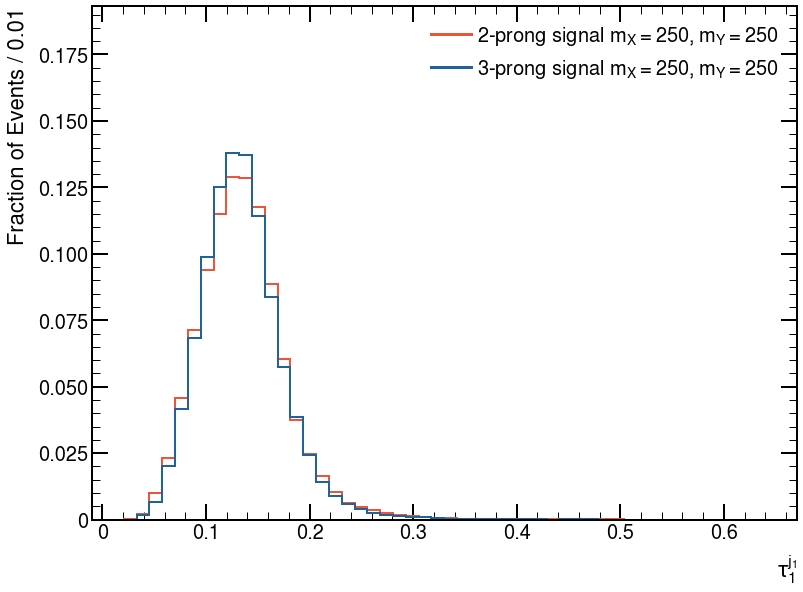

[INFO] Using deduced bin range (0.000, 0.393)


<Figure size 640x480 with 0 Axes>

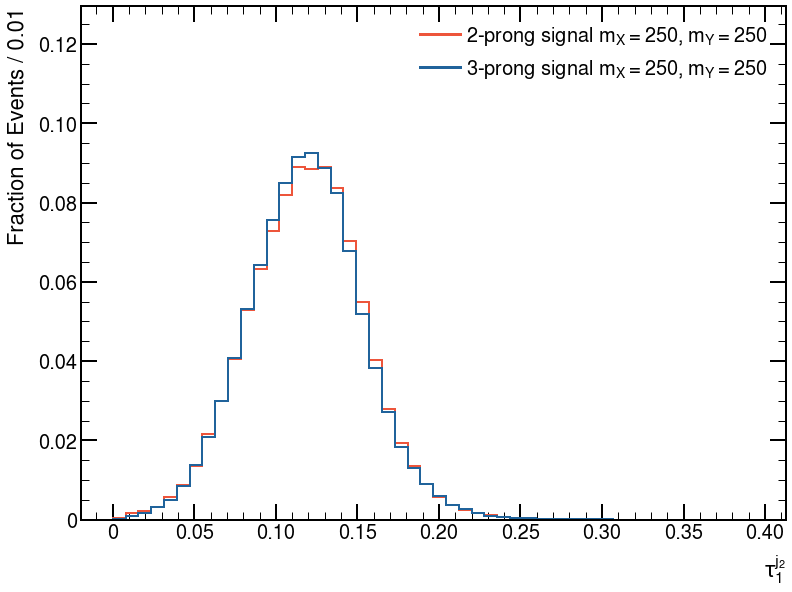

[INFO] Using deduced bin range (0.003, 0.286)


<Figure size 640x480 with 0 Axes>

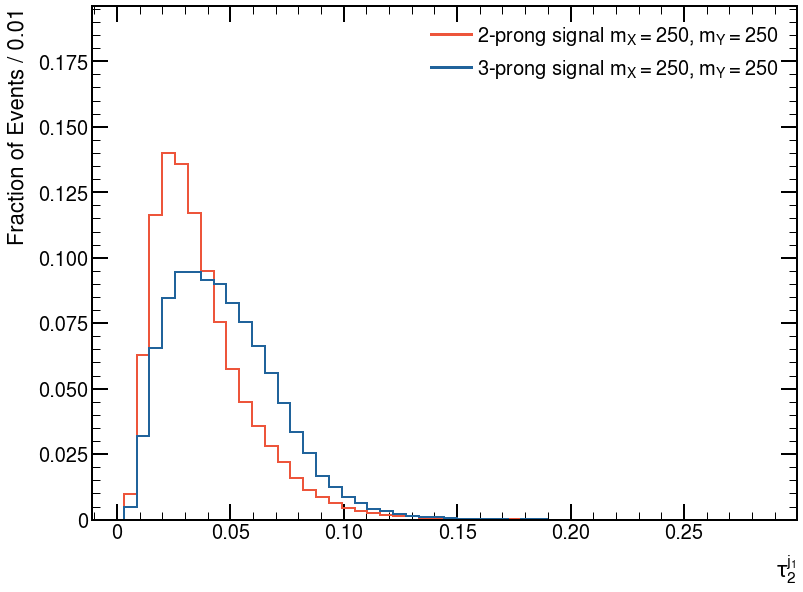

[INFO] Using deduced bin range (0.000, 0.287)


<Figure size 640x480 with 0 Axes>

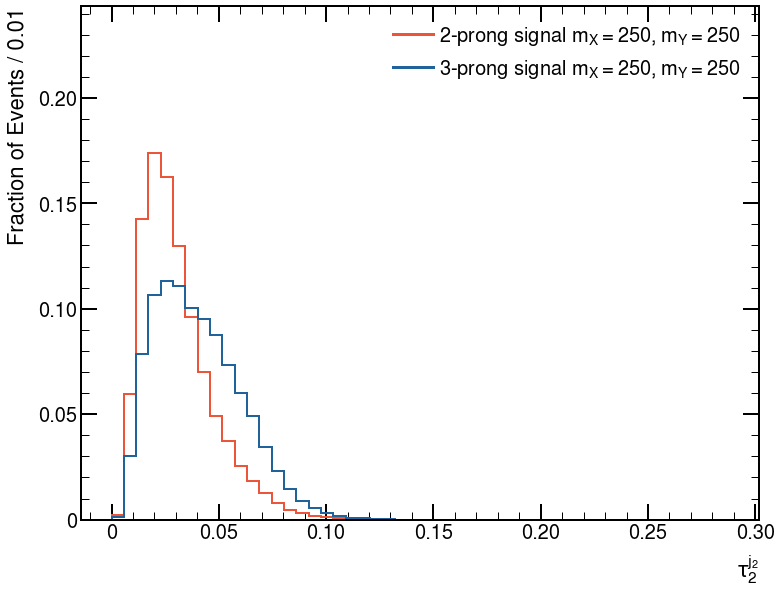

[INFO] Using deduced bin range (0.002, 0.149)


<Figure size 640x480 with 0 Axes>

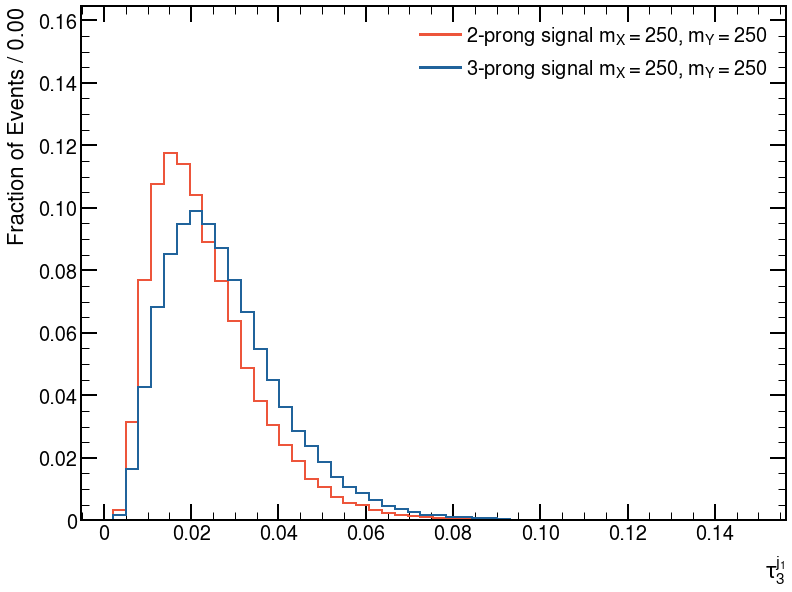

[INFO] Using deduced bin range (0.000, 0.203)


<Figure size 640x480 with 0 Axes>

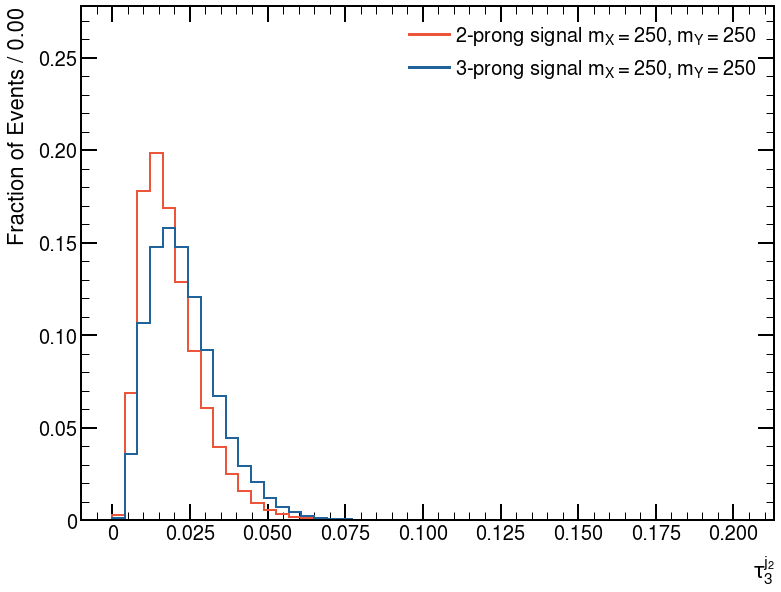

[INFO] Using deduced bin range (0.018, 0.877)


<Figure size 640x480 with 0 Axes>

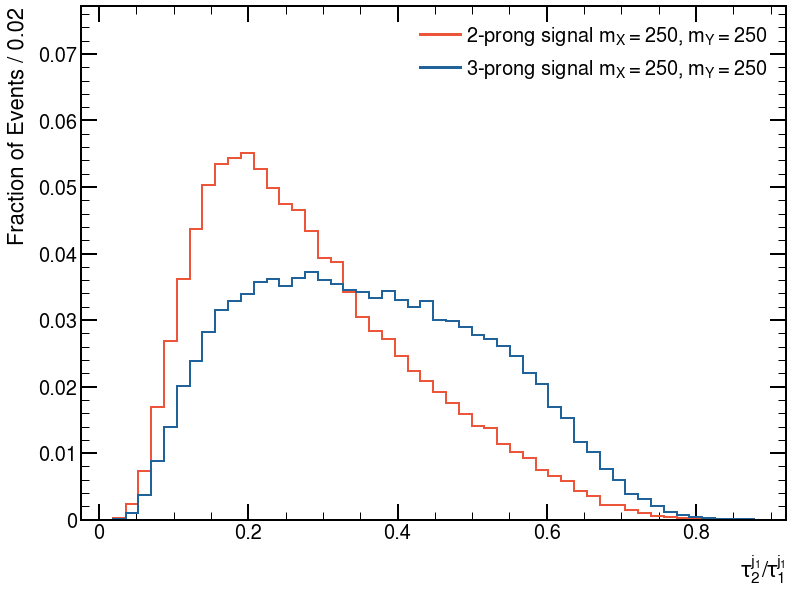

[INFO] Using deduced bin range (0.000, 0.909)


<Figure size 640x480 with 0 Axes>

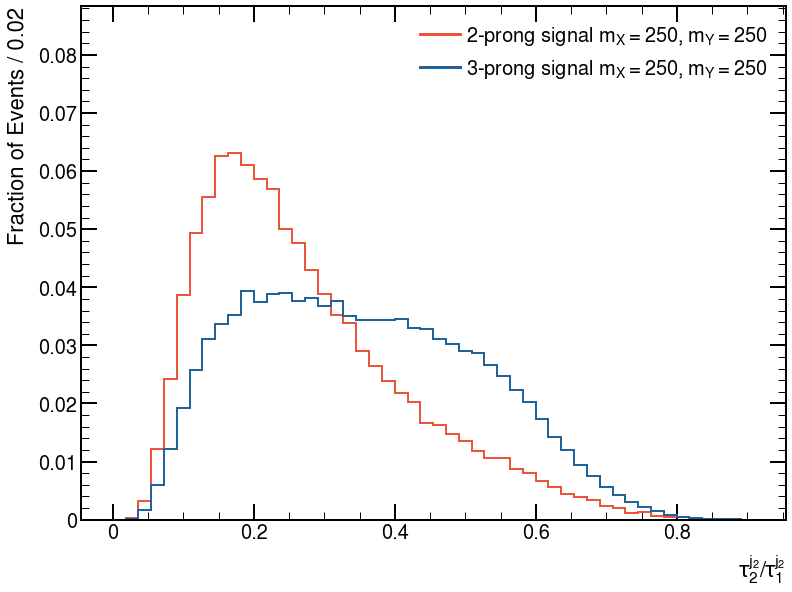

[INFO] Using deduced bin range (0.054, 0.945)


<Figure size 640x480 with 0 Axes>

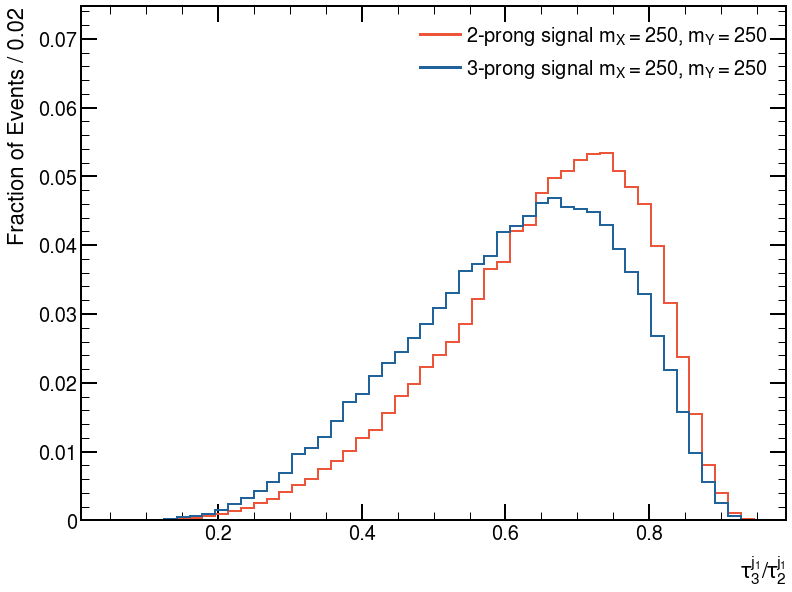

[INFO] Using deduced bin range (0.000, 0.940)


<Figure size 640x480 with 0 Axes>

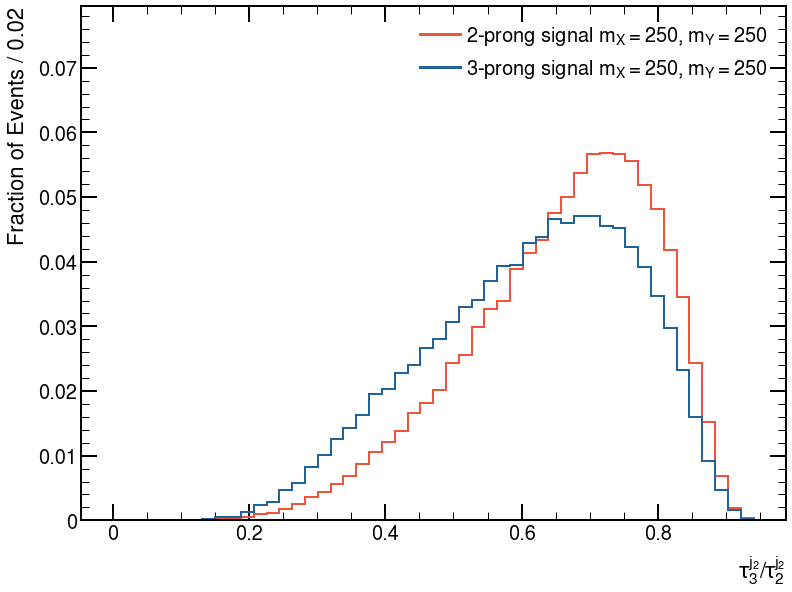

In [37]:
from quickstats.plots import VariableDistributionPlot
import matplotlib.pyplot as plt
options = {
    'mjj': {
        'xlabel': '$m_{jj} [GeV]$',
        'bin_range': (3200, 3800),
        'variable_scale': 1000
    },
    'lead_jet_pt': {
        'xlabel': '$p_T^{j_1} [GeV]$',
        'bin_range': (800, 2600),
        'variable_scale': 1000
    },
    'sub_jet_pt': {
        'xlabel': '$p_T^{j_2} [GeV]$',
        'bin_range': (800, 2600),
        'variable_scale': 1000
    },
    'lead_jet_m': {
        'xlabel': '$m^{j_1} [GeV]$',
        'bin_range': (0, 800),
        'variable_scale': 1000
    },
    'sub_jet_m': {
        'xlabel': '$m^{j_2} [GeV]$',
        'bin_range': (0, 800),
        'variable_scale': 1000
    },
    'lead_jet_eta': {
        'xlabel': r'$\eta_{j_1}$'
    },
    'sub_jet_eta': {
        'xlabel': r'$\eta_{j_2}$'
    },
    'lead_jet_phi': {
        'xlabel': r'$\phi_{j_1}$'
    },
    'sub_jet_phi': {
        'xlabel': r'$\phi_{j_2}$'
    },
    'lead_jet_N': {
        'xlabel': '$N_{particle}^{j_1}$'
    },
    'sub_jet_N': {
        'xlabel': '$N_{particle}^{j_2}$'
    },
    'lead_jet_tau1': {
        'xlabel': r'$\tau_1^{j_1}$'
    },
    'sub_jet_tau1': {
        'xlabel': r'$\tau_1^{j_2}$'
    },
    'lead_jet_tau2': {
        'xlabel': r'$\tau_2^{j_1}$'
    },
    'sub_jet_tau2': {
        'xlabel': r'$\tau_2^{j_2}$'
    },
    'lead_jet_tau3': {
        'xlabel': r'$\tau_3^{j_1}$'
    },
    'sub_jet_tau3': {
        'xlabel': r'$\tau_3^{j_2}$'
    },
    'lead_jet_tau12': {
        'xlabel': r'$\tau_2^{j_1}/\tau_1^{j_1}$'
    },
    'sub_jet_tau12': {
        'xlabel': r'$\tau_2^{j_2}/\tau_1^{j_2}$'
    },
    'lead_jet_tau23': {
        'xlabel': r'$\tau_3^{j_1}/\tau_2^{j_1}$'
    },
    'sub_jet_tau23': {
        'xlabel': r'$\tau_3^{j_2}/\tau_2^{j_2}$'
    }
}
label_map = {
    '2prong' : '2-prong signal',
    '3prong' : '3-prong signal'
}
for mass_point in mass_points:
    m1, m2 = mass_point.split("_")
    mass_label = f"$m_X = {m1}, m_Y = {m2}$"
    this_label_map = {k: f"{v} {mass_label}" for k, v in label_map.items()}
    plotter = VariableDistributionPlot(dfs[mass_point], label_map=this_label_map)
    for column in options:
        plotter.draw(column,
                     targets=['2prong', '3prong'],
                     #targets=['500_100', '500_100_LHCO'],
                     **options[column],
                     bins=50,
                     normalize=True,
                     ypad=0.25)
        plt.show()